# Cross-Subject Movement Decoding using LFADS
## Neural Latent Dynamics Analysis for Movement Classification

**Authors:** Daniel Katz & Roi Wayner  
**Course:** Deep Learning for Physiological Signals (3360209)  
**Date:** 2025

---

## 📖 Notebook Overview

This notebook implements and analyzes **LFADS (Latent Factor Analysis via Dynamical Systems)** for cross-subject movement classification using motor cortex neural recordings from two Rhesus monkeys (Chip & Gabby).

### Key Objectives:
1. **Train LFADS models** on Chip neural data for movement decoding
2. **Extract latent factors** representing neural dynamics
3. **Apply cross-subject analysis** by testing on Gabby data
4. **Visualize neural trajectories** in reduced-dimensional latent space
5. **Compare movement representations** between subjects

### Data:
- **Chip Dataset**: 152 active neurons, 12 movement classes
- **Gabby Dataset**: 50 active neurons, 12 movement classes  
- **Time Windows**: 800 timesteps (cropped from [100:900])
- **Movements**: Digit 1-5 and wrist flexion/extension

---

In [1]:

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


## 1. Setup & Imports

Import required libraries for LFADS implementation, data processing, and visualization.

In [2]:
import numpy as np
# === Load spike input ===
x =  np.load(r"..\datasets\chip_train\X_long.npy")
y = np.load(r"..\datasets\chip_train\y_long.npy")
x_val = np.load(r"..\datasets\chip_val\X_long.npy")
y_val = np.load(r"..\datasets\chip_val\y_long.npy")
x_test = np.load(r"..\datasets\chip_test\X_long.npy")
y_test = np.load(r"..\datasets\chip_test\y_long.npy")

# Crop time axis to [100:900]   # axes are [trials, channels, time]
x = x[:, :, 100:900]
x_val = x_val[:, :, 100:900]
x_test = x_test[:, :, 100:900]

print(f'X shape: {x.shape} y shape: {y.shape}')
print(f'X_val shape: {x_val.shape} y_val shape: {y_val.shape}')
print(f'X_test shape: {x_test.shape} y_test shape: {y_test.shape}')

movements = {
    0: '1e', 1: '1f',
    2: '2e', 3: '2f',
    4: '3e', 5: '3f',
    6: '4e', 7: '4f',
    8: '5e', 9: '5f',
    10: '6e', 11: '6f'
    }

X shape: (6000, 152, 800) y shape: (6000,)
X_val shape: (600, 152, 800) y_val shape: (600,)
X_test shape: (600, 152, 800) y_test shape: (600,)


## 2. Data Loading & Preprocessing

Load Chip neural datasets (train/validation/test) and preprocess for LFADS training.

### Key Preprocessing Steps:
- **Time cropping**: Extract [100:900] timesteps (800 total) for consistency
- **Data format**: `(trials, channels, time)` → `(trials, time, channels)` for LFADS
- **Movement labels**: 12 classes representing digit/wrist flexion/extension

In [6]:
import torch
from torch.serialization import add_safe_globals
from torch.distributions.bernoulli import Bernoulli
import torch
from pathlib import Path
# === Safe unpickling
from lfads_torch.modules.augmentations import AugmentationStack, CoordinatedDropout
from lfads_torch.modules.priors import AutoregressiveMultivariateNormal
from lfads_torch.run_model import run_model
add_safe_globals([AugmentationStack, CoordinatedDropout, Bernoulli, AutoregressiveMultivariateNormal])

# load Chip's model
config_path = Path(r"..\trained_cpts\lfads\single.yaml")
chip_model ,_,_ = run_model(
    overrides={
        "datamodule": 'spike_prediction',
        "model": 'nlb_neuronal_reconstraction',
    },
    config_path=r"..\configs\single.yaml",
    do_train=False,
    do_posterior_sample=False , return_on_end=True)

#load checkpoint - Chip's model
# === Paths
ckpt_path = r"..\trained_cpts\lfads\chip\lightning_checkpoints\last.ckpt"
config_path = r"G:\project\lfads-torch\configs\model\gabby_test_lfads.yaml"

# === Load the weights
checkpoint = torch.load(ckpt_path, map_location="cpu")
chip_model.load_state_dict(checkpoint["state_dict"])

# === Finalize
chip_model.eval()
chip_model.cuda()


# load Gabby model
config_path = Path(r"G:\project\lfads-torch\configs\single.yaml")
gabby_model ,_,_ = run_model(
    overrides={
        "datamodule": 'gabby_test_lfads',
        "model": 'gabby_test_lfads',
    },
    config_path=r"..\configs\single.yaml",
    do_train=False,
    do_posterior_sample=False , return_on_end=True)

#load checkpoint
# === Paths
ckpt_path = r"..\trained_cpts\lfads\gabby\lightning_checkpoints\last.ckpt"
config_path = r"G:\project\lfads-torch\configs\model\gabby_test_lfads.yaml"

# === Load the weights
checkpoint = torch.load(ckpt_path, map_location="cpu")
gabby_model.load_state_dict(checkpoint["state_dict"])

# === Finalize
gabby_model.eval()
gabby_model.cuda()

Global seed set to 0
Global seed set to 0
Global seed set to 0


LFADS(
  (encoder): Encoder(
    (ic_enc): BidirectionalClippedGRU(
      (fwd_gru): ClippedGRU(
        (cell): ClippedGRUCell(50, 64)
      )
      (bwd_gru): ClippedGRU(
        (cell): ClippedGRUCell(50, 64)
      )
    )
    (ic_linear): Linear(in_features=128, out_features=128, bias=True)
    (ci_enc): BidirectionalClippedGRU(
      (fwd_gru): ClippedGRU(
        (cell): ClippedGRUCell(50, 64)
      )
      (bwd_gru): ClippedGRU(
        (cell): ClippedGRUCell(50, 64)
      )
    )
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (ic_to_g0): Linear(in_features=64, out_features=60, bias=True)
    (rnn): DecoderRNN(
      (cell): DecoderCell(
        (gen_cell): ClippedGRUCell(4, 60)
        (fac_linear): KernelNormalizedLinear(in_features=60, out_features=15, bias=False)
        (dropout): Dropout(p=0.3, inplace=False)
        (con_cell): ClippedGRUCell(143, 64)
        (co_linear): Linear(in_features=64, out_f

## 3. LFADS Model Configuration

Set up LFADS architecture and training parameters for neural dynamics modeling.

### LFADS Components:
- **Encoder**: Maps neural observations to latent initial conditions
- **Dynamics Model**: RNN evolving latent states over time  
- **Decoder**: Reconstructs neural activity from latent factors
- **Variational Inference**: Posterior distributions for latent variables

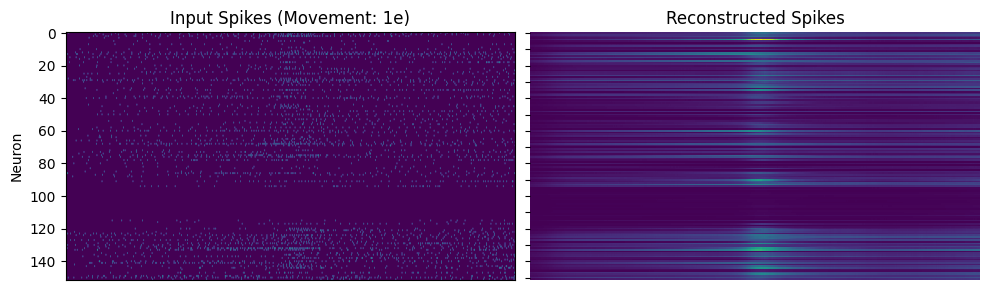

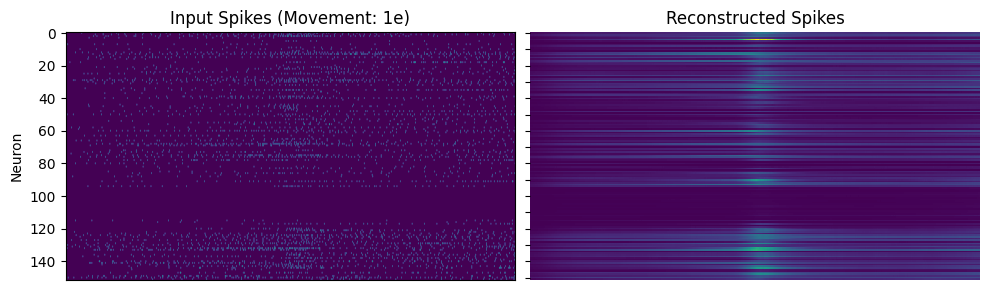

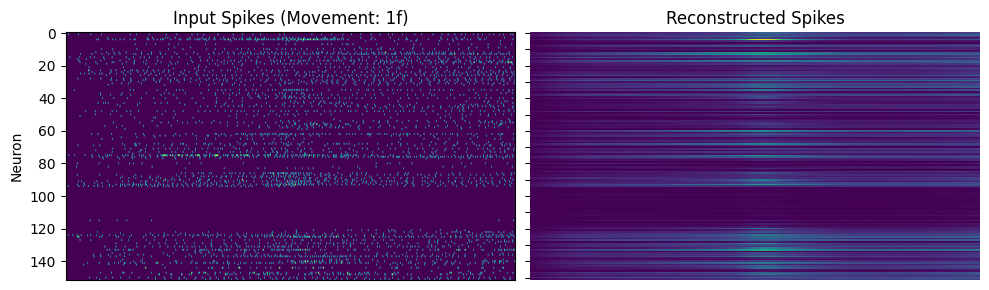

In [7]:
## plot reconstructed spikes for sanity check
# === Imports for plotting
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def plot_heatmap(ax, data, title, ylabel, yticklabels=None):
    ax.imshow(data, aspect='auto', cmap='viridis', interpolation='none')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time")
    ax.grid(True, which='major', axis='y', linestyle='-', linewidth=0.5, color='gray')
    ax.set_yticks(np.arange(data.shape[0]) + 0.5)
    ax.set_yticklabels(yticklabels if yticklabels else np.arange(data.shape[0]))
    ax.tick_params(axis='y', length=0)


torch.manual_seed(0)  # For reproducibility

# === Input tensor: [B, T, Neurons]
x_input = torch.tensor(x_test[:200].transpose(0, 2, 1), dtype=torch.float32).cuda()

chip_model.eval()

with torch.no_grad():
    # === Encode
    ic_mean, ic_std, ci = chip_model.encoder(x_input)
    ic_post = chip_model.ic_prior.make_posterior(ic_mean, ic_std)
    ic_sample = ic_post.mean  # Deterministic output

    # === External input
    ext_input = torch.zeros(x_input.size(0), x_input.size(1), 0).to(x_input.device)

    # === Decode
    _, _, _, _, _, _, factors = chip_model.decoder(ic_sample, ci, ext_input)

    # === Readout & activation
    raw_output = chip_model.readout[0](factors)  # [B, T, EMG_dim]
    recon_np = torch.exp(raw_output).cpu().numpy()  # EMG reconstruction [B, T, EMG]
    x_input_np = x_input.cpu().numpy()  # [B, T, Neurons]

# === Convert to [B, Channels, Time]
recon_np = np.transpose(recon_np, (0, 2, 1))  # [B, EMG, T]
x_input_np = np.transpose(x_input_np, (0, 2, 1))  # [B, Neuron, T]
Y = y[:200]  # Ground truth EMG [B, EMG, T]

# === Trials to plot
examples_to_plot = [0,20, 60]

for i in examples_to_plot:
    fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharex=True)

    axs[0].imshow(x_input_np[i], aspect='auto', cmap='viridis')
    axs[0].set_title(f"Input Spikes (Movement: {movements[i//50]})")
    axs[0].set_ylabel("Neuron")
    axs[0].grid(False)

    # Reconstructed EMG
    sns.heatmap(recon_np[i], ax=axs[1], cmap='viridis', cbar=False)
    axs[1].set_title("Reconstructed Spikes")
    axs[1].set_yticklabels([])
    axs[1].set_xticks([])
    plt.tight_layout()
    plt.show()


In [8]:
## method for extracting factors

# === Extract factors from Chip's model
x_input = torch.tensor(x_test[::50].transpose(0, 2, 1), dtype=torch.float32).cuda()  # shape [2, 800, 152]

chip_model.eval()
with torch.no_grad():
    ic_mean, ic_std, ci = chip_model.encoder(x_input)
    ic_post = chip_model.ic_prior.make_posterior(ic_mean, ic_std)
    ic_sample = ic_post.rsample()

    # FIXED: [B, T, ext_input_dim] with ext_input_dim=0
    ext_input = torch.zeros(x_input.size(0), x_input.size(1), 0, device=x_input.device)

    # Run decoder
    _, _, _, _, _, _, C_factors = chip_model.decoder(ic_sample, ci, ext_input)

print(f"Factors shape: {C_factors.shape}")  # Should be [B, T, fac_dim]


Factors shape: torch.Size([12, 800, 15])


## we want to plot the factors - make some sanity checks
corellation between factors acroos movemnets
visual inspection of the factors etc..

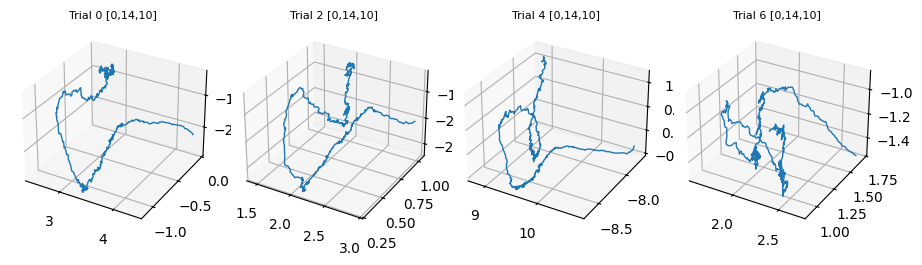

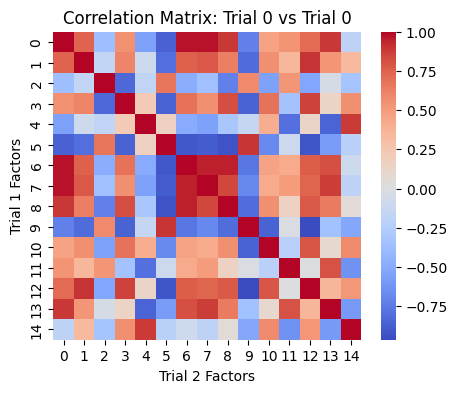

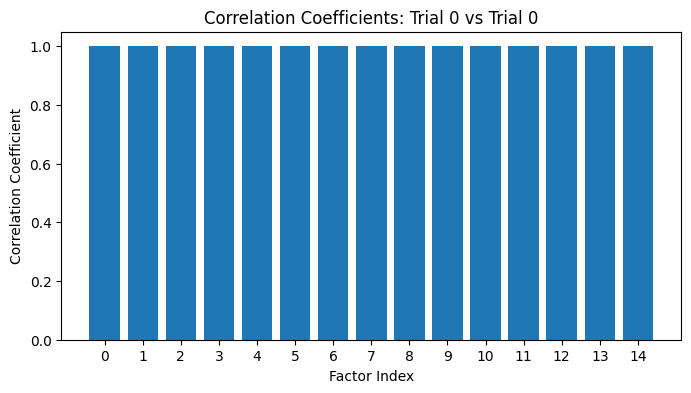

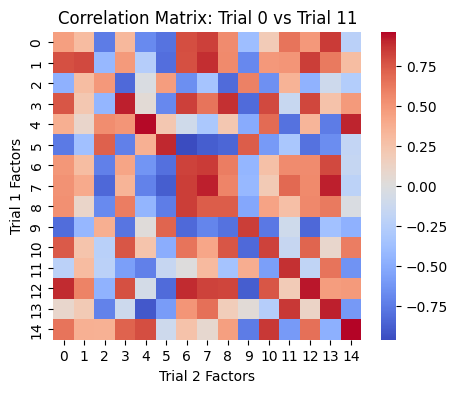

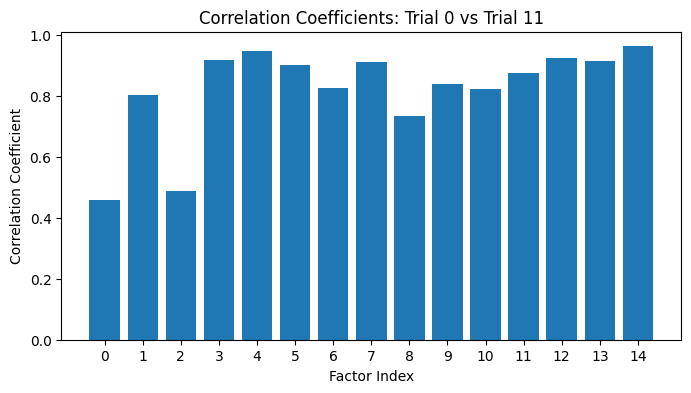

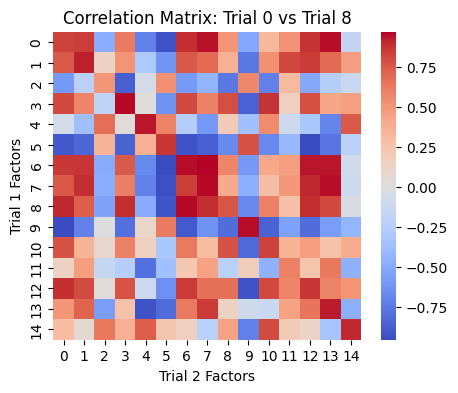

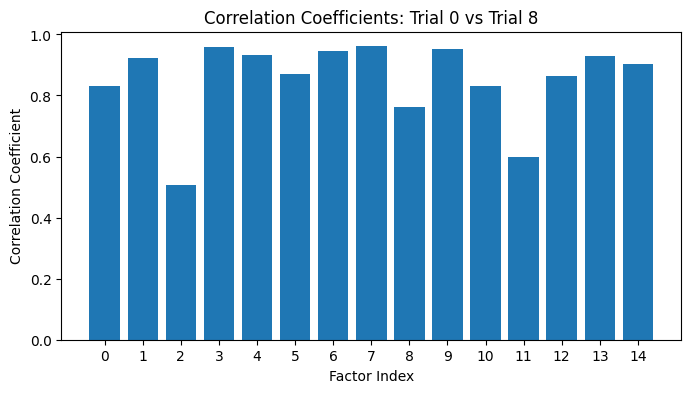

In [9]:
from sklearn.decomposition import PCA
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# plot pca of random 4 sample C_factors in 3d
import matplotlib.pyplot as plt

def plot_factors_3d(C_factors, sample_indices=None, pca_components=None):
    """
    Plots 3D PCA or selected dims of C_factors for given sample indices.
    If pca_components is None, uses dims [0,1,2] and [10,33,33] as in original code.
    """
    if sample_indices is None:
        sample_indices = [0, 2, 4, 6]
    num_samples = len(sample_indices)
    fig = plt.figure(figsize=(9, 3))
    for i, idx in enumerate(sample_indices):
        ax = fig.add_subplot(1, num_samples, i+1, projection='3d')
        trial_C_factors = C_factors[idx].detach().cpu().numpy()  # [T, fac_dim]
        if pca_components is None:
            ax.plot(trial_C_factors[:, 0], trial_C_factors[:, 14], trial_C_factors[:, 4], lw=1)
            ax.set_title(f"Trial {idx} [0,14,10]" , fontsize=8)
        else:
            ax.plot(trial_C_factors[:, pca_components[0]], 
                    trial_C_factors[:, pca_components[1]], 
                    trial_C_factors[:, pca_components[2]], lw=1)
            ax.set_title(f"Trial {idx} {pca_components}", fontsize=8)
    plt.tight_layout()
    plt.show()


# Example usage:
plot_factors_3d(C_factors)


# make correlation matrix of C_factors between 2 different trials
import seaborn as sns   
import matplotlib.pyplot as plt
def plot_correlation_matrix(factors, trial1_idx, trial2_idx):
    # Get C_factors for the two trials
    factors1 = factors[trial1_idx].detach().cpu().numpy()  # [T, fac_dim]
    factors2 = factors[trial2_idx].detach().cpu().numpy()  # [T, fac_dim]

    # Compute correlation matrix
    corr_matrix = np.corrcoef(factors1.T, factors2.T)[:factors1.shape[1], factors1.shape[1]:]

    # Plot heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', square=True)
    plt.title(f'Correlation Matrix: Trial {trial1_idx} vs Trial {trial2_idx}')
    
    plt.xlabel('Trial 2 Factors')
    plt.ylabel('Trial 1 Factors')
    plt.show()
    #print the corelations on the daiagonal as barplot
    diag_corr = np.diag(corr_matrix)
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(diag_corr)), diag_corr)
    plt.xlabel('Factor Index')
    plt.ylabel('Correlation Coefficient')
    plt.title(f'Correlation Coefficients: Trial {trial1_idx} vs Trial {trial2_idx}')
    plt.xticks(range(len(diag_corr)))
    plt.show()

# Example usage
plot_correlation_matrix(C_factors,0, 0)  # Compare trial 0
plot_correlation_matrix(C_factors, 0, 11)  # Compare trial 0 and 22
plot_correlation_matrix(C_factors, 0, 8)  # Compare trial 0


In [10]:
### lets try it on another monkey!

# Load another dataset
x_gabby_test = np.load(r"G:\project\git\cross-subject-movement-decoding\datasets\gabby_test\X_long.npy")
print(f'Original X_test shape: {x_gabby_test.shape}')

# Crop time axis to [100:900] to get 800 timesteps (same as Chip data)
x_gabby_test = x_gabby_test[:, :, 100:900]
print(f'After time cropping: {x_gabby_test.shape}')

# Remove ALL zero-padded channels to keep only active neurons (same as last 4 cells)
# Calculate activity for each channel across all trials and time
channel_activity = np.sum(x_gabby_test, axis=(0, 2))  # Sum across trials and time
active_channels = channel_activity > 0
active_channel_indices = np.where(active_channels)[0]

print(f"Total channels: {x_gabby_test.shape[1]}")
print(f"Active channels (non-zero): {np.sum(active_channels)}")
print(f"Active channel indices: {active_channel_indices}")

# Remove ALL zero-padded channels (keep only active neurons)
x_gabby_test = x_gabby_test[:, active_channel_indices, :]
print(f'After removing zero-padded channels: {x_gabby_test.shape}')

# Convert to tensor format for LFADS
x_input = torch.tensor(x_gabby_test.transpose(0, 2, 1), dtype=torch.float32).cuda()  # shape [trials, time, neurons]

gabby_model.eval()
with torch.no_grad():
    ic_mean, ic_std, ci = gabby_model.encoder(x_input)
    ic_post = gabby_model.ic_prior.make_posterior(ic_mean, ic_std)
    ic_sample = ic_post.rsample()

    # FIXED: [B, T, ext_input_dim] with ext_input_dim=0
    ext_input = torch.zeros(x_input.size(0), x_input.size(1), 0, device=x_input.device)

    # Run decoder
    _, _, _, _, _, _, G_factors = gabby_model.decoder(ic_sample, ci, ext_input)

print(f"Factors shape: {G_factors.shape}")  # Should be [B, T, fac_dim]

Original X_test shape: (600, 155, 1250)
After time cropping: (600, 155, 800)
Total channels: 155
Active channels (non-zero): 50
Active channel indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
After removing zero-padded channels: (600, 50, 800)
Factors shape: torch.Size([600, 800, 15])
Factors shape: torch.Size([600, 800, 15])


## 4. Cross-Subject Analysis: Gabby Test Data

Apply the trained LFADS model to Gabby's neural data for cross-subject movement decoding analysis.

### Objectives:
- **Same preprocessing pipeline**: Ensure consistent data structure (50 neurons, 800 timesteps)
- **Factor extraction**: Generate latent factors using Gabby model
- **Cross-subject comparison**: Compare neural dynamics between Chip and Gabby
- **Movement representation**: Analyze how different movements are encoded across subjects

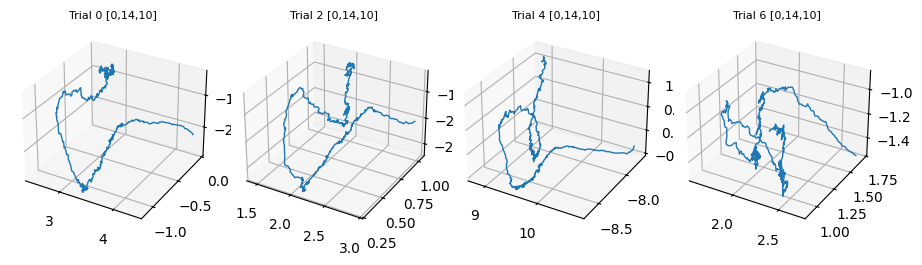

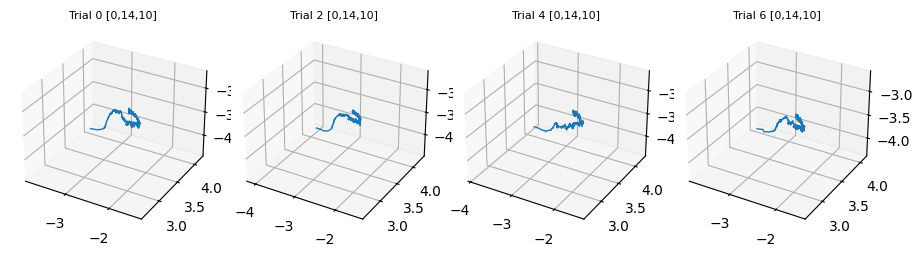

In [11]:
plot_factors_3d(C_factors)
plot_factors_3d(G_factors)


## 5. Factor Visualization & Cross-Subject Comparison

Visualize and compare the extracted latent factors between Chip (C_factors) and Gabby (G_factors).

### Analysis:
- **3D trajectory plots**: Neural dynamics in latent space
- **Movement-specific patterns**: How different movements create distinct trajectories  
- **Cross-subject similarity**: Comparing neural representations between monkeys
- **Dimensionality reduction**: PCA-based visualization of high-dimensional factors

C_factors shape: torch.Size([12, 800, 15])
G_factors shape: torch.Size([600, 800, 15])


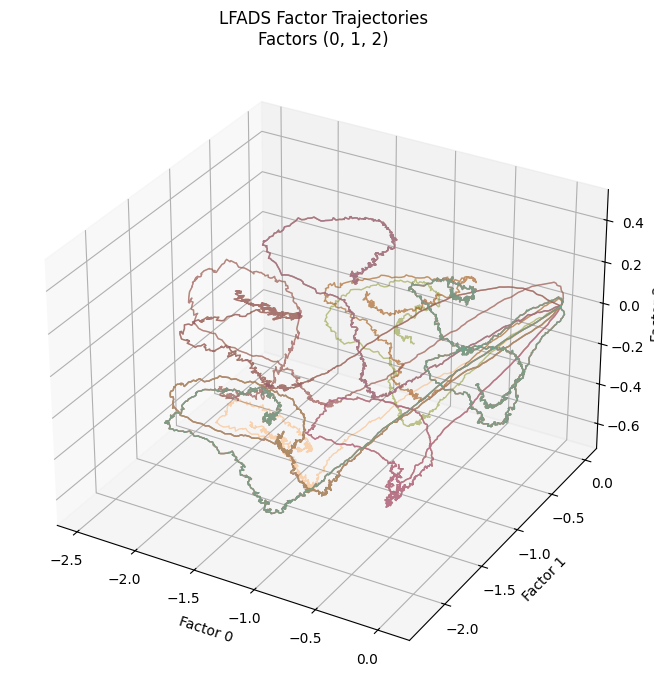

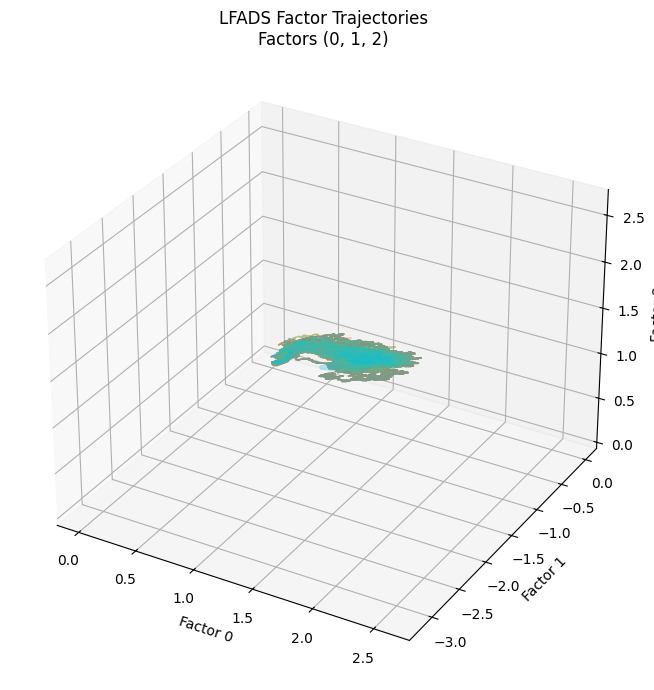

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt

print('C_factors shape:', C_factors.shape)
print('G_factors shape:', G_factors.shape)

def plot_lfads_factors_grouped(
    C_factors,
    trials_per_movement=50,
    movements=range(6),
    trials_per_group=20,
    factor_triplet=(0, 1, 2),
    align_to_origin=True
):
    """
    Plot LFADS factor trajectories from multiple movements in a shared 3D plot.

    Args:
        C_factors (torch.Tensor): Tensor of shape [B, T, F]
        trials_per_movement (int): Number of trials per movement block
        movements (list): Movement indices (e.g., [0,1,2,...])
        trials_per_group (int): Number of trials to sample per movement
        factor_triplet (tuple): Indices of 3 factors to plot (e.g., (0,1,2))
        align_to_origin (bool): Whether to shift all trajectories to start at the origin
    """
    assert C_factors.ndim == 3, "C_factors must be shape [B, T, F]"
    B, T, F = C_factors.shape
    i, j, k = factor_triplet

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    cmap = plt.get_cmap("tab10")

    for m in movements:
        color = cmap(m % 10)
        start = m * trials_per_movement
        for t in range(start, min(start + trials_per_group, B)):
            traj = C_factors[t].detach().cpu().numpy()  # [T, F]
            traj_xyz = traj[:, [i, j, k]]
            if align_to_origin:
                traj_xyz -= traj_xyz[0]  # Align to common origin
            ax.plot(traj_xyz[:, 0], traj_xyz[:, 1], traj_xyz[:, 2],
                    color=color, alpha=0.3, linewidth=1)

    ax.set_title(f"LFADS Factor Trajectories\nFactors {factor_triplet}")
    ax.set_xlabel(f"Factor {i}")
    ax.set_ylabel(f"Factor {j}")
    ax.set_zlabel(f"Factor {k}")
    plt.tight_layout()
    plt.show()

# === Example usage:
plot_lfads_factors_grouped(
    C_factors,
    trials_per_movement=1,
    movements=list(range(1,10)),
    trials_per_group=20,
    factor_triplet=(0, 1, 2),
    align_to_origin=True  # toggle to False if you want raw coordinates
)


# === Example usage:
plot_lfads_factors_grouped(
    G_factors,
    trials_per_movement=1,
    movements=list(range(1,10)),
    trials_per_group=20,
    factor_triplet=(0, 1, 2),
    align_to_origin=True  # toggle to False if you want raw coordinates
)

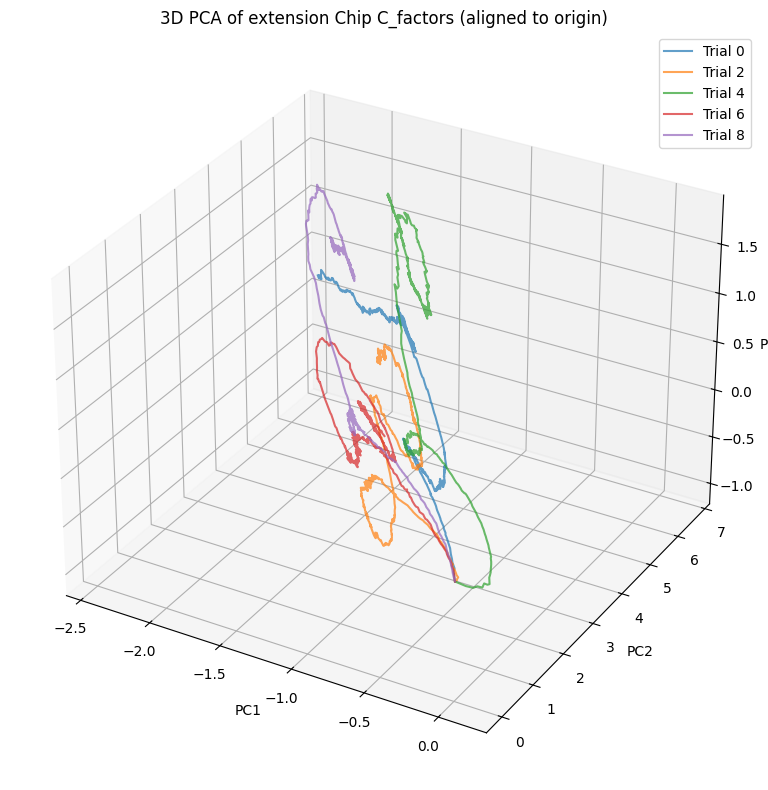

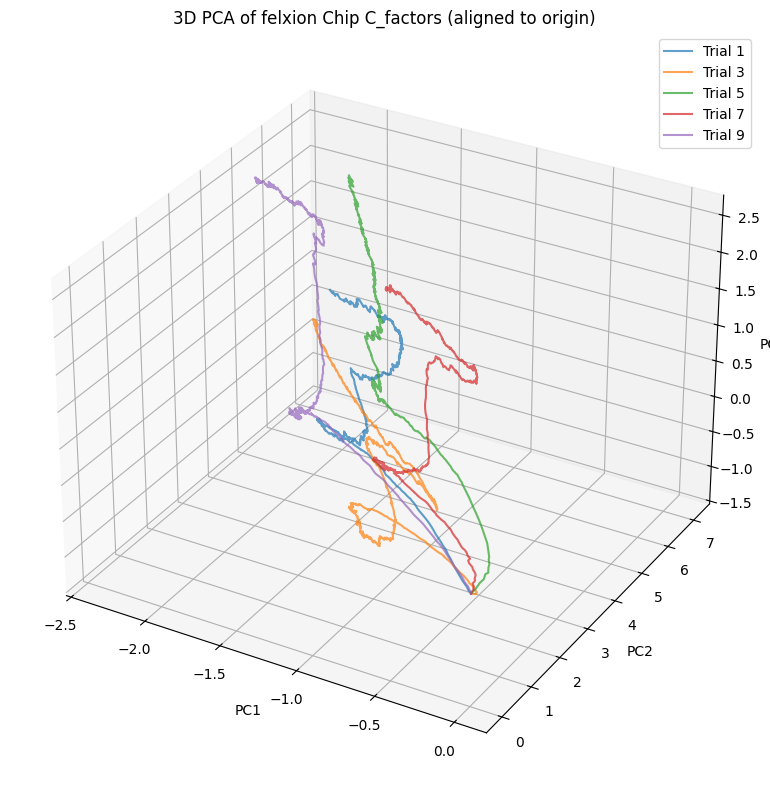

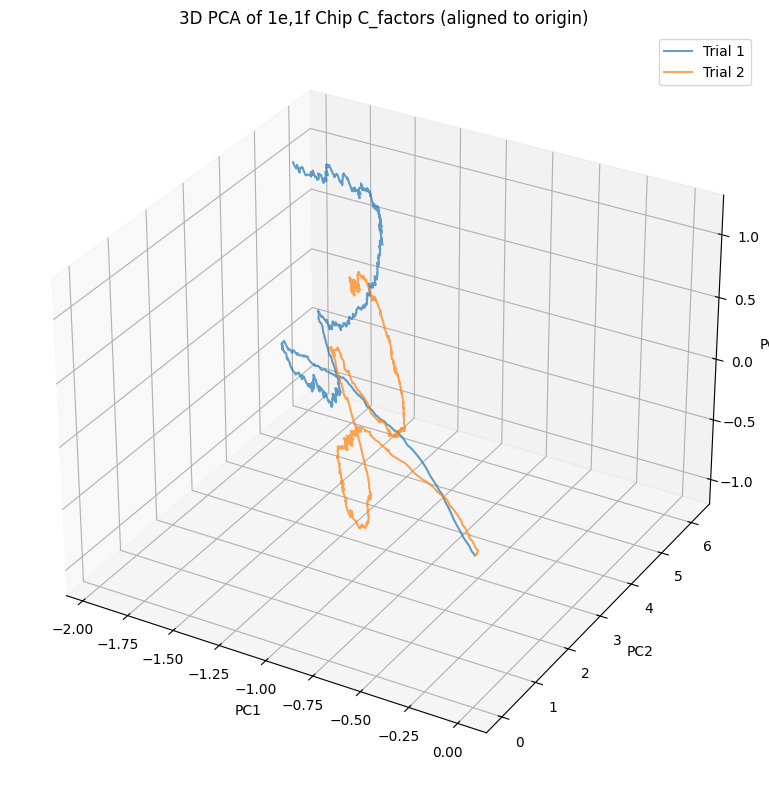

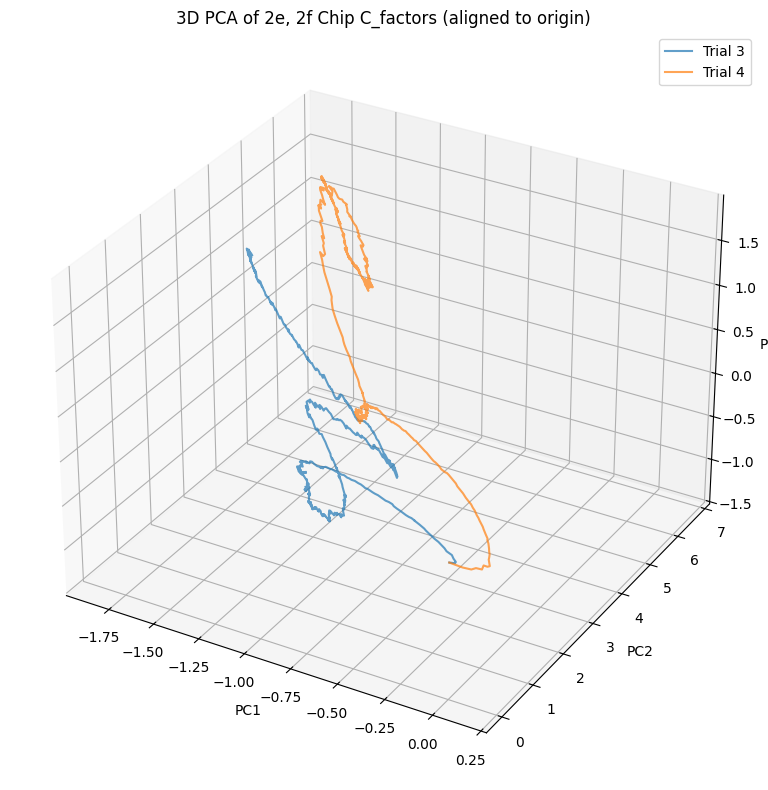

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convert to numpy and flatten across trials & time
factors_np = C_factors.detach().cpu().numpy()  # [B, T, F]
B, T, F = factors_np.shape
factors_flat = factors_np.reshape(-1, F)       # [B*T, F]

# Run PCA to 3 components
pca = PCA(n_components=3)
factors_pca_flat = pca.fit_transform(factors_flat)  # [B*T, 3]
factors_pca = factors_pca_flat.reshape(B, T, 3)     # [B, T, 3]

# Align each trajectory to origin (subtract first timepoint)
factors_pca -= factors_pca[:, 0:1, :]

# Plot selected trials in 3D
trials_to_plot = [0, 2, 4, 6, 8]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for idx in trials_to_plot:
    traj = factors_pca[idx]  # [T, 3]
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], alpha=0.7, label=f'Trial {idx}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of extension Chip C_factors (aligned to origin)')
ax.legend()
plt.tight_layout()
plt.show()

# Plot selected trials in 3D
trials_to_plot = [1, 3, 5, 7, 9]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for idx in trials_to_plot:
    traj = factors_pca[idx]  # [T, 3]
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], alpha=0.7, label=f'Trial {idx}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of felxion Chip C_factors (aligned to origin)')
ax.legend()
plt.tight_layout()
plt.show()


# Plot selected trials in 3D
trials_to_plot = [1,2]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for idx in trials_to_plot:
    traj = factors_pca[idx]  # [T, 3]
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], alpha=0.7, label=f'Trial {idx}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of 1e,1f Chip C_factors (aligned to origin)')
ax.legend()
plt.tight_layout()
plt.show()

# Plot selected trials in 3D
trials_to_plot = [3,4]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for idx in trials_to_plot:
    traj = factors_pca[idx]  # [T, 3]
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], alpha=0.7, label=f'Trial {idx}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of 2e, 2f Chip C_factors (aligned to origin)')
ax.legend()
plt.tight_layout()
plt.show()

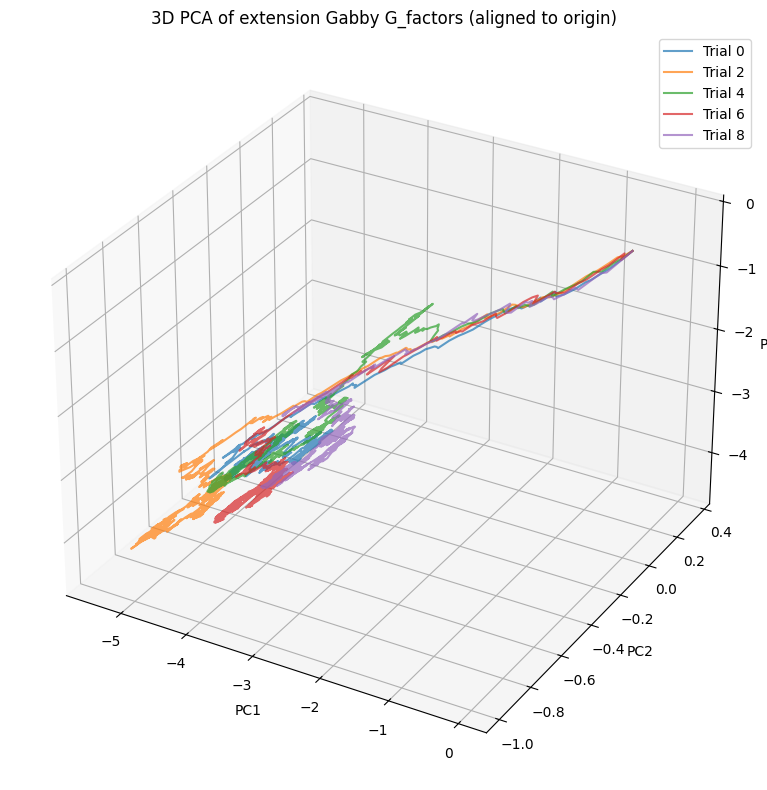

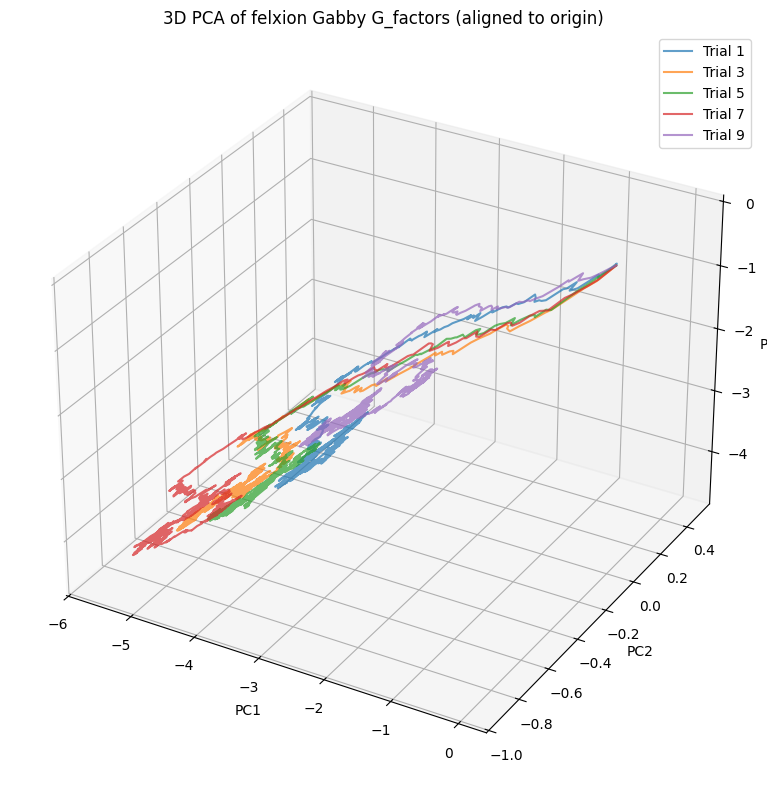

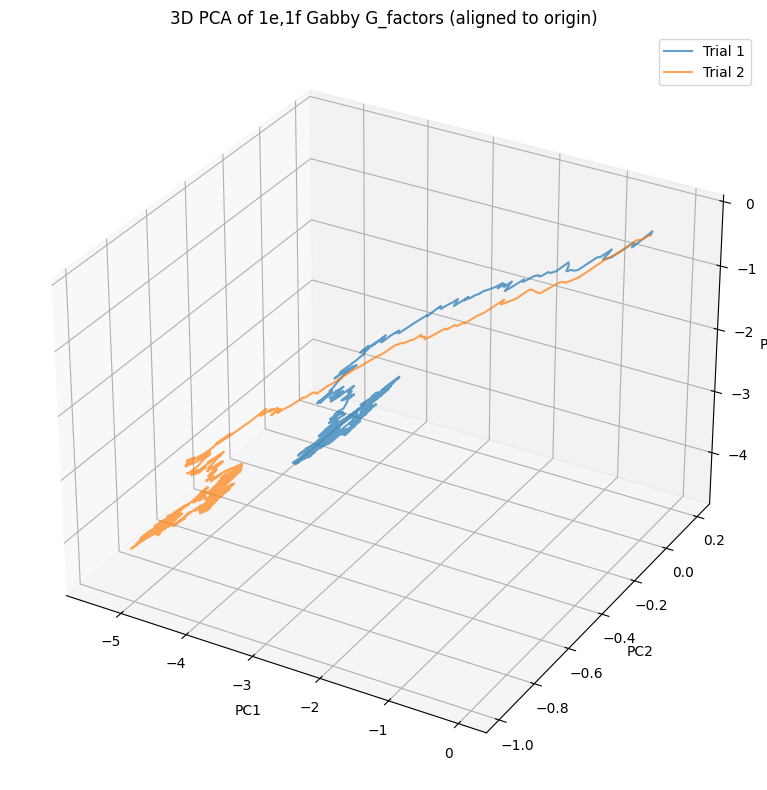

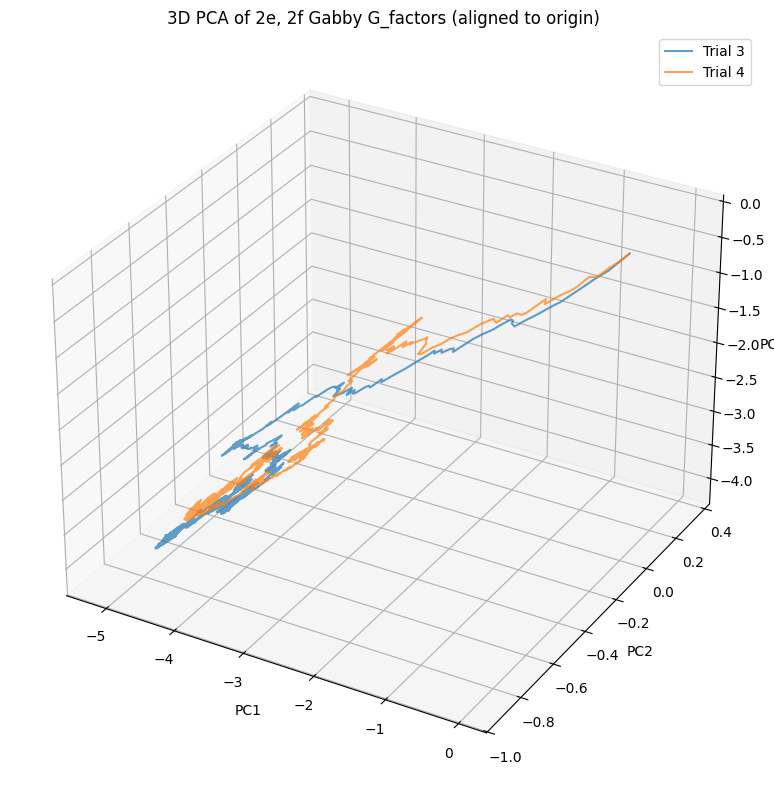

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convert to numpy and flatten across trials & time
factors_np = G_factors.detach().cpu().numpy()  # [B, T, F]
B, T, F = factors_np.shape
factors_flat = factors_np.reshape(-1, F)       # [B*T, F]

# Run PCA to 3 components
pca = PCA(n_components=3)
factors_pca_flat = pca.fit_transform(factors_flat)  # [B*T, 3]
factors_pca = factors_pca_flat.reshape(B, T, 3)     # [B, T, 3]

# Align each trajectory to origin (subtract first timepoint)
factors_pca -= factors_pca[:, 0:1, :]

# Plot selected trials in 3D
trials_to_plot = [0, 2, 4, 6, 8]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for idx in trials_to_plot:
    traj = factors_pca[idx]  # [T, 3]
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], alpha=0.7, label=f'Trial {idx}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of extension Gabby factors (aligned to origin)')
ax.legend()
plt.tight_layout()
plt.show()

# Plot selected trials in 3D
trials_to_plot = [1, 3, 5, 7, 9]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for idx in trials_to_plot:
    traj = factors_pca[idx]  # [T, 3]
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], alpha=0.7, label=f'Trial {idx}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of felxion Gabby factors (aligned to origin)')
ax.legend()
plt.tight_layout()
plt.show()


# Plot selected trials in 3D
trials_to_plot = [1,2]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for idx in trials_to_plot:
    traj = factors_pca[idx]  # [T, 3]
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], alpha=0.7, label=f'Trial {idx}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of 1e,1f Gabby factors (aligned to origin)')
ax.legend()
plt.tight_layout()
plt.show()

# Plot selected trials in 3D
trials_to_plot = [3,4]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for idx in trials_to_plot:
    traj = factors_pca[idx]  # [T, 3]
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], alpha=0.7, label=f'Trial {idx}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of 2e, 2f Gabby factors (aligned to origin)')
ax.legend()
plt.tight_layout()
plt.show()

Factors shape: torch.Size([12, 800, 15])
raw_output shape: tensor([[[ -4.8623,  -5.5062,  -5.3922,  ...,  -6.9933,  -9.3895, -11.4289],
         [ -4.8388,  -5.5065,  -5.3001,  ...,  -6.8304,  -9.3145, -11.3778],
         [ -4.7961,  -5.4776,  -5.2112,  ...,  -6.6832,  -9.2197, -11.2816],
         ...,
         [ -2.6599,  -3.4031,  -3.1181,  ...,  -3.0633,  -5.1077,  -6.2161],
         [ -2.6465,  -3.3885,  -3.0977,  ...,  -3.0440,  -5.0903,  -6.2057],
         [ -2.6429,  -3.3955,  -3.0948,  ...,  -3.0497,  -5.0634,  -6.2108]],

        [[ -4.3568,  -5.0647,  -4.8054,  ...,  -6.1774,  -7.9738,  -9.7728],
         [ -4.3523,  -5.0882,  -4.7346,  ...,  -6.0874,  -7.9500,  -9.8004],
         [ -4.3266,  -5.0690,  -4.6647,  ...,  -5.9973,  -7.9033,  -9.7471],
         ...,
         [ -2.6510,  -3.2526,  -2.9320,  ...,  -3.2690,  -4.7515,  -5.8249],
         [ -2.6491,  -3.2535,  -2.9289,  ...,  -3.2528,  -4.7279,  -5.8115],
         [ -2.6512,  -3.2651,  -2.9317,  ...,  -3.2579,  -4.7152

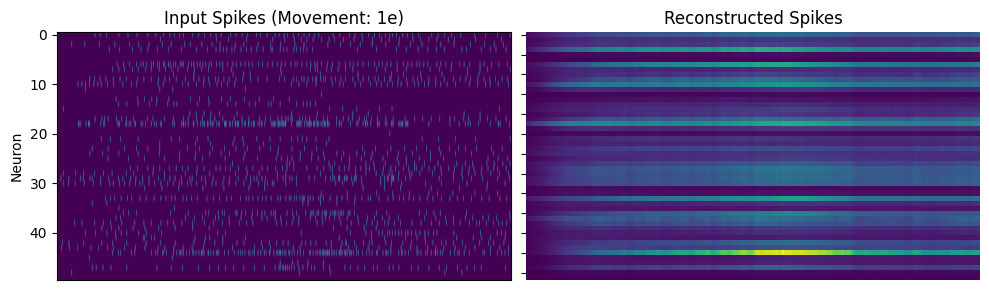

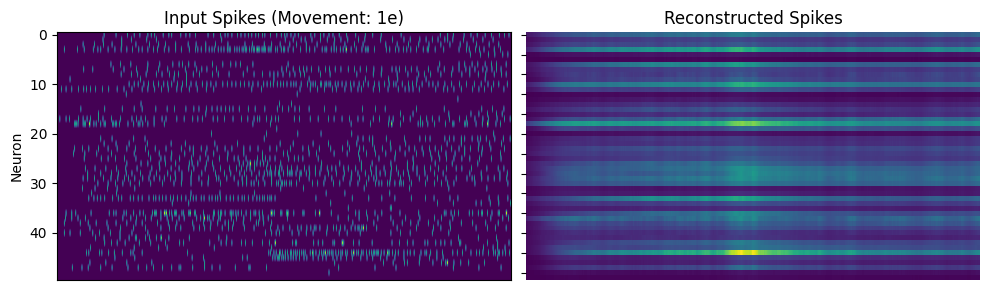

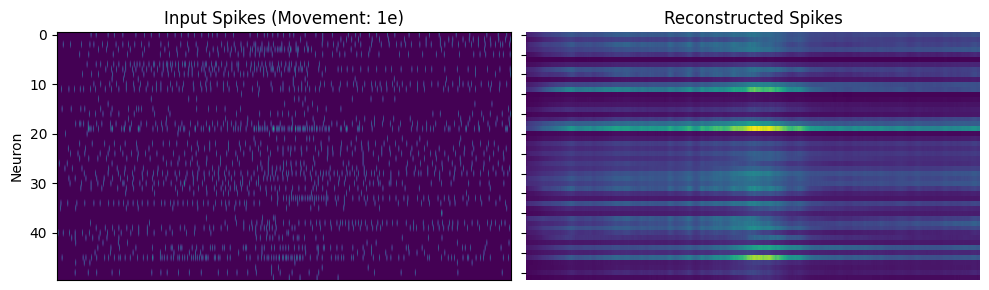

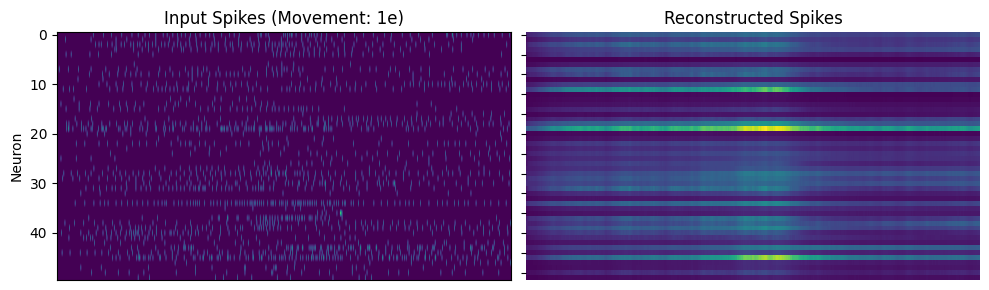

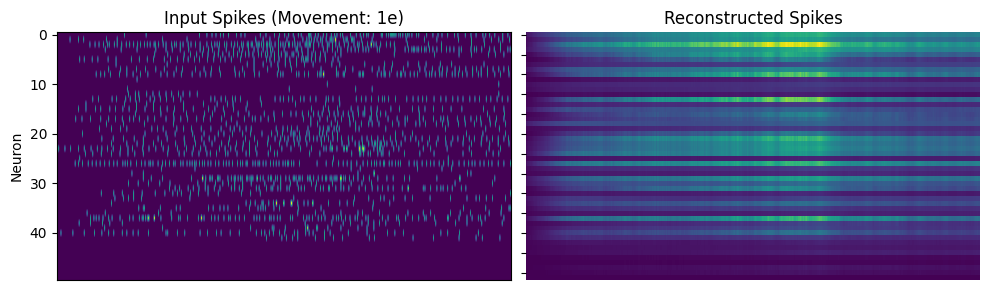

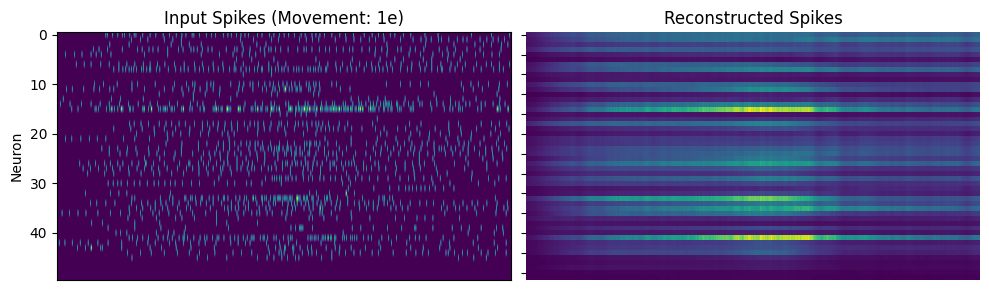

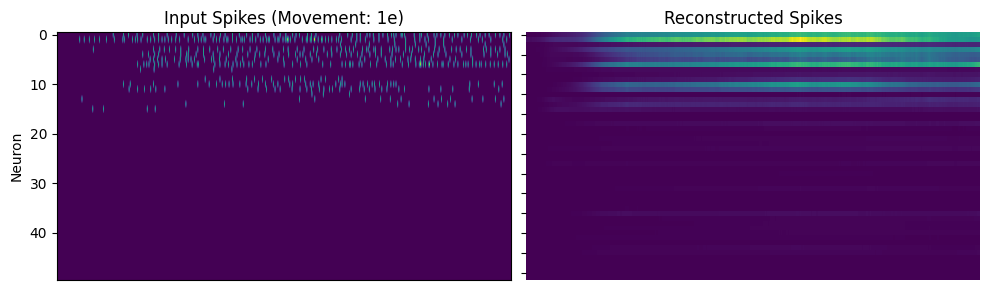

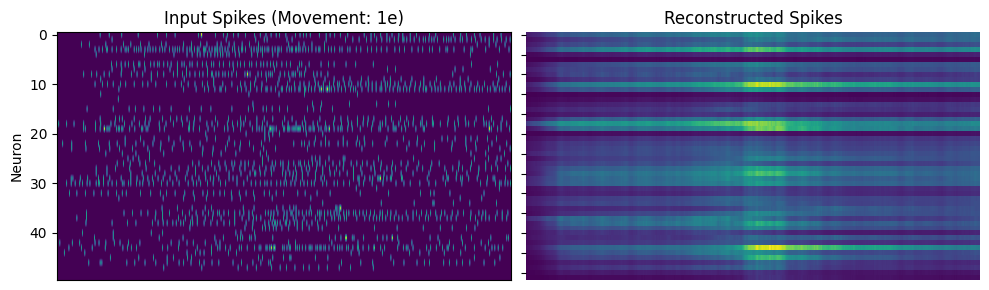

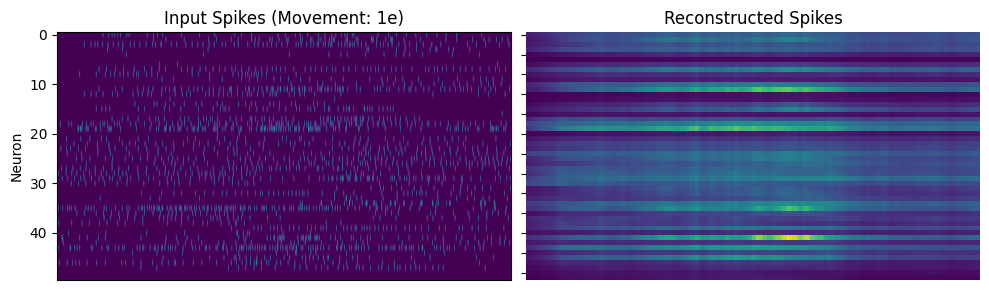

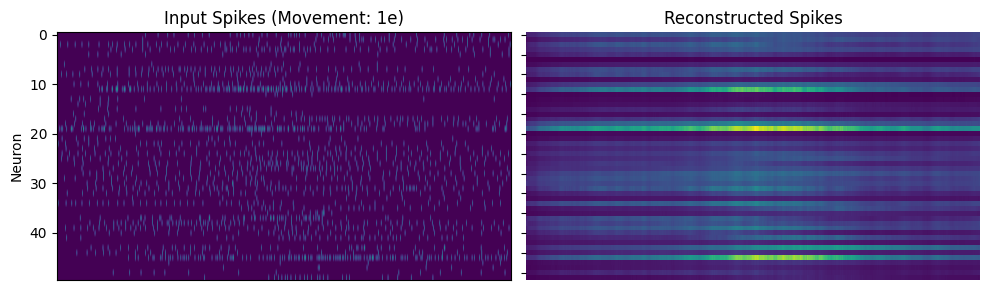

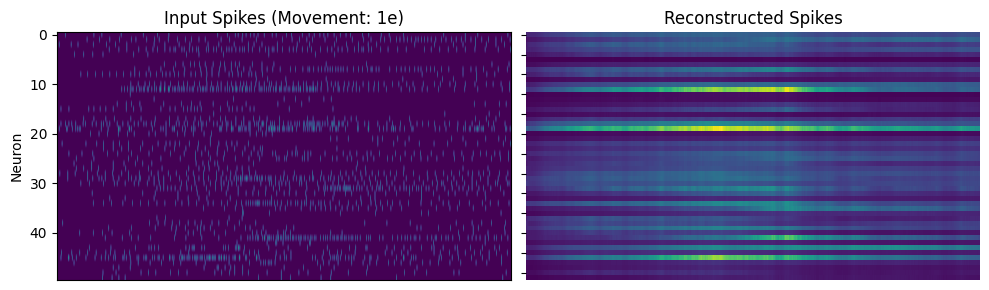

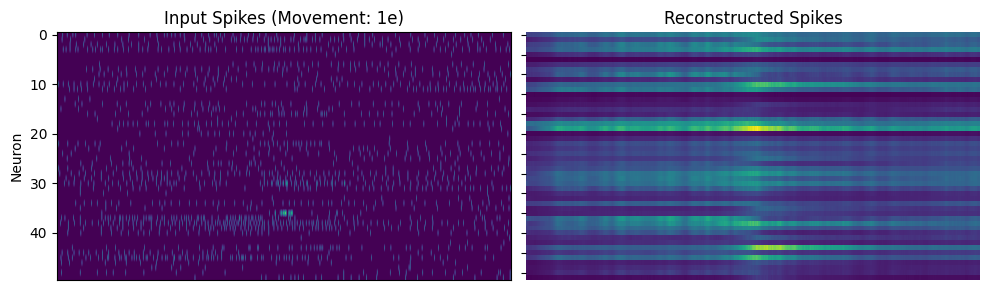

In [15]:
# try reconstracting the gabby data
x_input = torch.tensor(x_gabby_test[::50].transpose(0, 2, 1), dtype=torch.float32).cuda()  # shape [2, 800, 152]
gabby_model.eval()
with torch.no_grad():
    ic_mean, ic_std, ci = gabby_model.encoder(x_input)
    ic_post = gabby_model.ic_prior.make_posterior(ic_mean, ic_std)
    ic_sample = ic_post.rsample()

    # FIXED: [B, T, ext_input_dim] with ext_input_dim=0
    ext_input = torch.zeros(x_input.size(0), x_input.size(1), 0, device=x_input.device)

    # Run decoder
    _, _, _, _, _, _, G_factors = gabby_model.decoder(ic_sample, ci, ext_input)
    print(f"Factors shape: {G_factors.shape}")  # Should be [B, T, fac_dim]
    raw_output = gabby_model.readout[0](G_factors)
    print(f"raw_output shape: {raw_output}")
    # Convert to numpy and reshape
    recon_np = torch.exp(raw_output).cpu().numpy()  # EMG reconstruction [B, T, EMG]
    recon_np = np.transpose(recon_np, (0, 2, 1))
# [B, EMG, T]
x_input_np = x_input.cpu().numpy()  # [B, T, Neurons]
# [B, Neuron, T]
Y = y_test[:200]  # Ground truth EMG [B, EMG, T]
# [B, EMG, T]
# === Trials to plot
examples_to_plot = [0,1,2,3,4,5,6,7,8,9,10,11]
for i in examples_to_plot:
    fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharex=True)

    axs[0].imshow(x_input_np[i].T, aspect='auto', cmap='viridis')
    axs[0].set_title(f"Input Spikes (Movement: {movements[i//50]})")
    axs[0].set_ylabel("Neuron")
    axs[0].grid(False)

    # Reconstructed EMG
    sns.heatmap(recon_np[i], ax=axs[1], cmap='viridis', cbar=False)
    axs[1].set_title("Reconstructed Spikes")
    axs[1].set_yticklabels([])
    axs[1].set_xticks([])
    plt.tight_layout()
    plt.show()

In [16]:
# lets make a factor dataset
# chip Dataset - for training classifier
import numpy as np
import pickle


# === Dataset extractor that returns full factor sequence (no pooling)
def extract_factors_sequence(x_data, y_data,model, batch_size=64, deterministic=True):
    model.eval()
    X_f_seq = []
    Y_f_seq = []

    for i in tqdm(range(0, x_data.shape[0], batch_size)):
        x_batch = x_data[i:i + batch_size]  # [B, C, T]
        y_batch = y_data[i:i + batch_size]
        x_input = torch.tensor(x_batch.transpose(0, 2, 1), dtype=torch.float32).cuda()  # [B, T, C]

        with torch.no_grad():
            ic_mean, ic_std, ci = model.encoder(x_input)
            ic_post = model.ic_prior.make_posterior(ic_mean, ic_std)
            ic_sample = ic_post.mean if deterministic else ic_post.rsample()
            ext_input = torch.zeros(x_input.size(0), x_input.size(1), 0, device=x_input.device)
            _, _, _, _, _, _, factors = model.decoder(ic_sample, ci, ext_input)  # [B, T, F]

            X_f_seq.append(factors.cpu().numpy())  # [B, T, F]
            Y_f_seq.append(y_batch)

    return np.concatenate(X_f_seq), np.concatenate(Y_f_seq)

# === Extract full factor sequences
if not os.path.exists(r"G:\project\git\cross-subject-movement-decoding\datasets\lfads_factors\chip"):
    os.makedirs(r"G:\project\git\cross-subject-movement-decoding\datasets\lfads_factors\chip")
    
x_f_train, y_f_train = extract_factors_sequence(x, y , chip_model)
with open(r"G:\project\git\cross-subject-movement-decoding\datasets\lfads_factors\chip\lfads_factors_train.pkl", "wb") as f:
    pickle.dump((x_f_train, y_f_train), f)

x_f_val,   y_f_val   = extract_factors_sequence(x_val, y_val , chip_model)
with open(r"G:\project\git\cross-subject-movement-decoding\datasets\lfads_factors\chip\lfads_factors_val.pkl", "wb") as f:
    pickle.dump((x_f_val, y_f_val), f)

x_f_test,  y_f_test  = extract_factors_sequence(x_test, y_test , chip_model)
with open(r"G:\project\git\cross-subject-movement-decoding\datasets\lfads_factors\chip\lfads_factors_test.pkl", "wb") as f:
    pickle.dump((x_f_test, y_f_test), f)

print(f"Train: {x_f_train.shape}, Labels: {y_f_train.shape}")
print(f"Val:   {x_f_val.shape},   Labels: {y_f_val.shape}")
print(f"Test:  {x_f_test.shape},  Labels: {y_f_test.shape}")

# === Save to pickle


print("✅ Saved all factor sequences.")

# same for Gabby
# === Extract full factor sequences for Gabby
if not os.path.exists(r"G:\project\git\cross-subject-movement-decoding\datasets\lfads_factors\gabby"):
    os.makedirs(r"G:\project\git\cross-subject-movement-decoding\datasets\lfads_factors\gabby")

x_f_test_gabby, y_f_test_gabby = extract_factors_sequence(x_gabby_test, y_test , gabby_model)
with open(r"G:\project\git\cross-subject-movement-decoding\datasets\lfads_factors\gabby\lfads_factors_train.pkl", "wb") as f:
    pickle.dump((x_f_test_gabby, y_f_test_gabby), f)

100%|██████████| 94/94 [03:14<00:00,  2.06s/it]

100%|██████████| 10/10 [00:20<00:00,  2.02s/it]



Train: (6000, 800, 15), Labels: (6000,)
Val:   (600, 800, 15),   Labels: (600,)
Test:  (600, 800, 15),  Labels: (600,)
✅ Saved all factor sequences.


100%|██████████| 10/10 [00:20<00:00,  2.07s/it]



In [17]:
### lets build a classifier and train it on the C_factors to distinguish between movements
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class FactorClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FactorClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, output_dim)
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        # print(f"Input shape: {x.shape}")  # Debugging line
        x = self.leaky_relu(self.fc1(x))   # RuntimeError: mat1 and mat2 shapes cannot be multiplied (51200x15 and 800x128)
        # print(f"After fc1 shape: {x.shape}")  # Debugging line
        x = self.leaky_relu(self.fc2(x))
        # print(f"After fc2 shape: {x.shape}")  # Debugging line
        x = self.fc3(x)
        # print(f"Output shape: {x.shape}")
        return x
    
## data loader
class FactorDataset(torch.utils.data.Dataset):
    def __init__(self, factors, labels):
        self.factors = factors
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.factors[idx], self.labels[idx]
    
# load the factors dataset for Chip training
with open(r"..\datasets\lfads_factors\chip\lfads_factors_train.pkl", "rb") as f:
    x_f_train, y_f_train = pickle.load(f)
# load the factors dataset for Chip validation
with open(r"..\datasets\lfads_factors\chip\lfads_factors_val.pkl", "rb") as f:
    x_f_val, y_f_val = pickle.load(f)
# load the factors dataset for Chip test
with open(r"..\datasets\lfads_factors\chip\lfads_factors_test.pkl", "rb") as f:
    x_f_test, y_f_test = pickle.load(f)

# Create datasets
train_dataset = FactorDataset(x_f_train, y_f_train)
val_dataset = FactorDataset(x_f_val, y_f_val)
test_dataset = FactorDataset(x_f_test, y_f_test)
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# === Setup
chp_save = r'..\trained_cpts\lfads_classifier'
os.makedirs(chp_save, exist_ok=True)


# === Init
input_dim = x_f_train.shape[1] * x_f_train.shape[2]  # [B, T, F] -> T*F
hidden_dim = 256
output_dim = len(np.unique(y_f_train))

model = FactorClassifier(input_dim, hidden_dim, output_dim).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)  
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5)
# === Tracking
train_losses = []
val_losses = []
val_accs = []
best_val_loss = float("inf")
best_val_acc = 0.0

def evaluate(loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.cuda()
            y = y.long().cuda() 
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item() * x.size(0)
            correct += (outputs.argmax(1) == y).sum().item()
    avg_loss = total_loss / len(loader.dataset)
    acc = correct / len(loader.dataset)
    return avg_loss, acc

def plot_metrics(train_losses, val_losses, val_accs, path):
    fig, ax1 = plt.subplots()

    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(val_losses, label='Val Loss', color='orange')
    ax1.set_xlabel('Half Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(val_accs, label='Val Acc', color='green')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='upper right')

    plt.title('Loss and Accuracy')
    fig.tight_layout()
    plt.savefig(os.path.join(path, 'loss_acc_curve.png'))
    plt.close()


# === Training loop
num_epochs = 200
a = 0
log_interval = len(train_loader) 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (factors, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        factors = factors.cuda()
        labels = labels.long().cuda()
        optimizer.zero_grad()
        
        outputs = model(factors)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * factors.size(0)

        # === Mid-epoch validation
        if (batch_idx + 1) % log_interval == 0 or (batch_idx + 1) == len(train_loader):
            half_epoch = epoch + (batch_idx + 1) / len(train_loader)
            train_loss = running_loss / ((batch_idx + 1) * train_loader.batch_size)
            val_loss, val_acc = evaluate(val_loader)

            print(f"[{half_epoch:.2f} epochs] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            plot_metrics(train_losses, val_losses, val_accs, chp_save)      

            # Save best checkpoint
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                ckpt_path = os.path.join(chp_save, "best_model.pth")
                torch.save(model.state_dict(), ckpt_path)
                print(f"✅ Saved best checkpoint to {ckpt_path}")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                ckpt_path = os.path.join(chp_save, "best_acc_model.pth")
                torch.save(model.state_dict(), ckpt_path)
                print(f"✅ Saved best accuracy checkpoint to {ckpt_path}")
                
    # Update learning rate
    lr_scheduler.step(val_loss)
    print(f"Updated learning rate to {optimizer.param_groups[0]['lr']:.6f}")


Epoch 1:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 94/94 [00:00<00:00, 161.81it/s]


[1.00 epochs] Train Loss: 1.7482 | Val Loss: 1.4401 | Val Acc: 0.9200
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to ..\trained_cpts\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 2:  84%|████████▍ | 79/94 [00:00<00:00, 209.44it/s]

[2.00 epochs] Train Loss: 1.0962 | Val Loss: 1.0048 | Val Acc: 0.8817


Epoch 2: 100%|██████████| 94/94 [00:00<00:00, 130.04it/s]



✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 3:  77%|███████▋  | 72/94 [00:00<00:00, 234.68it/s]

[3.00 epochs] Train Loss: 0.7188 | Val Loss: 0.6999 | Val Acc: 0.9083


Epoch 3: 100%|██████████| 94/94 [00:00<00:00, 134.18it/s]



✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 4:  77%|███████▋  | 72/94 [00:00<00:00, 224.41it/s]

[4.00 epochs] Train Loss: 0.4883 | Val Loss: 0.5355 | Val Acc: 0.8483


Epoch 4: 100%|██████████| 94/94 [00:00<00:00, 119.57it/s]



✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 5:  80%|███████▉  | 75/94 [00:00<00:00, 234.18it/s]

[5.00 epochs] Train Loss: 0.3431 | Val Loss: 0.4228 | Val Acc: 0.9850


Epoch 5: 100%|██████████| 94/94 [00:00<00:00, 123.91it/s]



✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to ..\trained_cpts\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 6:  93%|█████████▎| 87/94 [00:00<00:00, 282.07it/s]

[6.00 epochs] Train Loss: 0.2498 | Val Loss: 0.3252 | Val Acc: 0.9883


Epoch 6: 100%|██████████| 94/94 [00:00<00:00, 136.60it/s]



✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to ..\trained_cpts\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 7:  90%|█████████ | 85/94 [00:00<00:00, 206.81it/s]

[7.00 epochs] Train Loss: 0.1910 | Val Loss: 0.2790 | Val Acc: 0.9883


Epoch 7: 100%|██████████| 94/94 [00:00<00:00, 128.35it/s]



✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 8:  78%|███████▊  | 73/94 [00:00<00:00, 236.84it/s]

[8.00 epochs] Train Loss: 0.1488 | Val Loss: 0.2345 | Val Acc: 0.9933


Epoch 8: 100%|██████████| 94/94 [00:00<00:00, 149.85it/s]



✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to ..\trained_cpts\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 9: 100%|██████████| 94/94 [00:00<00:00, 129.79it/s]


[9.00 epochs] Train Loss: 0.1196 | Val Loss: 0.2133 | Val Acc: 0.9900
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 10: 100%|██████████| 94/94 [00:00<00:00, 134.99it/s]


[10.00 epochs] Train Loss: 0.0978 | Val Loss: 0.1956 | Val Acc: 0.9900
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 11:  86%|████████▌ | 81/94 [00:00<00:00, 263.42it/s]

[11.00 epochs] Train Loss: 0.0821 | Val Loss: 0.1581 | Val Acc: 0.9933


Epoch 11: 100%|██████████| 94/94 [00:00<00:00, 156.56it/s]



✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 12: 100%|██████████| 94/94 [00:00<00:00, 145.44it/s]


[12.00 epochs] Train Loss: 0.0676 | Val Loss: 0.1471 | Val Acc: 0.9900
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 13:  96%|█████████▌| 90/94 [00:00<00:00, 280.96it/s]

[13.00 epochs] Train Loss: 0.0569 | Val Loss: 0.1412 | Val Acc: 0.9817


Epoch 13: 100%|██████████| 94/94 [00:00<00:00, 137.15it/s]



✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 14: 100%|██████████| 94/94 [00:00<00:00, 122.47it/s]


[14.00 epochs] Train Loss: 0.0475 | Val Loss: 0.1223 | Val Acc: 0.9900
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 15: 100%|██████████| 94/94 [00:00<00:00, 141.20it/s]


[15.00 epochs] Train Loss: 0.0402 | Val Loss: 0.1112 | Val Acc: 0.9900
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 16:  87%|████████▋ | 82/94 [00:00<00:00, 268.12it/s]

[16.00 epochs] Train Loss: 0.0347 | Val Loss: 0.1012 | Val Acc: 0.9917


Epoch 16: 100%|██████████| 94/94 [00:00<00:00, 144.55it/s]



✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 17:  98%|█████████▊| 92/94 [00:00<00:00, 227.74it/s]

[17.00 epochs] Train Loss: 0.0297 | Val Loss: 0.0988 | Val Acc: 0.9900


Epoch 17: 100%|██████████| 94/94 [00:00<00:00, 133.48it/s]



✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 18: 100%|██████████| 94/94 [00:00<00:00, 155.55it/s]


[18.00 epochs] Train Loss: 0.0258 | Val Loss: 0.0904 | Val Acc: 0.9900
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 19: 100%|██████████| 94/94 [00:00<00:00, 151.67it/s]


[19.00 epochs] Train Loss: 0.0225 | Val Loss: 0.0898 | Val Acc: 0.9883
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 20:  93%|█████████▎| 87/94 [00:00<00:00, 250.05it/s]

[20.00 epochs] Train Loss: 0.0198 | Val Loss: 0.0824 | Val Acc: 0.9917


Epoch 20: 100%|██████████| 94/94 [00:00<00:00, 141.33it/s]



✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 21:  98%|█████████▊| 92/94 [00:00<00:00, 229.52it/s]

[21.00 epochs] Train Loss: 0.0175 | Val Loss: 0.0750 | Val Acc: 0.9917


Epoch 21: 100%|██████████| 94/94 [00:00<00:00, 138.54it/s]



✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 22: 100%|██████████| 94/94 [00:00<00:00, 130.61it/s]

[22.00 epochs] Train Loss: 0.0156 | Val Loss: 0.0834 | Val Acc: 0.9883


Updated learning rate to 0.000010


Epoch 23: 100%|██████████| 94/94 [00:00<00:00, 149.93it/s]


[23.00 epochs] Train Loss: 0.0140 | Val Loss: 0.0670 | Val Acc: 0.9917
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 24:  98%|█████████▊| 92/94 [00:00<00:00, 195.75it/s]

[24.00 epochs] Train Loss: 0.0124 | Val Loss: 0.0744 | Val Acc: 0.9900


Epoch 24: 100%|██████████| 94/94 [00:00<00:00, 123.30it/s]



Updated learning rate to 0.000010


Epoch 25: 100%|██████████| 94/94 [00:00<00:00, 143.71it/s]

[25.00 epochs] Train Loss: 0.0110 | Val Loss: 0.0583 | Val Acc: 0.9933
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth


Updated learning rate to 0.000010


Epoch 26:  81%|████████  | 76/94 [00:00<00:00, 247.61it/s]

[26.00 epochs] Train Loss: 0.0101 | Val Loss: 0.0683 | Val Acc: 0.9900


Epoch 26: 100%|██████████| 94/94 [00:00<00:00, 109.08it/s]



Updated learning rate to 0.000010


Epoch 27: 100%|██████████| 94/94 [00:00<00:00, 163.20it/s]

[27.00 epochs] Train Loss: 0.0088 | Val Loss: 0.0595 | Val Acc: 0.9900


Updated learning rate to 0.000010


Epoch 28: 100%|██████████| 94/94 [00:00<00:00, 147.62it/s]


[28.00 epochs] Train Loss: 0.0079 | Val Loss: 0.0541 | Val Acc: 0.9933
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 29: 100%|██████████| 94/94 [00:00<00:00, 160.27it/s]


[29.00 epochs] Train Loss: 0.0072 | Val Loss: 0.0575 | Val Acc: 0.9900
Updated learning rate to 0.000010


Epoch 30: 100%|██████████| 94/94 [00:00<00:00, 180.02it/s]


[30.00 epochs] Train Loss: 0.0066 | Val Loss: 0.0525 | Val Acc: 0.9933
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 31:  68%|██████▊   | 64/94 [00:00<00:00, 309.76it/s]

[31.00 epochs] Train Loss: 0.0060 | Val Loss: 0.0595 | Val Acc: 0.9900


Epoch 31: 100%|██████████| 94/94 [00:00<00:00, 142.75it/s]



Updated learning rate to 0.000010


Epoch 32: 100%|██████████| 94/94 [00:00<00:00, 116.11it/s]

[32.00 epochs] Train Loss: 0.0055 | Val Loss: 0.0526 | Val Acc: 0.9917


Updated learning rate to 0.000010


Epoch 33: 100%|██████████| 94/94 [00:00<00:00, 141.33it/s]


[33.00 epochs] Train Loss: 0.0051 | Val Loss: 0.0503 | Val Acc: 0.9917
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 34: 100%|██████████| 94/94 [00:00<00:00, 165.05it/s]

[34.00 epochs] Train Loss: 0.0047 | Val Loss: 0.0518 | Val Acc: 0.9917


Updated learning rate to 0.000010


Epoch 35: 100%|██████████| 94/94 [00:00<00:00, 178.92it/s]


[35.00 epochs] Train Loss: 0.0043 | Val Loss: 0.0452 | Val Acc: 0.9933
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 36:  80%|███████▉  | 75/94 [00:00<00:00, 216.12it/s]

[36.00 epochs] Train Loss: 0.0040 | Val Loss: 0.0482 | Val Acc: 0.9917


Epoch 36: 100%|██████████| 94/94 [00:00<00:00, 126.25it/s]



Updated learning rate to 0.000010


Epoch 37: 100%|██████████| 94/94 [00:00<00:00, 125.96it/s]


[37.00 epochs] Train Loss: 0.0037 | Val Loss: 0.0496 | Val Acc: 0.9917
Updated learning rate to 0.000010


Epoch 38: 100%|██████████| 94/94 [00:00<00:00, 135.79it/s]


[38.00 epochs] Train Loss: 0.0034 | Val Loss: 0.0460 | Val Acc: 0.9917
Updated learning rate to 0.000010


Epoch 39:  77%|███████▋  | 72/94 [00:00<00:00, 238.53it/s]

[39.00 epochs] Train Loss: 0.0032 | Val Loss: 0.0418 | Val Acc: 0.9933


Epoch 39: 100%|██████████| 94/94 [00:00<00:00, 143.85it/s]



✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 40: 100%|██████████| 94/94 [00:00<00:00, 169.02it/s]


[40.00 epochs] Train Loss: 0.0030 | Val Loss: 0.0480 | Val Acc: 0.9900
Updated learning rate to 0.000010


Epoch 41: 100%|██████████| 94/94 [00:00<00:00, 156.61it/s]


[41.00 epochs] Train Loss: 0.0027 | Val Loss: 0.0437 | Val Acc: 0.9917
Updated learning rate to 0.000010


Epoch 42: 100%|██████████| 94/94 [00:00<00:00, 121.73it/s]


[42.00 epochs] Train Loss: 0.0026 | Val Loss: 0.0380 | Val Acc: 0.9933
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 43: 100%|██████████| 94/94 [00:00<00:00, 134.40it/s]

[43.00 epochs] Train Loss: 0.0024 | Val Loss: 0.0461 | Val Acc: 0.9900


Updated learning rate to 0.000010


Epoch 44: 100%|██████████| 94/94 [00:00<00:00, 178.87it/s]


[44.00 epochs] Train Loss: 0.0022 | Val Loss: 0.0372 | Val Acc: 0.9933
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 45: 100%|██████████| 94/94 [00:00<00:00, 197.45it/s]


[45.00 epochs] Train Loss: 0.0021 | Val Loss: 0.0371 | Val Acc: 0.9933
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 46: 100%|██████████| 94/94 [00:00<00:00, 151.71it/s]


[46.00 epochs] Train Loss: 0.0019 | Val Loss: 0.0418 | Val Acc: 0.9900
Updated learning rate to 0.000010


Epoch 47: 100%|██████████| 94/94 [00:00<00:00, 141.19it/s]

[47.00 epochs] Train Loss: 0.0018 | Val Loss: 0.0429 | Val Acc: 0.9900


Updated learning rate to 0.000010


Epoch 48:  82%|████████▏ | 77/94 [00:00<00:00, 247.13it/s]

[48.00 epochs] Train Loss: 0.0016 | Val Loss: 0.0392 | Val Acc: 0.9917


Epoch 48: 100%|██████████| 94/94 [00:00<00:00, 142.73it/s]



Updated learning rate to 0.000010


Epoch 49: 100%|██████████| 94/94 [00:00<00:00, 132.18it/s]


[49.00 epochs] Train Loss: 0.0015 | Val Loss: 0.0361 | Val Acc: 0.9917
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 50:  97%|█████████▋| 91/94 [00:00<00:00, 297.27it/s]

[50.00 epochs] Train Loss: 0.0014 | Val Loss: 0.0458 | Val Acc: 0.9900


Epoch 50: 100%|██████████| 94/94 [00:00<00:00, 155.75it/s]



Updated learning rate to 0.000010


Epoch 51: 100%|██████████| 94/94 [00:00<00:00, 155.82it/s]


[51.00 epochs] Train Loss: 0.0013 | Val Loss: 0.0348 | Val Acc: 0.9917
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 52: 100%|██████████| 94/94 [00:00<00:00, 141.11it/s]

[52.00 epochs] Train Loss: 0.0013 | Val Loss: 0.0362 | Val Acc: 0.9917


Updated learning rate to 0.000010


Epoch 53:  84%|████████▍ | 79/94 [00:00<00:00, 190.87it/s]

[53.00 epochs] Train Loss: 0.0012 | Val Loss: 0.0346 | Val Acc: 0.9917


Epoch 53: 100%|██████████| 94/94 [00:00<00:00, 120.55it/s]



✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 54: 100%|██████████| 94/94 [00:00<00:00, 105.71it/s]

[54.00 epochs] Train Loss: 0.0011 | Val Loss: 0.0361 | Val Acc: 0.9917


Updated learning rate to 0.000010


Epoch 55:  83%|████████▎ | 78/94 [00:00<00:00, 255.58it/s]

[55.00 epochs] Train Loss: 0.0011 | Val Loss: 0.0401 | Val Acc: 0.9900


Epoch 55: 100%|██████████| 94/94 [00:00<00:00, 154.19it/s]



Updated learning rate to 0.000010


Epoch 56:  94%|█████████▎| 88/94 [00:00<00:00, 171.70it/s]

[56.00 epochs] Train Loss: 0.0010 | Val Loss: 0.0317 | Val Acc: 0.9917


Epoch 56: 100%|██████████| 94/94 [00:00<00:00, 107.85it/s]



✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 57:  99%|█████████▉| 93/94 [00:00<00:00, 213.24it/s]

[57.00 epochs] Train Loss: 0.0009 | Val Loss: 0.0359 | Val Acc: 0.9900


Epoch 57: 100%|██████████| 94/94 [00:00<00:00, 131.66it/s]



Updated learning rate to 0.000010


Epoch 58: 100%|██████████| 94/94 [00:00<00:00, 144.85it/s]


[58.00 epochs] Train Loss: 0.0009 | Val Loss: 0.0327 | Val Acc: 0.9917
Updated learning rate to 0.000010


Epoch 59: 100%|██████████| 94/94 [00:00<00:00, 136.91it/s]


[59.00 epochs] Train Loss: 0.0008 | Val Loss: 0.0338 | Val Acc: 0.9917
Updated learning rate to 0.000010


Epoch 60:  95%|█████████▍| 89/94 [00:00<00:00, 228.53it/s]

[60.00 epochs] Train Loss: 0.0008 | Val Loss: 0.0311 | Val Acc: 0.9917


Epoch 60: 100%|██████████| 94/94 [00:00<00:00, 131.05it/s]



✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 61: 100%|██████████| 94/94 [00:00<00:00, 165.09it/s]


[61.00 epochs] Train Loss: 0.0007 | Val Loss: 0.0321 | Val Acc: 0.9917
Updated learning rate to 0.000010


Epoch 62: 100%|██████████| 94/94 [00:00<00:00, 143.41it/s]


[62.00 epochs] Train Loss: 0.0007 | Val Loss: 0.0306 | Val Acc: 0.9917
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 63: 100%|██████████| 94/94 [00:00<00:00, 137.22it/s]


[63.00 epochs] Train Loss: 0.0007 | Val Loss: 0.0340 | Val Acc: 0.9900
Updated learning rate to 0.000010


Epoch 64: 100%|██████████| 94/94 [00:00<00:00, 147.22it/s]

[64.00 epochs] Train Loss: 0.0006 | Val Loss: 0.0347 | Val Acc: 0.9917


Updated learning rate to 0.000010


Epoch 65:  78%|███████▊  | 73/94 [00:00<00:00, 251.06it/s]

[65.00 epochs] Train Loss: 0.0006 | Val Loss: 0.0265 | Val Acc: 0.9933


Epoch 65: 100%|██████████| 94/94 [00:00<00:00, 151.78it/s]



✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000010


Epoch 66: 100%|██████████| 94/94 [00:00<00:00, 184.98it/s]


[66.00 epochs] Train Loss: 0.0005 | Val Loss: 0.0287 | Val Acc: 0.9917
Updated learning rate to 0.000010


Epoch 67: 100%|██████████| 94/94 [00:00<00:00, 147.80it/s]


[67.00 epochs] Train Loss: 0.0005 | Val Loss: 0.0298 | Val Acc: 0.9917
Updated learning rate to 0.000010


Epoch 68:  88%|████████▊ | 83/94 [00:00<00:00, 234.98it/s]

[68.00 epochs] Train Loss: 0.0005 | Val Loss: 0.0312 | Val Acc: 0.9917


Epoch 68: 100%|██████████| 94/94 [00:00<00:00, 146.78it/s]



Updated learning rate to 0.000010


Epoch 69: 100%|██████████| 94/94 [00:00<00:00, 175.11it/s]


[69.00 epochs] Train Loss: 0.0005 | Val Loss: 0.0225 | Val Acc: 0.9950
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
✅ Saved best accuracy checkpoint to ..\trained_cpts\lfads_classifier\best_acc_model.pth
Updated learning rate to 0.000010


Epoch 70: 100%|██████████| 94/94 [00:00<00:00, 197.61it/s]


[70.00 epochs] Train Loss: 0.0004 | Val Loss: 0.0264 | Val Acc: 0.9933
Updated learning rate to 0.000010


Epoch 71: 100%|██████████| 94/94 [00:00<00:00, 174.02it/s]


[71.00 epochs] Train Loss: 0.0004 | Val Loss: 0.0315 | Val Acc: 0.9917
Updated learning rate to 0.000010


Epoch 72:  91%|█████████▏| 86/94 [00:00<00:00, 235.34it/s]

[72.00 epochs] Train Loss: 0.0004 | Val Loss: 0.0318 | Val Acc: 0.9917


Epoch 72: 100%|██████████| 94/94 [00:00<00:00, 139.56it/s]



Updated learning rate to 0.000010


Epoch 73:  88%|████████▊ | 83/94 [00:00<00:00, 279.07it/s]

[73.00 epochs] Train Loss: 0.0004 | Val Loss: 0.0227 | Val Acc: 0.9933


Epoch 73: 100%|██████████| 94/94 [00:00<00:00, 157.76it/s]



Updated learning rate to 0.000010


Epoch 74: 100%|██████████| 94/94 [00:00<00:00, 179.75it/s]


[74.00 epochs] Train Loss: 0.0003 | Val Loss: 0.0310 | Val Acc: 0.9917
Updated learning rate to 0.000010


Epoch 75: 100%|██████████| 94/94 [00:00<00:00, 180.98it/s]


[75.00 epochs] Train Loss: 0.0003 | Val Loss: 0.0273 | Val Acc: 0.9917
Updated learning rate to 0.000008


Epoch 76: 100%|██████████| 94/94 [00:00<00:00, 159.54it/s]


[76.00 epochs] Train Loss: 0.0003 | Val Loss: 0.0297 | Val Acc: 0.9917
Updated learning rate to 0.000008


Epoch 77: 100%|██████████| 94/94 [00:00<00:00, 124.05it/s]

[77.00 epochs] Train Loss: 0.0003 | Val Loss: 0.0345 | Val Acc: 0.9900


Epoch 77: 100%|██████████| 94/94 [00:00<00:00, 145.66it/s]



Updated learning rate to 0.000008


Epoch 78: 100%|██████████| 94/94 [00:00<00:00, 144.54it/s]

[78.00 epochs] Train Loss: 0.0003 | Val Loss: 0.0268 | Val Acc: 0.9917


Updated learning rate to 0.000008


Epoch 79: 100%|██████████| 94/94 [00:00<00:00, 173.46it/s]


[79.00 epochs] Train Loss: 0.0003 | Val Loss: 0.0290 | Val Acc: 0.9917
Updated learning rate to 0.000008


Epoch 80: 100%|██████████| 94/94 [00:00<00:00, 208.51it/s]


[80.00 epochs] Train Loss: 0.0002 | Val Loss: 0.0292 | Val Acc: 0.9917
Updated learning rate to 0.000008


Epoch 81:  74%|███████▍  | 70/94 [00:00<00:00, 334.70it/s]

[81.00 epochs] Train Loss: 0.0002 | Val Loss: 0.0315 | Val Acc: 0.9900


Epoch 81: 100%|██████████| 94/94 [00:00<00:00, 160.92it/s]



Updated learning rate to 0.000006


Epoch 82: 100%|██████████| 94/94 [00:00<00:00, 158.52it/s]


[82.00 epochs] Train Loss: 0.0002 | Val Loss: 0.0260 | Val Acc: 0.9917
Updated learning rate to 0.000006


Epoch 83: 100%|██████████| 94/94 [00:00<00:00, 145.86it/s]


[83.00 epochs] Train Loss: 0.0002 | Val Loss: 0.0308 | Val Acc: 0.9917
Updated learning rate to 0.000006


Epoch 84: 100%|██████████| 94/94 [00:00<00:00, 126.33it/s]


[84.00 epochs] Train Loss: 0.0002 | Val Loss: 0.0299 | Val Acc: 0.9917
Updated learning rate to 0.000006


Epoch 85:  77%|███████▋  | 72/94 [00:00<00:00, 241.81it/s]

[85.00 epochs] Train Loss: 0.0002 | Val Loss: 0.0252 | Val Acc: 0.9917


Epoch 85: 100%|██████████| 94/94 [00:00<00:00, 139.72it/s]



Updated learning rate to 0.000006


Epoch 86:  85%|████████▌ | 80/94 [00:00<00:00, 267.91it/s]

[86.00 epochs] Train Loss: 0.0002 | Val Loss: 0.0289 | Val Acc: 0.9917


Epoch 86: 100%|██████████| 94/94 [00:00<00:00, 151.63it/s]



Updated learning rate to 0.000006


Epoch 87:  97%|█████████▋| 91/94 [00:00<00:00, 203.49it/s]

[87.00 epochs] Train Loss: 0.0002 | Val Loss: 0.0273 | Val Acc: 0.9917


Epoch 87: 100%|██████████| 94/94 [00:00<00:00, 138.26it/s]



Updated learning rate to 0.000005


Epoch 88:  99%|█████████▉| 93/94 [00:00<00:00, 189.59it/s]

[88.00 epochs] Train Loss: 0.0002 | Val Loss: 0.0289 | Val Acc: 0.9917


Epoch 88: 100%|██████████| 94/94 [00:01<00:00, 90.97it/s] 



Updated learning rate to 0.000005


Epoch 89: 100%|██████████| 94/94 [00:00<00:00, 146.39it/s]


[89.00 epochs] Train Loss: 0.0002 | Val Loss: 0.0230 | Val Acc: 0.9917
Updated learning rate to 0.000005


Epoch 90: 100%|██████████| 94/94 [00:00<00:00, 177.57it/s]


[90.00 epochs] Train Loss: 0.0002 | Val Loss: 0.0278 | Val Acc: 0.9917
Updated learning rate to 0.000005


Epoch 91: 100%|██████████| 94/94 [00:00<00:00, 152.14it/s]


[91.00 epochs] Train Loss: 0.0002 | Val Loss: 0.0260 | Val Acc: 0.9917
Updated learning rate to 0.000005


Epoch 92: 100%|██████████| 94/94 [00:00<00:00, 158.19it/s]


[92.00 epochs] Train Loss: 0.0002 | Val Loss: 0.0308 | Val Acc: 0.9900
Updated learning rate to 0.000005


Epoch 93:  93%|█████████▎| 87/94 [00:00<00:00, 207.68it/s]

[93.00 epochs] Train Loss: 0.0002 | Val Loss: 0.0246 | Val Acc: 0.9917


Epoch 93: 100%|██████████| 94/94 [00:00<00:00, 136.86it/s]



Updated learning rate to 0.000004


Epoch 94:  95%|█████████▍| 89/94 [00:00<00:00, 296.18it/s]

[94.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0218 | Val Acc: 0.9933


Epoch 94: 100%|██████████| 94/94 [00:00<00:00, 166.32it/s]



✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000004


Epoch 95: 100%|██████████| 94/94 [00:00<00:00, 178.11it/s]


[95.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0254 | Val Acc: 0.9917
Updated learning rate to 0.000004


Epoch 96:  86%|████████▌ | 81/94 [00:00<00:00, 198.19it/s]

[96.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0274 | Val Acc: 0.9917


Epoch 96: 100%|██████████| 94/94 [00:00<00:00, 128.28it/s]



Updated learning rate to 0.000004


Epoch 97: 100%|██████████| 94/94 [00:00<00:00, 143.02it/s]


[97.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0240 | Val Acc: 0.9917
Updated learning rate to 0.000004


Epoch 98: 100%|██████████| 94/94 [00:00<00:00, 183.92it/s]


[98.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0260 | Val Acc: 0.9917
Updated learning rate to 0.000004


Epoch 99: 100%|██████████| 94/94 [00:00<00:00, 146.73it/s]

[99.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0238 | Val Acc: 0.9917


Updated learning rate to 0.000004


Epoch 100: 100%|██████████| 94/94 [00:00<00:00, 174.12it/s]


[100.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0225 | Val Acc: 0.9917
Updated learning rate to 0.000003


Epoch 101:  89%|████████▉ | 84/94 [00:00<00:00, 262.00it/s]

[101.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0245 | Val Acc: 0.9917


Epoch 101: 100%|██████████| 94/94 [00:00<00:00, 147.61it/s]



Updated learning rate to 0.000003


Epoch 102:  87%|████████▋ | 82/94 [00:00<00:00, 192.01it/s]

[102.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0241 | Val Acc: 0.9917


Epoch 102: 100%|██████████| 94/94 [00:00<00:00, 112.79it/s]



Updated learning rate to 0.000003


Epoch 103: 100%|██████████| 94/94 [00:00<00:00, 144.73it/s]


[103.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0294 | Val Acc: 0.9900
Updated learning rate to 0.000003


Epoch 104: 100%|██████████| 94/94 [00:00<00:00, 127.57it/s]

[104.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0310 | Val Acc: 0.9900


Epoch 104: 100%|██████████| 94/94 [00:00<00:00, 147.98it/s]



Updated learning rate to 0.000003


Epoch 105: 100%|██████████| 94/94 [00:00<00:00, 152.33it/s]


[105.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0241 | Val Acc: 0.9917
Updated learning rate to 0.000003


Epoch 106:  93%|█████████▎| 87/94 [00:00<00:00, 221.86it/s]

[106.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0227 | Val Acc: 0.9917


Epoch 106: 100%|██████████| 94/94 [00:00<00:00, 134.94it/s]



Updated learning rate to 0.000003


Epoch 107:  94%|█████████▎| 88/94 [00:00<00:00, 197.77it/s]

[107.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0214 | Val Acc: 0.9933


Epoch 107: 100%|██████████| 94/94 [00:00<00:00, 129.05it/s]



✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000003


Epoch 108: 100%|██████████| 94/94 [00:00<00:00, 161.72it/s]


[108.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0224 | Val Acc: 0.9917
Updated learning rate to 0.000003


Epoch 109: 100%|██████████| 94/94 [00:00<00:00, 137.62it/s]

[109.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0266 | Val Acc: 0.9917


Updated learning rate to 0.000003


Epoch 110: 100%|██████████| 94/94 [00:00<00:00, 187.57it/s]


[110.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0242 | Val Acc: 0.9917
Updated learning rate to 0.000003


Epoch 111: 100%|██████████| 94/94 [00:00<00:00, 166.50it/s]

[111.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0258 | Val Acc: 0.9917


Updated learning rate to 0.000003


Epoch 112:  94%|█████████▎| 88/94 [00:00<00:00, 212.57it/s]

[112.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0266 | Val Acc: 0.9917


Epoch 112: 100%|██████████| 94/94 [00:00<00:00, 134.08it/s]



Updated learning rate to 0.000003


Epoch 113: 100%|██████████| 94/94 [00:00<00:00, 170.82it/s]


[113.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0266 | Val Acc: 0.9917
Updated learning rate to 0.000002


Epoch 114: 100%|██████████| 94/94 [00:00<00:00, 155.04it/s]


[114.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0215 | Val Acc: 0.9917
Updated learning rate to 0.000002


Epoch 115: 100%|██████████| 94/94 [00:00<00:00, 152.93it/s]


[115.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0249 | Val Acc: 0.9917
Updated learning rate to 0.000002


Epoch 116: 100%|██████████| 94/94 [00:00<00:00, 205.29it/s]


[116.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0248 | Val Acc: 0.9917
Updated learning rate to 0.000002


Epoch 117: 100%|██████████| 94/94 [00:00<00:00, 151.89it/s]

[117.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0222 | Val Acc: 0.9917


Updated learning rate to 0.000002


Epoch 118: 100%|██████████| 94/94 [00:00<00:00, 154.25it/s]


[118.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0238 | Val Acc: 0.9917
Updated learning rate to 0.000002


Epoch 119: 100%|██████████| 94/94 [00:00<00:00, 147.87it/s]


[119.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0280 | Val Acc: 0.9917
Updated learning rate to 0.000002


Epoch 120: 100%|██████████| 94/94 [00:00<00:00, 131.24it/s]


[120.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0236 | Val Acc: 0.9917
Updated learning rate to 0.000002


Epoch 121: 100%|██████████| 94/94 [00:00<00:00, 174.71it/s]


[121.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0242 | Val Acc: 0.9917
Updated learning rate to 0.000002


Epoch 122: 100%|██████████| 94/94 [00:00<00:00, 143.72it/s]

[122.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0236 | Val Acc: 0.9917


Updated learning rate to 0.000002


Epoch 123:  93%|█████████▎| 87/94 [00:00<00:00, 205.41it/s]

[123.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0248 | Val Acc: 0.9917


Epoch 123: 100%|██████████| 94/94 [00:00<00:00, 123.95it/s]



Updated learning rate to 0.000002


Epoch 124:  83%|████████▎ | 78/94 [00:00<00:00, 174.42it/s]

[124.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0218 | Val Acc: 0.9917


Epoch 124: 100%|██████████| 94/94 [00:00<00:00, 124.16it/s]



Updated learning rate to 0.000002


Epoch 125:  97%|█████████▋| 91/94 [00:00<00:00, 179.35it/s]

[125.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0215 | Val Acc: 0.9917


Epoch 125: 100%|██████████| 94/94 [00:00<00:00, 119.84it/s]



Updated learning rate to 0.000001


Epoch 126: 100%|██████████| 94/94 [00:00<00:00, 144.99it/s]


[126.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0241 | Val Acc: 0.9917
Updated learning rate to 0.000001


Epoch 127: 100%|██████████| 94/94 [00:00<00:00, 151.82it/s]


[127.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0212 | Val Acc: 0.9917
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000001


Epoch 128: 100%|██████████| 94/94 [00:00<00:00, 130.10it/s]


[128.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0251 | Val Acc: 0.9917
Updated learning rate to 0.000001


Epoch 129: 100%|██████████| 94/94 [00:00<00:00, 119.08it/s]


[129.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0244 | Val Acc: 0.9917
Updated learning rate to 0.000001


Epoch 130:  83%|████████▎ | 78/94 [00:00<00:00, 168.04it/s]

[130.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0264 | Val Acc: 0.9917


Epoch 130: 100%|██████████| 94/94 [00:01<00:00, 90.94it/s] 



Updated learning rate to 0.000001


Epoch 131: 100%|██████████| 94/94 [00:00<00:00, 136.86it/s]

[131.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0255 | Val Acc: 0.9917


Updated learning rate to 0.000001


Epoch 132: 100%|██████████| 94/94 [00:00<00:00, 119.93it/s]

[132.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0210 | Val Acc: 0.9917
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth


Epoch 132: 100%|██████████| 94/94 [00:00<00:00, 140.77it/s]



Updated learning rate to 0.000001


Epoch 133:  93%|█████████▎| 87/94 [00:00<00:00, 207.20it/s]

[133.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0240 | Val Acc: 0.9917


Epoch 133: 100%|██████████| 94/94 [00:00<00:00, 137.81it/s]



Updated learning rate to 0.000001


Epoch 134: 100%|██████████| 94/94 [00:00<00:00, 136.62it/s]


[134.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0211 | Val Acc: 0.9917
Updated learning rate to 0.000001


Epoch 135: 100%|██████████| 94/94 [00:00<00:00, 126.87it/s]


[135.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0233 | Val Acc: 0.9917
Updated learning rate to 0.000001


Epoch 136:  94%|█████████▎| 88/94 [00:00<00:00, 221.37it/s]

[136.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0219 | Val Acc: 0.9917


Epoch 136: 100%|██████████| 94/94 [00:00<00:00, 141.52it/s]



Updated learning rate to 0.000001


Epoch 137: 100%|██████████| 94/94 [00:00<00:00, 140.70it/s]

[137.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0238 | Val Acc: 0.9917


Updated learning rate to 0.000001


Epoch 138: 100%|██████████| 94/94 [00:00<00:00, 195.30it/s]


[138.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0264 | Val Acc: 0.9917
Updated learning rate to 0.000001


Epoch 139: 100%|██████████| 94/94 [00:00<00:00, 191.10it/s]


[139.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0219 | Val Acc: 0.9917
Updated learning rate to 0.000001


Epoch 140:  79%|███████▊  | 74/94 [00:00<00:00, 205.38it/s]

[140.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0206 | Val Acc: 0.9917


Epoch 140: 100%|██████████| 94/94 [00:00<00:00, 129.88it/s]



✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000001


Epoch 141: 100%|██████████| 94/94 [00:00<00:00, 167.14it/s]


[141.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0228 | Val Acc: 0.9917
Updated learning rate to 0.000001


Epoch 142: 100%|██████████| 94/94 [00:00<00:00, 144.26it/s]


[142.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0216 | Val Acc: 0.9917
Updated learning rate to 0.000001


Epoch 143: 100%|██████████| 94/94 [00:00<00:00, 165.73it/s]


[143.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0208 | Val Acc: 0.9917
Updated learning rate to 0.000001


Epoch 144:  78%|███████▊  | 73/94 [00:00<00:00, 183.60it/s]

[144.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0227 | Val Acc: 0.9917


Epoch 144: 100%|██████████| 94/94 [00:00<00:00, 124.20it/s]


Updated learning rate to 0.000001


Epoch 145: 100%|██████████| 94/94 [00:00<00:00, 142.82it/s]


[145.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0205 | Val Acc: 0.9917
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000001


Epoch 146: 100%|██████████| 94/94 [00:00<00:00, 177.91it/s]


[146.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0201 | Val Acc: 0.9917
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000001


Epoch 147: 100%|██████████| 94/94 [00:00<00:00, 139.44it/s]

[147.00 epochs] Train Loss: 0.0001 | Val Loss: 0.0267 | Val Acc: 0.9917


Updated learning rate to 0.000001


Epoch 148:  94%|█████████▎| 88/94 [00:00<00:00, 211.53it/s]

[148.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0224 | Val Acc: 0.9917


Epoch 148: 100%|██████████| 94/94 [00:00<00:00, 127.92it/s]



Updated learning rate to 0.000001


Epoch 149: 100%|██████████| 94/94 [00:00<00:00, 109.72it/s]

[149.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0203 | Val Acc: 0.9917


Updated learning rate to 0.000001


Epoch 150: 100%|██████████| 94/94 [00:00<00:00, 133.24it/s]


[150.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0220 | Val Acc: 0.9917
Updated learning rate to 0.000001


Epoch 151:  91%|█████████▏| 86/94 [00:00<00:00, 163.80it/s]

[151.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0219 | Val Acc: 0.9917


Epoch 151: 100%|██████████| 94/94 [00:00<00:00, 107.44it/s]



Updated learning rate to 0.000001


Epoch 152:  90%|█████████ | 85/94 [00:00<00:00, 150.31it/s]

[152.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0228 | Val Acc: 0.9917


Epoch 152: 100%|██████████| 94/94 [00:00<00:00, 105.86it/s]



Updated learning rate to 0.000001


Epoch 153: 100%|██████████| 94/94 [00:00<00:00, 127.54it/s]

[153.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0229 | Val Acc: 0.9917


Updated learning rate to 0.000001


Epoch 154:  84%|████████▍ | 79/94 [00:00<00:00, 202.05it/s]

[154.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0194 | Val Acc: 0.9917


Epoch 154: 100%|██████████| 94/94 [00:00<00:00, 124.21it/s]



✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier\best_model.pth
Updated learning rate to 0.000001


Epoch 155: 100%|██████████| 94/94 [00:00<00:00, 136.68it/s]

[155.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0214 | Val Acc: 0.9917


Updated learning rate to 0.000001


Epoch 156:  87%|████████▋ | 82/94 [00:00<00:00, 179.51it/s]

[156.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0262 | Val Acc: 0.9917


Epoch 156: 100%|██████████| 94/94 [00:00<00:00, 121.65it/s]



Updated learning rate to 0.000001


Epoch 157: 100%|██████████| 94/94 [00:00<00:00, 86.95it/s] 

[157.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0241 | Val Acc: 0.9917


Epoch 157: 100%|██████████| 94/94 [00:00<00:00, 105.15it/s]



Updated learning rate to 0.000001


Epoch 158:  89%|████████▉ | 84/94 [00:00<00:00, 163.18it/s]

[158.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0208 | Val Acc: 0.9917


Epoch 158: 100%|██████████| 94/94 [00:00<00:00, 110.32it/s]



Updated learning rate to 0.000001


Epoch 159: 100%|██████████| 94/94 [00:00<00:00, 140.31it/s]


[159.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0208 | Val Acc: 0.9917
Updated learning rate to 0.000001


Epoch 160: 100%|██████████| 94/94 [00:00<00:00, 157.10it/s]

[160.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0209 | Val Acc: 0.9917


Updated learning rate to 0.000001


Epoch 161:  93%|█████████▎| 87/94 [00:00<00:00, 268.30it/s]

[161.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0213 | Val Acc: 0.9917


Epoch 161: 100%|██████████| 94/94 [00:00<00:00, 146.66it/s]



Updated learning rate to 0.000001


Epoch 162: 100%|██████████| 94/94 [00:00<00:00, 124.43it/s]

[162.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0205 | Val Acc: 0.9917


Updated learning rate to 0.000001


Epoch 163: 100%|██████████| 94/94 [00:00<00:00, 124.98it/s]

[163.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0211 | Val Acc: 0.9917


Updated learning rate to 0.000001


Epoch 164: 100%|██████████| 94/94 [00:00<00:00, 145.05it/s]


[164.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0236 | Val Acc: 0.9917
Updated learning rate to 0.000001


Epoch 165: 100%|██████████| 94/94 [00:00<00:00, 145.09it/s]


[165.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0237 | Val Acc: 0.9917
Updated learning rate to 0.000001


Epoch 166: 100%|██████████| 94/94 [00:00<00:00, 148.74it/s]


[166.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0238 | Val Acc: 0.9917
Updated learning rate to 0.000001


Epoch 167: 100%|██████████| 94/94 [00:00<00:00, 172.11it/s]


[167.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0204 | Val Acc: 0.9917
Updated learning rate to 0.000001


Epoch 168:  76%|███████▌  | 71/94 [00:00<00:00, 173.96it/s]

[168.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0237 | Val Acc: 0.9917


Epoch 168: 100%|██████████| 94/94 [00:00<00:00, 125.12it/s]


Updated learning rate to 0.000001


Epoch 169: 100%|██████████| 94/94 [00:00<00:00, 121.39it/s]

[169.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0217 | Val Acc: 0.9917


Updated learning rate to 0.000001


Epoch 170: 100%|██████████| 94/94 [00:00<00:00, 166.34it/s]


[170.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0195 | Val Acc: 0.9917
Updated learning rate to 0.000001


Epoch 171: 100%|██████████| 94/94 [00:00<00:00, 158.08it/s]


[171.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0215 | Val Acc: 0.9917
Updated learning rate to 0.000001


Epoch 172:  94%|█████████▎| 88/94 [00:00<00:00, 222.71it/s]

[172.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0212 | Val Acc: 0.9917


Epoch 172: 100%|██████████| 94/94 [00:00<00:00, 131.25it/s]



Updated learning rate to 0.000000


Epoch 173:  89%|████████▉ | 84/94 [00:00<00:00, 194.23it/s]

[173.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0221 | Val Acc: 0.9917


Epoch 173: 100%|██████████| 94/94 [00:00<00:00, 130.69it/s]



Updated learning rate to 0.000000


Epoch 174: 100%|██████████| 94/94 [00:00<00:00, 140.34it/s]


[174.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0215 | Val Acc: 0.9917
Updated learning rate to 0.000000


Epoch 175:  78%|███████▊  | 73/94 [00:00<00:00, 180.19it/s]

[175.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0207 | Val Acc: 0.9917


Epoch 175: 100%|██████████| 94/94 [00:00<00:00, 127.67it/s]


Updated learning rate to 0.000000


Epoch 176:  96%|█████████▌| 90/94 [00:00<00:00, 221.93it/s]

[176.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0209 | Val Acc: 0.9917


Epoch 176: 100%|██████████| 94/94 [00:00<00:00, 126.35it/s]



Updated learning rate to 0.000000


Epoch 177:  83%|████████▎ | 78/94 [00:00<00:00, 224.61it/s]

[177.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0234 | Val Acc: 0.9917


Epoch 177: 100%|██████████| 94/94 [00:00<00:00, 140.02it/s]



Updated learning rate to 0.000000


Epoch 178: 100%|██████████| 94/94 [00:00<00:00, 115.38it/s]


[178.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0229 | Val Acc: 0.9917
Updated learning rate to 0.000000


Epoch 179:  83%|████████▎ | 78/94 [00:00<00:00, 186.54it/s]

[179.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0214 | Val Acc: 0.9917


Epoch 179: 100%|██████████| 94/94 [00:00<00:00, 111.55it/s]



Updated learning rate to 0.000000


Epoch 180:  80%|███████▉  | 75/94 [00:00<00:00, 185.10it/s]

[180.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0212 | Val Acc: 0.9917


Epoch 180: 100%|██████████| 94/94 [00:00<00:00, 128.50it/s]


Updated learning rate to 0.000000


Epoch 181:  95%|█████████▍| 89/94 [00:00<00:00, 215.00it/s]

[181.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0215 | Val Acc: 0.9917


Epoch 181: 100%|██████████| 94/94 [00:01<00:00, 83.24it/s] 



Updated learning rate to 0.000000


Epoch 182:  90%|█████████ | 85/94 [00:00<00:00, 279.88it/s]

[182.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0217 | Val Acc: 0.9917


Epoch 182: 100%|██████████| 94/94 [00:00<00:00, 134.65it/s]



Updated learning rate to 0.000000


Epoch 183: 100%|██████████| 94/94 [00:00<00:00, 132.10it/s]


[183.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0215 | Val Acc: 0.9917
Updated learning rate to 0.000000


Epoch 184: 100%|██████████| 94/94 [00:00<00:00, 178.98it/s]


[184.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0206 | Val Acc: 0.9917
Updated learning rate to 0.000000


Epoch 185: 100%|██████████| 94/94 [00:00<00:00, 176.80it/s]


[185.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0221 | Val Acc: 0.9917
Updated learning rate to 0.000000


Epoch 186:  95%|█████████▍| 89/94 [00:00<00:00, 283.43it/s]

[186.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0210 | Val Acc: 0.9917


Epoch 186: 100%|██████████| 94/94 [00:00<00:00, 155.89it/s]



Updated learning rate to 0.000000


Epoch 187: 100%|██████████| 94/94 [00:00<00:00, 131.26it/s]

[187.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0201 | Val Acc: 0.9917


Updated learning rate to 0.000000


Epoch 188: 100%|██████████| 94/94 [00:00<00:00, 153.57it/s]


[188.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0211 | Val Acc: 0.9917
Updated learning rate to 0.000000


Epoch 189: 100%|██████████| 94/94 [00:00<00:00, 145.56it/s]


[189.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0210 | Val Acc: 0.9917
Updated learning rate to 0.000000


Epoch 190:  85%|████████▌ | 80/94 [00:00<00:00, 234.64it/s]

[190.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0205 | Val Acc: 0.9917


Epoch 190: 100%|██████████| 94/94 [00:00<00:00, 123.71it/s]



Updated learning rate to 0.000000


Epoch 191:  99%|█████████▉| 93/94 [00:00<00:00, 236.00it/s]

[191.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0212 | Val Acc: 0.9917


Epoch 191: 100%|██████████| 94/94 [00:00<00:00, 130.28it/s]



Updated learning rate to 0.000000


Epoch 192: 100%|██████████| 94/94 [00:00<00:00, 141.68it/s]


[192.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0217 | Val Acc: 0.9917
Updated learning rate to 0.000000


Epoch 193: 100%|██████████| 94/94 [00:00<00:00, 152.53it/s]

[193.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0219 | Val Acc: 0.9917


Updated learning rate to 0.000000


Epoch 194: 100%|██████████| 94/94 [00:00<00:00, 142.55it/s]


[194.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0213 | Val Acc: 0.9917
Updated learning rate to 0.000000


Epoch 195: 100%|██████████| 94/94 [00:00<00:00, 162.72it/s]


[195.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0202 | Val Acc: 0.9917
Updated learning rate to 0.000000


Epoch 196:  95%|█████████▍| 89/94 [00:00<00:00, 209.18it/s]

[196.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0216 | Val Acc: 0.9917


Epoch 196: 100%|██████████| 94/94 [00:00<00:00, 133.21it/s]



Updated learning rate to 0.000000


Epoch 197:  77%|███████▋  | 72/94 [00:00<00:00, 239.15it/s]

[197.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0213 | Val Acc: 0.9917


Epoch 197: 100%|██████████| 94/94 [00:00<00:00, 148.02it/s]



Updated learning rate to 0.000000


Epoch 198:  88%|████████▊ | 83/94 [00:00<00:00, 212.13it/s]

[198.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0212 | Val Acc: 0.9917


Epoch 198: 100%|██████████| 94/94 [00:00<00:00, 130.78it/s]



Updated learning rate to 0.000000


Epoch 199:  98%|█████████▊| 92/94 [00:00<00:00, 157.34it/s]

[199.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0214 | Val Acc: 0.9917


Epoch 199: 100%|██████████| 94/94 [00:00<00:00, 113.28it/s]



Updated learning rate to 0.000000


Epoch 200: 100%|██████████| 94/94 [00:00<00:00, 131.15it/s]

[200.00 epochs] Train Loss: 0.0000 | Val Loss: 0.0215 | Val Acc: 0.9917
Updated learning rate to 0.000000



Best Model Validation Loss: 0.0194 | Best Model Validation Acc: 0.9950



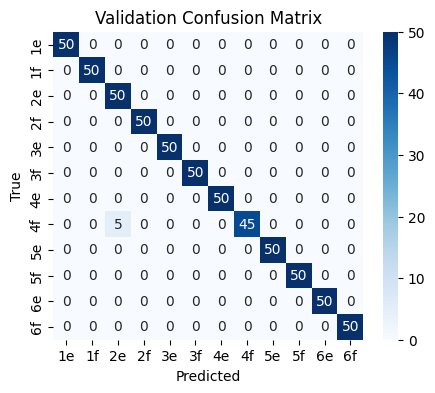

Test Loss: 0.0160 | Test Acc: 0.9983
✅ Saved final model to ..\trained_cpts\lfads_classifier\final_model.pth


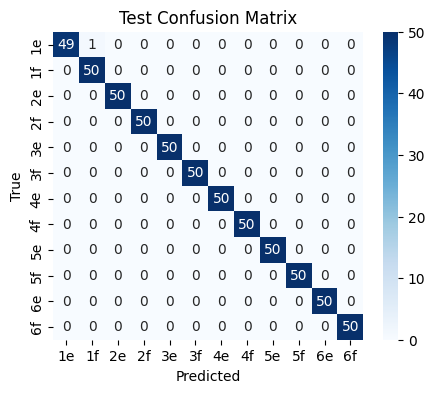


Best Accuracy Model


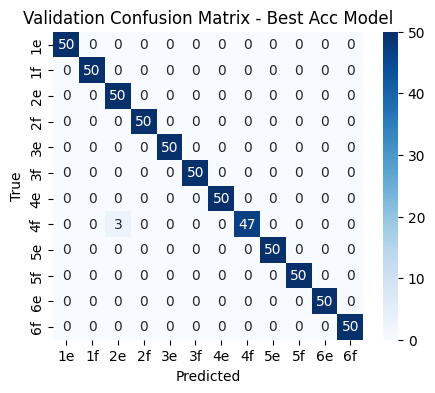

Val Loss: 0.0225 | Val Acc: 0.9950



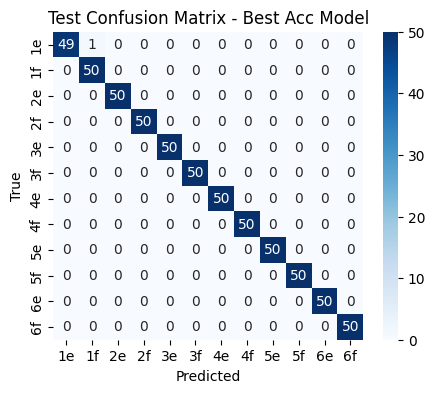

Test Loss: 0.0234 | Test Acc: 0.9983


In [20]:
# plot confusion matrix on validation set for 12 movements on best model
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# print in big letters - this is the LOSS best model
print("\n" + "="*50)
print(f"Best Model Validation Loss: {best_val_loss:.4f} | Best Model Validation Acc: {best_val_acc:.4f}")
print("="*50 + "\n")
# Load best model
model.load_state_dict(torch.load(os.path.join(chp_save, "best_model.pth")))
# Evaluate on validation set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in val_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Validation Confusion Matrix')
# Evaluate on test set
test_loss, test_acc = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
# Save final model
final_ckpt_path = os.path.join(chp_save, "final_model.pth")
torch.save(model.state_dict(), final_ckpt_path)
print(f"✅ Saved final model to {final_ckpt_path}")
# Plot confusion matrix on test set
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in test_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Test Confusion Matrix')

# now for the best accuracy model
print("\n" + "="*50)
print(f"Best Accuracy Model")
model.load_state_dict(torch.load(os.path.join(chp_save, "best_acc_model.pth")))
# Evaluate on validation set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in val_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Validation Confusion Matrix - Best Acc Model')
# Evaluate on test set
val_loss, val_acc = evaluate(val_loader)
print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
print()
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in test_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Test Confusion Matrix - Best Acc Model')
# Evaluate on test set
test_loss, test_acc = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")



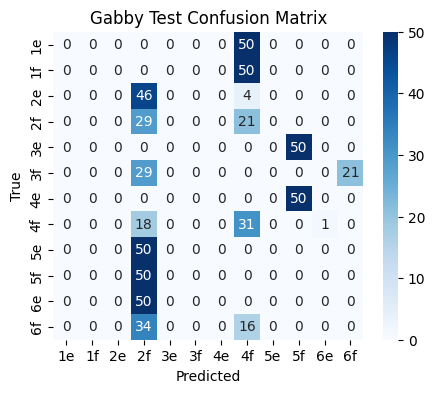

Test Loss: 10.8427 | Test Acc: 0.1000


In [21]:
# plot confusion matrix on validation set for 12 movements on best model
#############
### test on Gabby dataset
# load the Gabby factors dataset for test
with open(r"..\datasets\lfads_factors\gabby\lfads_factors_train.pkl", "rb") as f:
    x_f_test, y_f_test = pickle.load(f)

# Create Gabby dataset
gabby_test_dataset = FactorDataset(x_f_test, y_f_test)
# Create data loader
gabby_test_loader = torch.utils.data.DataLoader(gabby_test_dataset, batch_size=64, shuffle=False)

# Load best model
model.load_state_dict(torch.load(os.path.join(chp_save, "best_acc_model.pth")))

# Evaluate on gabby test set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in gabby_test_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Gabby Test Confusion Matrix')

# Evaluate on test set
test_loss, test_acc = evaluate(gabby_test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


# same with 1d conv

Classifier using cnn

In [22]:
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
# Define a single Residual Block with 50% dropout after each convolution
class ResidualBlock(nn.Module):
    def __init__(self, in_channels , dropout=0.2):
        super().__init__()

        # Direct (main) path
        self.direct_path = nn.Sequential(
            nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.Dropout(dropout),
            nn.ReLU()
        )

        # Skip (shortcut) path
        self.skip_layers = nn.Conv1d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        direct_out = self.direct_path(x)
        skip_out = self.skip_layers(x)
        out = direct_out + skip_out
        return torch.relu(out)

# Now define a small network using several Residual Blocks
class ResidualNet1D(nn.Module):
    def __init__(self, in_channels, num_classes , dropout=0.2):
        super().__init__()

        # Initial convolution (to go to a working channel size)
        self.initial = nn.Sequential(
            nn.Conv1d(in_channels, 16, kernel_size=7, padding=3),
            nn.Dropout(dropout),
            nn.BatchNorm1d(16),
            nn.ReLU()
        )

        # Stack of Residual Blocks
        self.res_blocks = nn.Sequential(
            ResidualBlock(16),
            ResidualBlock(16),
            ResidualBlock(16),
        )

        # Pooling and final classification layer
        self.pool = nn.AdaptiveAvgPool1d(1)  # Output: [batch, 16, 1]
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.initial(x)
        x = self.res_blocks(x)
        x = self.pool(x).squeeze(-1)  # shape [batch_size, 16]
        x = self.fc(x)
        return x
    
    
## data loader
class FactorDataset(torch.utils.data.Dataset):
    def __init__(self, factors, labels):
        self.factors = factors
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.factors[idx], self.labels[idx]

# load the factors dataset for Chip training
with open(r"..\datasets\lfads_factors\chip\lfads_factors_train.pkl", "rb") as f:
    x_f_train, y_f_train = pickle.load(f)
# load the factors dataset for Chip validation
with open(r"..\datasets\lfads_factors\chip\lfads_factors_val.pkl", "rb") as f:
    x_f_val, y_f_val = pickle.load(f)
# load the factors dataset for Chip test
with open(r"..\datasets\lfads_factors\chip\lfads_factors_test.pkl", "rb") as f:
    x_f_test, y_f_test = pickle.load(f)

# Create datasets
train_dataset = FactorDataset(x_f_train, y_f_train)
val_dataset = FactorDataset(x_f_val, y_f_val)
test_dataset = FactorDataset(x_f_test, y_f_test)
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [38]:
### lets build a classifier and train it on the C_factors to distinguish between movements
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## data loader
class FactorDataset(torch.utils.data.Dataset):
    def __init__(self, factors, labels):
        self.factors = factors.transpose(0,2,1)  # [B, T, F] to [B, F, T]
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.factors[idx], self.labels[idx]
    
# load the factors dataset for Chip training
with open(r"..\datasets\lfads_factors\chip\lfads_factors_train.pkl", "rb") as f:
    x_f_train, y_f_train = pickle.load(f)
# load the factors dataset for Chip validation
with open(r"..\datasets\lfads_factors\chip\lfads_factors_val.pkl", "rb") as f:
    x_f_val, y_f_val = pickle.load(f)
# load the factors dataset for Chip test
with open(r"..\datasets\lfads_factors\chip\lfads_factors_test.pkl", "rb") as f:
    x_f_test, y_f_test = pickle.load(f)

# Create datasets
train_dataset = FactorDataset(x_f_train, y_f_train)
val_dataset = FactorDataset(x_f_val, y_f_val)
test_dataset = FactorDataset(x_f_test, y_f_test)
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# === Setup
chp_save = r"..\trained_cpts\lfads_classifier_conv1d"
os.makedirs(chp_save, exist_ok=True)


# === Init
input_dim = x_f_train.shape[2]
hidden_dim = 128
output_dim = len(np.unique(y_f_train))
print(f"Input Dim: {input_dim}, Output Dim: {output_dim}")
model = ResidualNet1D(in_channels=input_dim, num_classes=output_dim, dropout=0.2).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
# === Tracking
train_losses = []
val_losses = []
val_accs = []
best_val_loss = float("inf")
best_val_acc = 0.0

def evaluate(loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.cuda()
            y = y.long().cuda()  # <-- this is the fix
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item() * x.size(0)
            correct += (outputs.argmax(1) == y).sum().item()
    avg_loss = total_loss / len(loader.dataset)
    acc = correct / len(loader.dataset)
    return avg_loss, acc

def plot_metrics(train_losses, val_losses, val_accs, path):
    fig, ax1 = plt.subplots()

    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(val_losses, label='Val Loss', color='orange')
    ax1.set_xlabel('Half Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(val_accs, label='Val Acc', color='green')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='upper right')

    plt.title('Loss and Accuracy')
    fig.tight_layout()
    plt.savefig(os.path.join(path, 'loss_acc_curve.png'))
    plt.close()


# === Training loop
num_epochs = 200
a = 0
log_interval = len(train_loader) 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (factors, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        factors = factors.cuda()
        labels = labels.long().cuda()
        optimizer.zero_grad()
        outputs = model(factors)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * factors.size(0)

        # === Mid-epoch validation
        if (batch_idx + 1) % log_interval == 0 or (batch_idx + 1) == len(train_loader):
            half_epoch = epoch + (batch_idx + 1) / len(train_loader)
            train_loss = running_loss / ((batch_idx + 1) * train_loader.batch_size)
            val_loss, val_acc = evaluate(val_loader)

            print(f"[{half_epoch:.2f} epochs] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            plot_metrics(train_losses, val_losses, val_accs, chp_save)      

            # Save best checkpoint
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                ckpt_path = os.path.join(chp_save, "C_best_model.pth")
                torch.save(model.state_dict(), ckpt_path)
                print(f"✅ Saved best checkpoint to {ckpt_path}")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                ckpt_path = os.path.join(chp_save, "C_best_acc_model.pth")
                torch.save(model.state_dict(), ckpt_path)
                print(f"✅ Saved best accuracy checkpoint to {ckpt_path}")
                
    # Update learning rate
    lr_scheduler.step(val_loss)
    print(f"Updated learning rate to {optimizer.param_groups[0]['lr']:.6f}")

Input Dim: 15, Output Dim: 12


Epoch 1: 100%|██████████| 94/94 [00:00<00:00, 107.21it/s]

[1.00 epochs] Train Loss: 2.4368 | Val Loss: 2.3534 | Val Acc: 0.1667
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_model.pth
✅ Saved best accuracy checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_acc_model.pth


Updated learning rate to 0.000100


Epoch 2: 100%|██████████| 94/94 [00:00<00:00, 101.83it/s]


[2.00 epochs] Train Loss: 2.2412 | Val Loss: 2.1961 | Val Acc: 0.1667
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_model.pth
Updated learning rate to 0.000100


Epoch 3:  89%|████████▉ | 84/94 [00:00<00:00, 147.59it/s]

[3.00 epochs] Train Loss: 2.1767 | Val Loss: 2.1664 | Val Acc: 0.2500


Epoch 3: 100%|██████████| 94/94 [00:02<00:00, 44.84it/s] 


✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_model.pth
✅ Saved best accuracy checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_acc_model.pth
Updated learning rate to 0.000100


Epoch 4: 100%|██████████| 94/94 [00:00<00:00, 107.83it/s]


[4.00 epochs] Train Loss: 2.1100 | Val Loss: 2.0602 | Val Acc: 0.2500
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_model.pth
Updated learning rate to 0.000100


Epoch 5: 100%|██████████| 94/94 [00:00<00:00, 113.09it/s]


[5.00 epochs] Train Loss: 1.9397 | Val Loss: 1.8372 | Val Acc: 0.5050
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_model.pth
✅ Saved best accuracy checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_acc_model.pth
Updated learning rate to 0.000100


Epoch 6: 100%|██████████| 94/94 [00:00<00:00, 102.26it/s]

[6.00 epochs] Train Loss: 1.6627 | Val Loss: 1.5176 | Val Acc: 0.3650
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_model.pth


Updated learning rate to 0.000100


Epoch 7: 100%|██████████| 94/94 [00:00<00:00, 111.68it/s]


[7.00 epochs] Train Loss: 1.3611 | Val Loss: 1.2344 | Val Acc: 0.5417
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_model.pth
✅ Saved best accuracy checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_acc_model.pth
Updated learning rate to 0.000100


Epoch 8:  97%|█████████▋| 91/94 [00:00<00:00, 132.49it/s]

[8.00 epochs] Train Loss: 1.0990 | Val Loss: 1.2354 | Val Acc: 0.5850


Epoch 8: 100%|██████████| 94/94 [00:00<00:00, 96.06it/s] 


✅ Saved best accuracy checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_acc_model.pth
Updated learning rate to 0.000100


Epoch 9: 100%|██████████| 94/94 [00:00<00:00, 98.10it/s] 


[9.00 epochs] Train Loss: 0.8323 | Val Loss: 0.9837 | Val Acc: 0.6300
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_model.pth
✅ Saved best accuracy checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_acc_model.pth
Updated learning rate to 0.000100


Epoch 10: 100%|██████████| 94/94 [00:00<00:00, 124.92it/s]


[10.00 epochs] Train Loss: 0.5598 | Val Loss: 0.7476 | Val Acc: 0.7817
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_model.pth
✅ Saved best accuracy checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_acc_model.pth
Updated learning rate to 0.000100


Epoch 11: 100%|██████████| 94/94 [00:00<00:00, 104.68it/s]

[11.00 epochs] Train Loss: 0.3530 | Val Loss: 0.7540 | Val Acc: 0.8300
✅ Saved best accuracy checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_acc_model.pth


Updated learning rate to 0.000100


Epoch 12: 100%|██████████| 94/94 [00:00<00:00, 101.03it/s]


[12.00 epochs] Train Loss: 0.2427 | Val Loss: 0.7592 | Val Acc: 0.8350
✅ Saved best accuracy checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_acc_model.pth
Updated learning rate to 0.000100


Epoch 13:  95%|█████████▍| 89/94 [00:00<00:00, 138.49it/s]

[13.00 epochs] Train Loss: 0.1911 | Val Loss: 0.3974 | Val Acc: 0.8900


Epoch 13: 100%|██████████| 94/94 [00:01<00:00, 90.73it/s] 


✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_model.pth
✅ Saved best accuracy checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_acc_model.pth
Updated learning rate to 0.000100


Epoch 14: 100%|██████████| 94/94 [00:00<00:00, 105.27it/s]


[14.00 epochs] Train Loss: 0.1460 | Val Loss: 0.6362 | Val Acc: 0.6933
Updated learning rate to 0.000100


Epoch 15:  86%|████████▌ | 81/94 [00:00<00:00, 143.27it/s]

[15.00 epochs] Train Loss: 0.1187 | Val Loss: 0.5332 | Val Acc: 0.8983


Epoch 15: 100%|██████████| 94/94 [00:00<00:00, 101.18it/s]


✅ Saved best accuracy checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_acc_model.pth
Updated learning rate to 0.000100


Epoch 16: 100%|██████████| 94/94 [00:00<00:00, 99.86it/s] 

[16.00 epochs] Train Loss: 0.1003 | Val Loss: 0.5774 | Val Acc: 0.8567


Updated learning rate to 0.000100


Epoch 17: 100%|██████████| 94/94 [00:00<00:00, 125.12it/s]


[17.00 epochs] Train Loss: 0.0819 | Val Loss: 0.4245 | Val Acc: 0.9200
✅ Saved best accuracy checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_acc_model.pth
Updated learning rate to 0.000100


Epoch 18:  99%|█████████▉| 93/94 [00:00<00:00, 167.03it/s]

[18.00 epochs] Train Loss: 0.0664 | Val Loss: 0.7059 | Val Acc: 0.8550


Epoch 18: 100%|██████████| 94/94 [00:00<00:00, 113.14it/s]


Updated learning rate to 0.000100


Epoch 19: 100%|██████████| 94/94 [00:00<00:00, 94.27it/s] 


[19.00 epochs] Train Loss: 0.0596 | Val Loss: 0.2794 | Val Acc: 0.9017
✅ Saved best checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_model.pth
Updated learning rate to 0.000100


Epoch 20: 100%|██████████| 94/94 [00:00<00:00, 121.15it/s]


[20.00 epochs] Train Loss: 0.0734 | Val Loss: 0.5259 | Val Acc: 0.9100
Updated learning rate to 0.000100


Epoch 21: 100%|██████████| 94/94 [00:00<00:00, 102.91it/s]

[21.00 epochs] Train Loss: 0.0469 | Val Loss: 0.5456 | Val Acc: 0.9050


Updated learning rate to 0.000100


Epoch 22: 100%|██████████| 94/94 [00:00<00:00, 97.24it/s] 


[22.00 epochs] Train Loss: 0.0430 | Val Loss: 0.3510 | Val Acc: 0.9233
✅ Saved best accuracy checkpoint to ..\trained_cpts\lfads_classifier_conv1d\C_best_acc_model.pth
Updated learning rate to 0.000100


Epoch 23: 100%|██████████| 94/94 [00:00<00:00, 103.88it/s]


[23.00 epochs] Train Loss: 0.0404 | Val Loss: 0.5255 | Val Acc: 0.9117
Updated learning rate to 0.000100


Epoch 24: 100%|██████████| 94/94 [00:00<00:00, 96.63it/s] 


[24.00 epochs] Train Loss: 0.0392 | Val Loss: 0.5301 | Val Acc: 0.8617
Updated learning rate to 0.000100


Epoch 25: 100%|██████████| 94/94 [00:00<00:00, 133.81it/s]


[25.00 epochs] Train Loss: 0.0377 | Val Loss: 0.7649 | Val Acc: 0.8317
Updated learning rate to 0.000050


Epoch 26:  94%|█████████▎| 88/94 [00:00<00:00, 141.42it/s]

[26.00 epochs] Train Loss: 0.0279 | Val Loss: 0.4886 | Val Acc: 0.9183


Epoch 26: 100%|██████████| 94/94 [00:00<00:00, 97.21it/s] 


Updated learning rate to 0.000050


Epoch 27: 100%|██████████| 94/94 [00:01<00:00, 84.48it/s] 


[27.00 epochs] Train Loss: 0.0269 | Val Loss: 0.5196 | Val Acc: 0.9133
Updated learning rate to 0.000050


Epoch 28: 100%|██████████| 94/94 [00:00<00:00, 121.19it/s]


[28.00 epochs] Train Loss: 0.0380 | Val Loss: 0.6635 | Val Acc: 0.8967
Updated learning rate to 0.000050


Epoch 29:  94%|█████████▎| 88/94 [00:00<00:00, 124.18it/s]

[29.00 epochs] Train Loss: 0.0311 | Val Loss: 0.5275 | Val Acc: 0.9083


Epoch 29: 100%|██████████| 94/94 [00:00<00:00, 96.59it/s] 


Updated learning rate to 0.000050


Epoch 30: 100%|██████████| 94/94 [00:00<00:00, 102.05it/s]


[30.00 epochs] Train Loss: 0.0251 | Val Loss: 0.5673 | Val Acc: 0.8300
Updated learning rate to 0.000050


Epoch 31: 100%|██████████| 94/94 [00:00<00:00, 108.22it/s]

[31.00 epochs] Train Loss: 0.0204 | Val Loss: 0.4691 | Val Acc: 0.9183


Updated learning rate to 0.000025


Epoch 32: 100%|██████████| 94/94 [00:00<00:00, 99.72it/s] 

[32.00 epochs] Train Loss: 0.0254 | Val Loss: 0.4755 | Val Acc: 0.9200


Updated learning rate to 0.000025


Epoch 33: 100%|██████████| 94/94 [00:00<00:00, 102.39it/s]


[33.00 epochs] Train Loss: 0.0229 | Val Loss: 0.5150 | Val Acc: 0.9117
Updated learning rate to 0.000025


Epoch 34: 100%|██████████| 94/94 [00:00<00:00, 98.82it/s] 


[34.00 epochs] Train Loss: 0.0207 | Val Loss: 0.5730 | Val Acc: 0.8983
Updated learning rate to 0.000025


Epoch 35: 100%|██████████| 94/94 [00:00<00:00, 136.86it/s]


[35.00 epochs] Train Loss: 0.0188 | Val Loss: 0.5830 | Val Acc: 0.9033
Updated learning rate to 0.000025


Epoch 36:  94%|█████████▎| 88/94 [00:00<00:00, 168.14it/s]

[36.00 epochs] Train Loss: 0.0190 | Val Loss: 0.5585 | Val Acc: 0.8967


Epoch 36: 100%|██████████| 94/94 [00:00<00:00, 109.43it/s]


Updated learning rate to 0.000025


Epoch 37: 100%|██████████| 94/94 [00:00<00:00, 77.53it/s] 

[37.00 epochs] Train Loss: 0.0198 | Val Loss: 0.4989 | Val Acc: 0.9000


Epoch 37: 100%|██████████| 94/94 [00:00<00:00, 97.57it/s]


Updated learning rate to 0.000013


Epoch 38: 100%|██████████| 94/94 [00:00<00:00, 105.79it/s]


[38.00 epochs] Train Loss: 0.0185 | Val Loss: 0.6061 | Val Acc: 0.8983
Updated learning rate to 0.000013


Epoch 39: 100%|██████████| 94/94 [00:00<00:00, 100.26it/s]

[39.00 epochs] Train Loss: 0.0167 | Val Loss: 0.6830 | Val Acc: 0.8900


Updated learning rate to 0.000013


Epoch 40: 100%|██████████| 94/94 [00:00<00:00, 81.92it/s] 

[40.00 epochs] Train Loss: 0.0229 | Val Loss: 0.6196 | Val Acc: 0.9050


Epoch 40: 100%|██████████| 94/94 [00:00<00:00, 105.76it/s]


Updated learning rate to 0.000013


Epoch 41: 100%|██████████| 94/94 [00:00<00:00, 116.05it/s]


[41.00 epochs] Train Loss: 0.0168 | Val Loss: 0.6641 | Val Acc: 0.8883
Updated learning rate to 0.000013


Epoch 42: 100%|██████████| 94/94 [00:00<00:00, 109.76it/s]


[42.00 epochs] Train Loss: 0.0165 | Val Loss: 0.6215 | Val Acc: 0.8933
Updated learning rate to 0.000013


Epoch 43: 100%|██████████| 94/94 [00:00<00:00, 130.90it/s]


[43.00 epochs] Train Loss: 0.0180 | Val Loss: 0.5322 | Val Acc: 0.9133
Updated learning rate to 0.000006


Epoch 44:  97%|█████████▋| 91/94 [00:00<00:00, 157.38it/s]

[44.00 epochs] Train Loss: 0.0163 | Val Loss: 0.5033 | Val Acc: 0.9200


Epoch 44: 100%|██████████| 94/94 [00:00<00:00, 102.18it/s]


Updated learning rate to 0.000006


Epoch 45: 100%|██████████| 94/94 [00:00<00:00, 102.94it/s]


[45.00 epochs] Train Loss: 0.0194 | Val Loss: 0.5892 | Val Acc: 0.8983
Updated learning rate to 0.000006


Epoch 46: 100%|██████████| 94/94 [00:00<00:00, 123.73it/s]


[46.00 epochs] Train Loss: 0.0165 | Val Loss: 0.5037 | Val Acc: 0.9167
Updated learning rate to 0.000006


Epoch 47: 100%|██████████| 94/94 [00:00<00:00, 98.43it/s] 


[47.00 epochs] Train Loss: 0.0148 | Val Loss: 0.5274 | Val Acc: 0.9083
Updated learning rate to 0.000006


Epoch 48: 100%|██████████| 94/94 [00:00<00:00, 133.89it/s]


[48.00 epochs] Train Loss: 0.0186 | Val Loss: 0.4768 | Val Acc: 0.9183
Updated learning rate to 0.000006


Epoch 49: 100%|██████████| 94/94 [00:00<00:00, 113.37it/s]


[49.00 epochs] Train Loss: 0.0178 | Val Loss: 0.5512 | Val Acc: 0.9050
Updated learning rate to 0.000003


Epoch 50: 100%|██████████| 94/94 [00:00<00:00, 108.29it/s]


[50.00 epochs] Train Loss: 0.0187 | Val Loss: 0.5555 | Val Acc: 0.9067
Updated learning rate to 0.000003


Epoch 51: 100%|██████████| 94/94 [00:00<00:00, 109.29it/s]


[51.00 epochs] Train Loss: 0.0134 | Val Loss: 0.4925 | Val Acc: 0.9033
Updated learning rate to 0.000003


Epoch 52:  93%|█████████▎| 87/94 [00:00<00:00, 158.73it/s]

[52.00 epochs] Train Loss: 0.0185 | Val Loss: 0.5957 | Val Acc: 0.8850


Epoch 52: 100%|██████████| 94/94 [00:00<00:00, 105.83it/s]


Updated learning rate to 0.000003


Epoch 53: 100%|██████████| 94/94 [00:00<00:00, 112.74it/s]


[53.00 epochs] Train Loss: 0.0181 | Val Loss: 0.5677 | Val Acc: 0.9067
Updated learning rate to 0.000003


Epoch 54: 100%|██████████| 94/94 [00:00<00:00, 118.15it/s]


[54.00 epochs] Train Loss: 0.0146 | Val Loss: 0.5265 | Val Acc: 0.9100
Updated learning rate to 0.000003


Epoch 55:  89%|████████▉ | 84/94 [00:00<00:00, 120.75it/s]

[55.00 epochs] Train Loss: 0.0186 | Val Loss: 0.5765 | Val Acc: 0.9050


Epoch 55: 100%|██████████| 94/94 [00:01<00:00, 92.56it/s] 


Updated learning rate to 0.000002


Epoch 56: 100%|██████████| 94/94 [00:00<00:00, 111.86it/s]


[56.00 epochs] Train Loss: 0.0186 | Val Loss: 0.6209 | Val Acc: 0.8983
Updated learning rate to 0.000002


Epoch 57:  94%|█████████▎| 88/94 [00:00<00:00, 173.25it/s]

[57.00 epochs] Train Loss: 0.0145 | Val Loss: 0.5367 | Val Acc: 0.9067


Epoch 57: 100%|██████████| 94/94 [00:01<00:00, 83.45it/s] 


Updated learning rate to 0.000002


Epoch 58: 100%|██████████| 94/94 [00:00<00:00, 125.63it/s]


[58.00 epochs] Train Loss: 0.0162 | Val Loss: 0.4757 | Val Acc: 0.9200
Updated learning rate to 0.000002


Epoch 59:  98%|█████████▊| 92/94 [00:00<00:00, 144.60it/s]

[59.00 epochs] Train Loss: 0.0155 | Val Loss: 0.4524 | Val Acc: 0.9150


Epoch 59: 100%|██████████| 94/94 [00:00<00:00, 108.00it/s]


Updated learning rate to 0.000002


Epoch 60: 100%|██████████| 94/94 [00:00<00:00, 99.74it/s] 

[60.00 epochs] Train Loss: 0.0183 | Val Loss: 0.5047 | Val Acc: 0.9117


Updated learning rate to 0.000002


Epoch 61: 100%|██████████| 94/94 [00:00<00:00, 118.84it/s]


[61.00 epochs] Train Loss: 0.0149 | Val Loss: 0.5570 | Val Acc: 0.9067
Updated learning rate to 0.000001


Epoch 62:  79%|███████▊  | 74/94 [00:00<00:00, 174.37it/s]

[62.00 epochs] Train Loss: 0.0141 | Val Loss: 0.5395 | Val Acc: 0.9050


Epoch 62: 100%|██████████| 94/94 [00:00<00:00, 122.03it/s]


Updated learning rate to 0.000001


Epoch 63: 100%|██████████| 94/94 [00:00<00:00, 101.76it/s]


[63.00 epochs] Train Loss: 0.0148 | Val Loss: 0.5903 | Val Acc: 0.9117
Updated learning rate to 0.000001


Epoch 64: 100%|██████████| 94/94 [00:01<00:00, 92.30it/s] 

[64.00 epochs] Train Loss: 0.0159 | Val Loss: 0.6215 | Val Acc: 0.9000


Updated learning rate to 0.000001


Epoch 65: 100%|██████████| 94/94 [00:00<00:00, 94.77it/s] 


[65.00 epochs] Train Loss: 0.0160 | Val Loss: 0.5404 | Val Acc: 0.9033
Updated learning rate to 0.000001


Epoch 66: 100%|██████████| 94/94 [00:01<00:00, 91.29it/s] 

[66.00 epochs] Train Loss: 0.0167 | Val Loss: 0.5123 | Val Acc: 0.9183


Updated learning rate to 0.000001


Epoch 67:  91%|█████████▏| 86/94 [00:00<00:00, 126.26it/s]

[67.00 epochs] Train Loss: 0.0172 | Val Loss: 0.6049 | Val Acc: 0.9017


Epoch 67: 100%|██████████| 94/94 [00:00<00:00, 94.21it/s] 


Updated learning rate to 0.000000


Epoch 68:  97%|█████████▋| 91/94 [00:00<00:00, 115.04it/s]

[68.00 epochs] Train Loss: 0.0150 | Val Loss: 0.5763 | Val Acc: 0.9117


Epoch 68: 100%|██████████| 94/94 [00:01<00:00, 83.49it/s] 


Updated learning rate to 0.000000


Epoch 69: 100%|██████████| 94/94 [00:00<00:00, 104.56it/s]


[69.00 epochs] Train Loss: 0.0162 | Val Loss: 0.5656 | Val Acc: 0.9067
Updated learning rate to 0.000000


Epoch 70:  85%|████████▌ | 80/94 [00:00<00:00, 135.03it/s]

[70.00 epochs] Train Loss: 0.0163 | Val Loss: 0.5387 | Val Acc: 0.9083


Epoch 70: 100%|██████████| 94/94 [00:00<00:00, 97.46it/s] 


Updated learning rate to 0.000000


Epoch 71: 100%|██████████| 94/94 [00:00<00:00, 112.25it/s]


[71.00 epochs] Train Loss: 0.0164 | Val Loss: 0.5545 | Val Acc: 0.8917
Updated learning rate to 0.000000


Epoch 72: 100%|██████████| 94/94 [00:00<00:00, 119.46it/s]


[72.00 epochs] Train Loss: 0.0156 | Val Loss: 0.4892 | Val Acc: 0.9117
Updated learning rate to 0.000000


Epoch 73: 100%|██████████| 94/94 [00:00<00:00, 98.27it/s] 


[73.00 epochs] Train Loss: 0.0154 | Val Loss: 0.5160 | Val Acc: 0.9100
Updated learning rate to 0.000000


Epoch 74: 100%|██████████| 94/94 [00:00<00:00, 94.35it/s] 


[74.00 epochs] Train Loss: 0.0158 | Val Loss: 0.4477 | Val Acc: 0.9133
Updated learning rate to 0.000000


Epoch 75: 100%|██████████| 94/94 [00:00<00:00, 94.90it/s] 

[75.00 epochs] Train Loss: 0.0158 | Val Loss: 0.4848 | Val Acc: 0.9183


Updated learning rate to 0.000000


Epoch 76: 100%|██████████| 94/94 [00:00<00:00, 128.87it/s]


[76.00 epochs] Train Loss: 0.0185 | Val Loss: 0.5716 | Val Acc: 0.8900
Updated learning rate to 0.000000


Epoch 77:  93%|█████████▎| 87/94 [00:00<00:00, 123.14it/s]

[77.00 epochs] Train Loss: 0.0159 | Val Loss: 0.5788 | Val Acc: 0.8950


Epoch 77: 100%|██████████| 94/94 [00:01<00:00, 92.81it/s] 


Updated learning rate to 0.000000


Epoch 78: 100%|██████████| 94/94 [00:00<00:00, 95.34it/s] 


[78.00 epochs] Train Loss: 0.0160 | Val Loss: 0.5059 | Val Acc: 0.9117
Updated learning rate to 0.000000


Epoch 79: 100%|██████████| 94/94 [00:00<00:00, 114.59it/s]


[79.00 epochs] Train Loss: 0.0154 | Val Loss: 0.5036 | Val Acc: 0.9150
Updated learning rate to 0.000000


Epoch 80: 100%|██████████| 94/94 [00:00<00:00, 104.30it/s]

[80.00 epochs] Train Loss: 0.0152 | Val Loss: 0.5927 | Val Acc: 0.9050


Updated learning rate to 0.000000


Epoch 81: 100%|██████████| 94/94 [00:00<00:00, 99.70it/s] 

[81.00 epochs] Train Loss: 0.0168 | Val Loss: 0.4742 | Val Acc: 0.9067


Updated learning rate to 0.000000


Epoch 82:  94%|█████████▎| 88/94 [00:00<00:00, 131.17it/s]

[82.00 epochs] Train Loss: 0.0155 | Val Loss: 0.5520 | Val Acc: 0.9100


Epoch 82: 100%|██████████| 94/94 [00:01<00:00, 92.27it/s] 


Updated learning rate to 0.000000


Epoch 83: 100%|██████████| 94/94 [00:00<00:00, 107.37it/s]


[83.00 epochs] Train Loss: 0.0165 | Val Loss: 0.4975 | Val Acc: 0.9117
Updated learning rate to 0.000000


Epoch 84: 100%|██████████| 94/94 [00:00<00:00, 95.93it/s] 


[84.00 epochs] Train Loss: 0.0171 | Val Loss: 0.4803 | Val Acc: 0.9133
Updated learning rate to 0.000000


Epoch 85: 100%|██████████| 94/94 [00:00<00:00, 95.31it/s] 


[85.00 epochs] Train Loss: 0.0144 | Val Loss: 0.5793 | Val Acc: 0.9033
Updated learning rate to 0.000000


Epoch 86: 100%|██████████| 94/94 [00:00<00:00, 131.68it/s]


[86.00 epochs] Train Loss: 0.0183 | Val Loss: 0.6163 | Val Acc: 0.9050
Updated learning rate to 0.000000


Epoch 87:  91%|█████████▏| 86/94 [00:00<00:00, 139.05it/s]

[87.00 epochs] Train Loss: 0.0148 | Val Loss: 0.5620 | Val Acc: 0.9033


Epoch 87: 100%|██████████| 94/94 [00:00<00:00, 99.15it/s] 


Updated learning rate to 0.000000


Epoch 88: 100%|██████████| 94/94 [00:00<00:00, 101.58it/s]


[88.00 epochs] Train Loss: 0.0145 | Val Loss: 0.5181 | Val Acc: 0.9150
Updated learning rate to 0.000000


Epoch 89: 100%|██████████| 94/94 [00:00<00:00, 108.69it/s]


[89.00 epochs] Train Loss: 0.0155 | Val Loss: 0.5404 | Val Acc: 0.9117
Updated learning rate to 0.000000


Epoch 90:  91%|█████████▏| 86/94 [00:00<00:00, 112.84it/s]

[90.00 epochs] Train Loss: 0.0166 | Val Loss: 0.5293 | Val Acc: 0.8950


Epoch 90: 100%|██████████| 94/94 [00:01<00:00, 83.16it/s] 


Updated learning rate to 0.000000


Epoch 91: 100%|██████████| 94/94 [00:01<00:00, 90.38it/s] 

[91.00 epochs] Train Loss: 0.0186 | Val Loss: 0.5497 | Val Acc: 0.9083


Updated learning rate to 0.000000


Epoch 92: 100%|██████████| 94/94 [00:01<00:00, 90.13it/s] 


[92.00 epochs] Train Loss: 0.0170 | Val Loss: 0.5643 | Val Acc: 0.9133
Updated learning rate to 0.000000


Epoch 93:  83%|████████▎ | 78/94 [00:00<00:00, 148.56it/s]

[93.00 epochs] Train Loss: 0.0149 | Val Loss: 0.5427 | Val Acc: 0.8967


Epoch 93: 100%|██████████| 94/94 [00:01<00:00, 77.24it/s] 


Updated learning rate to 0.000000


Epoch 94: 100%|██████████| 94/94 [00:01<00:00, 91.04it/s] 

[94.00 epochs] Train Loss: 0.0151 | Val Loss: 0.5449 | Val Acc: 0.9083


Updated learning rate to 0.000000


Epoch 95: 100%|██████████| 94/94 [00:00<00:00, 121.60it/s]


[95.00 epochs] Train Loss: 0.0171 | Val Loss: 0.5774 | Val Acc: 0.9017
Updated learning rate to 0.000000


Epoch 96: 100%|██████████| 94/94 [00:00<00:00, 130.69it/s]


[96.00 epochs] Train Loss: 0.0167 | Val Loss: 0.4944 | Val Acc: 0.8933
Updated learning rate to 0.000000


Epoch 97: 100%|██████████| 94/94 [00:00<00:00, 94.87it/s] 


[97.00 epochs] Train Loss: 0.0150 | Val Loss: 0.5039 | Val Acc: 0.9133
Updated learning rate to 0.000000


Epoch 98:  93%|█████████▎| 87/94 [00:00<00:00, 136.95it/s]

[98.00 epochs] Train Loss: 0.0157 | Val Loss: 0.5494 | Val Acc: 0.9117


Epoch 98: 100%|██████████| 94/94 [00:00<00:00, 101.65it/s]


Updated learning rate to 0.000000


Epoch 99: 100%|██████████| 94/94 [00:00<00:00, 112.04it/s]


[99.00 epochs] Train Loss: 0.0151 | Val Loss: 0.5132 | Val Acc: 0.8967
Updated learning rate to 0.000000


Epoch 100: 100%|██████████| 94/94 [00:00<00:00, 108.88it/s]

[100.00 epochs] Train Loss: 0.0152 | Val Loss: 0.5581 | Val Acc: 0.9133


Updated learning rate to 0.000000


Epoch 101: 100%|██████████| 94/94 [00:00<00:00, 95.12it/s] 

[101.00 epochs] Train Loss: 0.0156 | Val Loss: 0.5588 | Val Acc: 0.9133


Updated learning rate to 0.000000


Epoch 102: 100%|██████████| 94/94 [00:00<00:00, 115.72it/s]


[102.00 epochs] Train Loss: 0.0153 | Val Loss: 0.5184 | Val Acc: 0.9083
Updated learning rate to 0.000000


Epoch 103: 100%|██████████| 94/94 [00:00<00:00, 136.14it/s]


[103.00 epochs] Train Loss: 0.0153 | Val Loss: 0.6038 | Val Acc: 0.8867
Updated learning rate to 0.000000


Epoch 104:  91%|█████████▏| 86/94 [00:00<00:00, 117.94it/s]

[104.00 epochs] Train Loss: 0.0163 | Val Loss: 0.4975 | Val Acc: 0.9183


Epoch 104: 100%|██████████| 94/94 [00:01<00:00, 86.56it/s] 


Updated learning rate to 0.000000


Epoch 105: 100%|██████████| 94/94 [00:00<00:00, 106.53it/s]


[105.00 epochs] Train Loss: 0.0139 | Val Loss: 0.5616 | Val Acc: 0.9050
Updated learning rate to 0.000000


Epoch 106: 100%|██████████| 94/94 [00:00<00:00, 95.69it/s] 

[106.00 epochs] Train Loss: 0.0194 | Val Loss: 0.5468 | Val Acc: 0.9050


Updated learning rate to 0.000000


Epoch 107: 100%|██████████| 94/94 [00:00<00:00, 95.33it/s] 

[107.00 epochs] Train Loss: 0.0148 | Val Loss: 0.5378 | Val Acc: 0.9117


Updated learning rate to 0.000000


Epoch 108:  96%|█████████▌| 90/94 [00:00<00:00, 116.76it/s]

[108.00 epochs] Train Loss: 0.0145 | Val Loss: 0.6371 | Val Acc: 0.8817


Epoch 108: 100%|██████████| 94/94 [00:01<00:00, 87.58it/s] 


Updated learning rate to 0.000000


Epoch 109: 100%|██████████| 94/94 [00:00<00:00, 115.43it/s]


[109.00 epochs] Train Loss: 0.0149 | Val Loss: 0.5432 | Val Acc: 0.9067
Updated learning rate to 0.000000


Epoch 110: 100%|██████████| 94/94 [00:00<00:00, 117.58it/s]


[110.00 epochs] Train Loss: 0.0153 | Val Loss: 0.5094 | Val Acc: 0.9167
Updated learning rate to 0.000000


Epoch 111: 100%|██████████| 94/94 [00:01<00:00, 90.46it/s] 


[111.00 epochs] Train Loss: 0.0143 | Val Loss: 0.5267 | Val Acc: 0.9050
Updated learning rate to 0.000000


Epoch 112: 100%|██████████| 94/94 [00:00<00:00, 106.74it/s]


[112.00 epochs] Train Loss: 0.0136 | Val Loss: 0.5432 | Val Acc: 0.9067
Updated learning rate to 0.000000


Epoch 113:  94%|█████████▎| 88/94 [00:00<00:00, 142.96it/s]

[113.00 epochs] Train Loss: 0.0146 | Val Loss: 0.6213 | Val Acc: 0.9050


Epoch 113: 100%|██████████| 94/94 [00:00<00:00, 105.91it/s]


Updated learning rate to 0.000000


Epoch 114:  93%|█████████▎| 87/94 [00:00<00:00, 125.99it/s]

[114.00 epochs] Train Loss: 0.0158 | Val Loss: 0.4772 | Val Acc: 0.9200


Epoch 114: 100%|██████████| 94/94 [00:00<00:00, 96.55it/s] 


Updated learning rate to 0.000000


Epoch 115: 100%|██████████| 94/94 [00:00<00:00, 107.26it/s]

[115.00 epochs] Train Loss: 0.0157 | Val Loss: 0.6257 | Val Acc: 0.9050


Updated learning rate to 0.000000


Epoch 116: 100%|██████████| 94/94 [00:00<00:00, 113.75it/s]


[116.00 epochs] Train Loss: 0.0150 | Val Loss: 0.5013 | Val Acc: 0.9183
Updated learning rate to 0.000000


Epoch 117:  95%|█████████▍| 89/94 [00:00<00:00, 167.43it/s]

[117.00 epochs] Train Loss: 0.0129 | Val Loss: 0.5148 | Val Acc: 0.9167


Epoch 117: 100%|██████████| 94/94 [00:00<00:00, 116.15it/s]


Updated learning rate to 0.000000


Epoch 118: 100%|██████████| 94/94 [00:00<00:00, 99.00it/s] 

[118.00 epochs] Train Loss: 0.0168 | Val Loss: 0.6002 | Val Acc: 0.9050


Updated learning rate to 0.000000


Epoch 119: 100%|██████████| 94/94 [00:00<00:00, 108.23it/s]


[119.00 epochs] Train Loss: 0.0149 | Val Loss: 0.5021 | Val Acc: 0.9183
Updated learning rate to 0.000000


Epoch 120: 100%|██████████| 94/94 [00:00<00:00, 119.57it/s]


[120.00 epochs] Train Loss: 0.0150 | Val Loss: 0.5242 | Val Acc: 0.9100
Updated learning rate to 0.000000


Epoch 121: 100%|██████████| 94/94 [00:00<00:00, 97.52it/s] 


[121.00 epochs] Train Loss: 0.0164 | Val Loss: 0.6631 | Val Acc: 0.8967
Updated learning rate to 0.000000


Epoch 122: 100%|██████████| 94/94 [00:00<00:00, 101.29it/s]

[122.00 epochs] Train Loss: 0.0151 | Val Loss: 0.5940 | Val Acc: 0.9050


Updated learning rate to 0.000000


Epoch 123: 100%|██████████| 94/94 [00:00<00:00, 106.07it/s]


[123.00 epochs] Train Loss: 0.0151 | Val Loss: 0.5748 | Val Acc: 0.9133
Updated learning rate to 0.000000


Epoch 124: 100%|██████████| 94/94 [00:00<00:00, 109.21it/s]


[124.00 epochs] Train Loss: 0.0177 | Val Loss: 0.4838 | Val Acc: 0.9083
Updated learning rate to 0.000000


Epoch 125:  95%|█████████▍| 89/94 [00:00<00:00, 145.58it/s]

[125.00 epochs] Train Loss: 0.0150 | Val Loss: 0.5575 | Val Acc: 0.9083


Epoch 125: 100%|██████████| 94/94 [00:00<00:00, 103.76it/s]


Updated learning rate to 0.000000


Epoch 126: 100%|██████████| 94/94 [00:00<00:00, 103.71it/s]


[126.00 epochs] Train Loss: 0.0176 | Val Loss: 0.5016 | Val Acc: 0.9167
Updated learning rate to 0.000000


Epoch 127: 100%|██████████| 94/94 [00:00<00:00, 119.47it/s]


[127.00 epochs] Train Loss: 0.0143 | Val Loss: 0.6474 | Val Acc: 0.9000
Updated learning rate to 0.000000


Epoch 128: 100%|██████████| 94/94 [00:00<00:00, 98.87it/s] 

[128.00 epochs] Train Loss: 0.0177 | Val Loss: 0.5694 | Val Acc: 0.8933


Updated learning rate to 0.000000


Epoch 129: 100%|██████████| 94/94 [00:00<00:00, 102.55it/s]


[129.00 epochs] Train Loss: 0.0171 | Val Loss: 0.5579 | Val Acc: 0.9050
Updated learning rate to 0.000000


Epoch 130:  96%|█████████▌| 90/94 [00:00<00:00, 170.38it/s]

[130.00 epochs] Train Loss: 0.0170 | Val Loss: 0.5909 | Val Acc: 0.9017


Epoch 130: 100%|██████████| 94/94 [00:00<00:00, 115.95it/s]


Updated learning rate to 0.000000


Epoch 131:  84%|████████▍ | 79/94 [00:00<00:00, 160.73it/s]

[131.00 epochs] Train Loss: 0.0169 | Val Loss: 0.5873 | Val Acc: 0.9067


Epoch 131: 100%|██████████| 94/94 [00:00<00:00, 98.28it/s] 


Updated learning rate to 0.000000


Epoch 132:  90%|█████████ | 85/94 [00:00<00:00, 114.21it/s]

[132.00 epochs] Train Loss: 0.0154 | Val Loss: 0.6340 | Val Acc: 0.8817


Epoch 132: 100%|██████████| 94/94 [00:01<00:00, 84.29it/s] 


Updated learning rate to 0.000000


Epoch 133:  94%|█████████▎| 88/94 [00:00<00:00, 125.39it/s]

[133.00 epochs] Train Loss: 0.0139 | Val Loss: 0.5161 | Val Acc: 0.9150


Epoch 133: 100%|██████████| 94/94 [00:01<00:00, 92.87it/s] 


Updated learning rate to 0.000000


Epoch 134: 100%|██████████| 94/94 [00:00<00:00, 99.41it/s] 


[134.00 epochs] Train Loss: 0.0175 | Val Loss: 0.5451 | Val Acc: 0.9133
Updated learning rate to 0.000000


Epoch 135:  96%|█████████▌| 90/94 [00:00<00:00, 132.96it/s]

[135.00 epochs] Train Loss: 0.0183 | Val Loss: 0.5900 | Val Acc: 0.9117


Epoch 135: 100%|██████████| 94/94 [00:00<00:00, 101.70it/s]


Updated learning rate to 0.000000


Epoch 136: 100%|██████████| 94/94 [00:00<00:00, 100.45it/s]


[136.00 epochs] Train Loss: 0.0150 | Val Loss: 0.6264 | Val Acc: 0.9050
Updated learning rate to 0.000000


Epoch 137: 100%|██████████| 94/94 [00:00<00:00, 126.16it/s]


[137.00 epochs] Train Loss: 0.0143 | Val Loss: 0.5616 | Val Acc: 0.9017
Updated learning rate to 0.000000


Epoch 138:  99%|█████████▉| 93/94 [00:00<00:00, 105.48it/s]

[138.00 epochs] Train Loss: 0.0147 | Val Loss: 0.5980 | Val Acc: 0.9000


Epoch 138: 100%|██████████| 94/94 [00:01<00:00, 83.70it/s] 


Updated learning rate to 0.000000


Epoch 139:  84%|████████▍ | 79/94 [00:00<00:00, 135.01it/s]

[139.00 epochs] Train Loss: 0.0157 | Val Loss: 0.5606 | Val Acc: 0.9117


Epoch 139: 100%|██████████| 94/94 [00:01<00:00, 76.38it/s] 


Updated learning rate to 0.000000


Epoch 140:  86%|████████▌ | 81/94 [00:00<00:00, 144.49it/s]

[140.00 epochs] Train Loss: 0.0184 | Val Loss: 0.5784 | Val Acc: 0.9133


Epoch 140: 100%|██████████| 94/94 [00:00<00:00, 101.13it/s]


Updated learning rate to 0.000000


Epoch 141:  80%|███████▉  | 75/94 [00:00<00:00, 185.16it/s]

[141.00 epochs] Train Loss: 0.0144 | Val Loss: 0.5973 | Val Acc: 0.9083


Epoch 141: 100%|██████████| 94/94 [00:00<00:00, 120.07it/s]


Updated learning rate to 0.000000


Epoch 142:  83%|████████▎ | 78/94 [00:00<00:00, 133.48it/s]

[142.00 epochs] Train Loss: 0.0153 | Val Loss: 0.6197 | Val Acc: 0.8933


Epoch 142: 100%|██████████| 94/94 [00:00<00:00, 97.91it/s] 


Updated learning rate to 0.000000


Epoch 143: 100%|██████████| 94/94 [00:00<00:00, 109.42it/s]


[143.00 epochs] Train Loss: 0.0139 | Val Loss: 0.6164 | Val Acc: 0.8983
Updated learning rate to 0.000000


Epoch 144: 100%|██████████| 94/94 [00:00<00:00, 100.65it/s]


[144.00 epochs] Train Loss: 0.0156 | Val Loss: 0.5719 | Val Acc: 0.9117
Updated learning rate to 0.000000


Epoch 145: 100%|██████████| 94/94 [00:00<00:00, 99.07it/s] 


[145.00 epochs] Train Loss: 0.0160 | Val Loss: 0.5142 | Val Acc: 0.9183
Updated learning rate to 0.000000


Epoch 146:  84%|████████▍ | 79/94 [00:00<00:00, 154.50it/s]

[146.00 epochs] Train Loss: 0.0140 | Val Loss: 0.5791 | Val Acc: 0.9100


Epoch 146: 100%|██████████| 94/94 [00:00<00:00, 106.88it/s]


Updated learning rate to 0.000000


Epoch 147:  86%|████████▌ | 81/94 [00:00<00:00, 149.94it/s]

[147.00 epochs] Train Loss: 0.0149 | Val Loss: 0.5122 | Val Acc: 0.9100


Epoch 147: 100%|██████████| 94/94 [00:00<00:00, 101.53it/s]


Updated learning rate to 0.000000


Epoch 148: 100%|██████████| 94/94 [00:00<00:00, 103.80it/s]

[148.00 epochs] Train Loss: 0.0208 | Val Loss: 0.4361 | Val Acc: 0.9183


Updated learning rate to 0.000000


Epoch 149: 100%|██████████| 94/94 [00:00<00:00, 100.36it/s]

[149.00 epochs] Train Loss: 0.0140 | Val Loss: 0.6240 | Val Acc: 0.9050


Updated learning rate to 0.000000


Epoch 150:  96%|█████████▌| 90/94 [00:00<00:00, 148.86it/s]

[150.00 epochs] Train Loss: 0.0166 | Val Loss: 0.5960 | Val Acc: 0.9033


Epoch 150: 100%|██████████| 94/94 [00:00<00:00, 96.64it/s] 


Updated learning rate to 0.000000


Epoch 151:  90%|█████████ | 85/94 [00:00<00:00, 116.68it/s]

[151.00 epochs] Train Loss: 0.0155 | Val Loss: 0.5640 | Val Acc: 0.9083


Epoch 151: 100%|██████████| 94/94 [00:01<00:00, 85.20it/s] 


Updated learning rate to 0.000000


Epoch 152:  93%|█████████▎| 87/94 [00:00<00:00, 101.74it/s]

[152.00 epochs] Train Loss: 0.0163 | Val Loss: 0.5388 | Val Acc: 0.8967


Epoch 152: 100%|██████████| 94/94 [00:01<00:00, 74.58it/s] 


Updated learning rate to 0.000000


Epoch 153:  83%|████████▎ | 78/94 [00:00<00:00, 156.44it/s]

[153.00 epochs] Train Loss: 0.0165 | Val Loss: 0.5604 | Val Acc: 0.9000


Epoch 153: 100%|██████████| 94/94 [00:00<00:00, 100.09it/s]


Updated learning rate to 0.000000


Epoch 154:  89%|████████▉ | 84/94 [00:00<00:00, 114.16it/s]

[154.00 epochs] Train Loss: 0.0168 | Val Loss: 0.5498 | Val Acc: 0.9050


Epoch 154: 100%|██████████| 94/94 [00:01<00:00, 82.73it/s] 


Updated learning rate to 0.000000


Epoch 155:  98%|█████████▊| 92/94 [00:00<00:00, 123.49it/s]

[155.00 epochs] Train Loss: 0.0157 | Val Loss: 0.5191 | Val Acc: 0.9117


Epoch 155: 100%|██████████| 94/94 [00:01<00:00, 90.18it/s] 


Updated learning rate to 0.000000


Epoch 156: 100%|██████████| 94/94 [00:00<00:00, 99.35it/s] 


[156.00 epochs] Train Loss: 0.0154 | Val Loss: 0.5700 | Val Acc: 0.9050
Updated learning rate to 0.000000


Epoch 157:  96%|█████████▌| 90/94 [00:00<00:00, 127.00it/s]

[157.00 epochs] Train Loss: 0.0170 | Val Loss: 0.5537 | Val Acc: 0.9100


Epoch 157: 100%|██████████| 94/94 [00:00<00:00, 96.06it/s] 


Updated learning rate to 0.000000


Epoch 158:  95%|█████████▍| 89/94 [00:00<00:00, 120.12it/s]

[158.00 epochs] Train Loss: 0.0132 | Val Loss: 0.5316 | Val Acc: 0.9067


Epoch 158: 100%|██████████| 94/94 [00:01<00:00, 90.76it/s] 


Updated learning rate to 0.000000


Epoch 159: 100%|██████████| 94/94 [00:00<00:00, 113.14it/s]


[159.00 epochs] Train Loss: 0.0176 | Val Loss: 0.5672 | Val Acc: 0.9133
Updated learning rate to 0.000000


Epoch 160:  94%|█████████▎| 88/94 [00:00<00:00, 126.49it/s]

[160.00 epochs] Train Loss: 0.0164 | Val Loss: 0.4824 | Val Acc: 0.9200


Epoch 160: 100%|██████████| 94/94 [00:01<00:00, 93.36it/s] 


Updated learning rate to 0.000000


Epoch 161: 100%|██████████| 94/94 [00:00<00:00, 101.81it/s]


[161.00 epochs] Train Loss: 0.0146 | Val Loss: 0.5666 | Val Acc: 0.8933
Updated learning rate to 0.000000


Epoch 162: 100%|██████████| 94/94 [00:00<00:00, 127.50it/s]


[162.00 epochs] Train Loss: 0.0145 | Val Loss: 0.5452 | Val Acc: 0.9133
Updated learning rate to 0.000000


Epoch 163: 100%|██████████| 94/94 [00:00<00:00, 115.58it/s]


[163.00 epochs] Train Loss: 0.0166 | Val Loss: 0.5930 | Val Acc: 0.9050
Updated learning rate to 0.000000


Epoch 164:  99%|█████████▉| 93/94 [00:00<00:00, 134.40it/s]

[164.00 epochs] Train Loss: 0.0180 | Val Loss: 0.5182 | Val Acc: 0.9167


Epoch 164: 100%|██████████| 94/94 [00:01<00:00, 93.78it/s] 


Updated learning rate to 0.000000


Epoch 165: 100%|██████████| 94/94 [00:00<00:00, 96.43it/s] 


[165.00 epochs] Train Loss: 0.0152 | Val Loss: 0.5636 | Val Acc: 0.9033
Updated learning rate to 0.000000


Epoch 166: 100%|██████████| 94/94 [00:00<00:00, 114.17it/s]


[166.00 epochs] Train Loss: 0.0168 | Val Loss: 0.5265 | Val Acc: 0.9083
Updated learning rate to 0.000000


Epoch 167: 100%|██████████| 94/94 [00:00<00:00, 102.61it/s]

[167.00 epochs] Train Loss: 0.0145 | Val Loss: 0.5264 | Val Acc: 0.9033


Updated learning rate to 0.000000


Epoch 168:  93%|█████████▎| 87/94 [00:00<00:00, 117.72it/s]

[168.00 epochs] Train Loss: 0.0153 | Val Loss: 0.4937 | Val Acc: 0.9117


Epoch 168: 100%|██████████| 94/94 [00:01<00:00, 89.18it/s] 


Updated learning rate to 0.000000


Epoch 169: 100%|██████████| 94/94 [00:00<00:00, 116.47it/s]


[169.00 epochs] Train Loss: 0.0173 | Val Loss: 0.4810 | Val Acc: 0.9183
Updated learning rate to 0.000000


Epoch 170:  85%|████████▌ | 80/94 [00:00<00:00, 132.88it/s]

[170.00 epochs] Train Loss: 0.0138 | Val Loss: 0.5002 | Val Acc: 0.9167


Epoch 170: 100%|██████████| 94/94 [00:00<00:00, 102.01it/s]


Updated learning rate to 0.000000


Epoch 171: 100%|██████████| 94/94 [00:00<00:00, 98.78it/s] 

[171.00 epochs] Train Loss: 0.0159 | Val Loss: 0.5462 | Val Acc: 0.9050


Updated learning rate to 0.000000


Epoch 172: 100%|██████████| 94/94 [00:00<00:00, 118.64it/s]


[172.00 epochs] Train Loss: 0.0171 | Val Loss: 0.4744 | Val Acc: 0.9200
Updated learning rate to 0.000000


Epoch 173:  98%|█████████▊| 92/94 [00:00<00:00, 140.39it/s]

[173.00 epochs] Train Loss: 0.0165 | Val Loss: 0.5225 | Val Acc: 0.9117


Epoch 173: 100%|██████████| 94/94 [00:00<00:00, 94.55it/s] 


Updated learning rate to 0.000000


Epoch 174:  93%|█████████▎| 87/94 [00:00<00:00, 116.23it/s]

[174.00 epochs] Train Loss: 0.0158 | Val Loss: 0.6296 | Val Acc: 0.9033


Epoch 174: 100%|██████████| 94/94 [00:01<00:00, 84.95it/s] 


Updated learning rate to 0.000000


Epoch 175: 100%|██████████| 94/94 [00:01<00:00, 91.92it/s] 

[175.00 epochs] Train Loss: 0.0167 | Val Loss: 0.5685 | Val Acc: 0.9083


Updated learning rate to 0.000000


Epoch 176:  85%|████████▌ | 80/94 [00:00<00:00, 136.77it/s]

[176.00 epochs] Train Loss: 0.0143 | Val Loss: 0.5854 | Val Acc: 0.9133


Epoch 176: 100%|██████████| 94/94 [00:01<00:00, 90.54it/s] 


Updated learning rate to 0.000000


Epoch 177: 100%|██████████| 94/94 [00:01<00:00, 87.87it/s] 

[177.00 epochs] Train Loss: 0.0158 | Val Loss: 0.5111 | Val Acc: 0.9100


Updated learning rate to 0.000000


Epoch 178:  86%|████████▌ | 81/94 [00:00<00:00, 120.27it/s]

[178.00 epochs] Train Loss: 0.0158 | Val Loss: 0.5679 | Val Acc: 0.9067


Epoch 178: 100%|██████████| 94/94 [00:01<00:00, 87.07it/s] 


Updated learning rate to 0.000000


Epoch 179: 100%|██████████| 94/94 [00:00<00:00, 108.29it/s]


[179.00 epochs] Train Loss: 0.0171 | Val Loss: 0.5375 | Val Acc: 0.9067
Updated learning rate to 0.000000


Epoch 180:  93%|█████████▎| 87/94 [00:00<00:00, 114.99it/s]

[180.00 epochs] Train Loss: 0.0145 | Val Loss: 0.4447 | Val Acc: 0.9200


Epoch 180: 100%|██████████| 94/94 [00:01<00:00, 88.59it/s] 


Updated learning rate to 0.000000


Epoch 181: 100%|██████████| 94/94 [00:00<00:00, 100.16it/s]


[181.00 epochs] Train Loss: 0.0160 | Val Loss: 0.6095 | Val Acc: 0.8867
Updated learning rate to 0.000000


Epoch 182: 100%|██████████| 94/94 [00:00<00:00, 103.22it/s]

[182.00 epochs] Train Loss: 0.0150 | Val Loss: 0.5243 | Val Acc: 0.8900


Updated learning rate to 0.000000


Epoch 183:  96%|█████████▌| 90/94 [00:00<00:00, 118.93it/s]

[183.00 epochs] Train Loss: 0.0157 | Val Loss: 0.5864 | Val Acc: 0.9083


Epoch 183: 100%|██████████| 94/94 [00:01<00:00, 85.84it/s] 


Updated learning rate to 0.000000


Epoch 184: 100%|██████████| 94/94 [00:00<00:00, 95.44it/s] 


[184.00 epochs] Train Loss: 0.0151 | Val Loss: 0.5213 | Val Acc: 0.9100
Updated learning rate to 0.000000


Epoch 185:  85%|████████▌ | 80/94 [00:00<00:00, 131.17it/s]

[185.00 epochs] Train Loss: 0.0162 | Val Loss: 0.5632 | Val Acc: 0.8967


Epoch 185: 100%|██████████| 94/94 [00:01<00:00, 90.45it/s] 


Updated learning rate to 0.000000


Epoch 186:  85%|████████▌ | 80/94 [00:00<00:00, 157.88it/s]

[186.00 epochs] Train Loss: 0.0164 | Val Loss: 0.5486 | Val Acc: 0.9067


Epoch 186: 100%|██████████| 94/94 [00:00<00:00, 98.88it/s] 


Updated learning rate to 0.000000


Epoch 187:  97%|█████████▋| 91/94 [00:00<00:00, 107.07it/s]

[187.00 epochs] Train Loss: 0.0188 | Val Loss: 0.6279 | Val Acc: 0.8933


Epoch 187: 100%|██████████| 94/94 [00:01<00:00, 83.55it/s] 


Updated learning rate to 0.000000


Epoch 188: 100%|██████████| 94/94 [00:00<00:00, 100.13it/s]


[188.00 epochs] Train Loss: 0.0168 | Val Loss: 0.6347 | Val Acc: 0.9000
Updated learning rate to 0.000000


Epoch 189:  95%|█████████▍| 89/94 [00:00<00:00, 178.50it/s]

[189.00 epochs] Train Loss: 0.0167 | Val Loss: 0.6430 | Val Acc: 0.9017


Epoch 189: 100%|██████████| 94/94 [00:00<00:00, 110.98it/s]


Updated learning rate to 0.000000


Epoch 190:  84%|████████▍ | 79/94 [00:00<00:00, 121.60it/s]

[190.00 epochs] Train Loss: 0.0168 | Val Loss: 0.5650 | Val Acc: 0.8933


Epoch 190: 100%|██████████| 94/94 [00:00<00:00, 94.15it/s] 


Updated learning rate to 0.000000


Epoch 191: 100%|██████████| 94/94 [00:00<00:00, 101.90it/s]


[191.00 epochs] Train Loss: 0.0168 | Val Loss: 0.5392 | Val Acc: 0.9100
Updated learning rate to 0.000000


Epoch 192: 100%|██████████| 94/94 [00:00<00:00, 97.15it/s] 


[192.00 epochs] Train Loss: 0.0148 | Val Loss: 0.6417 | Val Acc: 0.9033
Updated learning rate to 0.000000


Epoch 193: 100%|██████████| 94/94 [00:00<00:00, 112.59it/s]


[193.00 epochs] Train Loss: 0.0157 | Val Loss: 0.5859 | Val Acc: 0.9117
Updated learning rate to 0.000000


Epoch 194: 100%|██████████| 94/94 [00:01<00:00, 66.63it/s] 


[194.00 epochs] Train Loss: 0.0168 | Val Loss: 0.4939 | Val Acc: 0.9067
Updated learning rate to 0.000000


Epoch 195: 100%|██████████| 94/94 [00:00<00:00, 130.56it/s]


[195.00 epochs] Train Loss: 0.0140 | Val Loss: 0.4492 | Val Acc: 0.9133
Updated learning rate to 0.000000


Epoch 196: 100%|██████████| 94/94 [00:00<00:00, 112.00it/s]


[196.00 epochs] Train Loss: 0.0160 | Val Loss: 0.5477 | Val Acc: 0.9133
Updated learning rate to 0.000000


Epoch 197: 100%|██████████| 94/94 [00:00<00:00, 96.05it/s] 


[197.00 epochs] Train Loss: 0.0161 | Val Loss: 0.5998 | Val Acc: 0.9117
Updated learning rate to 0.000000


Epoch 198: 100%|██████████| 94/94 [00:00<00:00, 103.79it/s]


[198.00 epochs] Train Loss: 0.0144 | Val Loss: 0.4922 | Val Acc: 0.9083
Updated learning rate to 0.000000


Epoch 199:  84%|████████▍ | 79/94 [00:00<00:00, 151.81it/s]

[199.00 epochs] Train Loss: 0.0165 | Val Loss: 0.5315 | Val Acc: 0.9100


Epoch 199: 100%|██████████| 94/94 [00:00<00:00, 97.43it/s] 


Updated learning rate to 0.000000


Epoch 200:  84%|████████▍ | 79/94 [00:00<00:00, 134.11it/s]

[200.00 epochs] Train Loss: 0.0137 | Val Loss: 0.5909 | Val Acc: 0.9017


Epoch 200: 100%|██████████| 94/94 [00:00<00:00, 101.62it/s]

Updated learning rate to 0.000000



Best Model Validation Loss: 0.2794 | Best Model Validation Acc: 0.9233



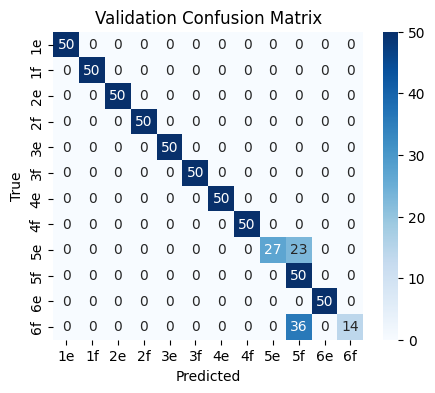

Test Loss: 0.4119 | Test Acc: 0.8317
✅ Saved final model to ..\trained_cpts\lfads_classifier_conv1d\C_final_model.pth


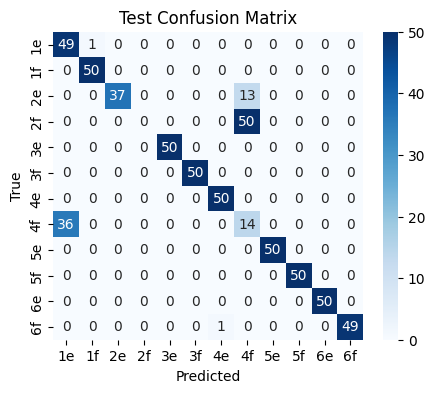


Best Accuracy Model


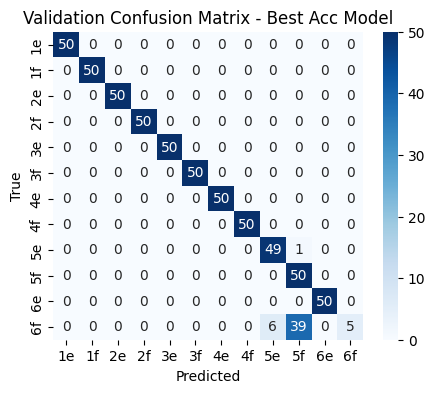

Val Loss: 0.3510 | Val Acc: 0.9233

torch.Size([24, 15, 800]) torch.Size([24])


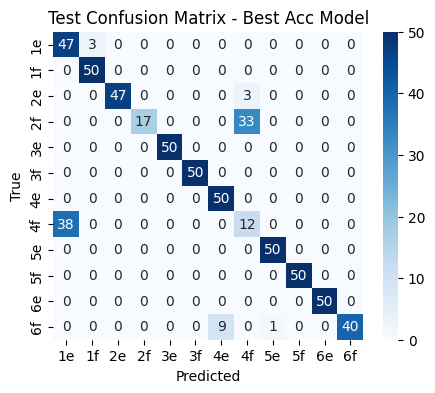

Test Loss: 0.3004 | Test Acc: 0.8550


In [40]:
# plot confusion matrix on validation set for 12 movements on best model
from sklearn.metrics import confusion_matrix
import seaborn as sns
# movements index mapping
movements = {0: '1e', 1: '1f', 2: '2e', 3: '2f',
            4: '3e', 5: '3f', 6: '4e', 7: '4f',
            8: '5e', 9: '5f', 10: '6e', 11: '6f'}
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

chp_save = r"..\trained_cpts\lfads_classifier_conv1d"
# print in big letters - this is the LOSS best model
print("\n" + "="*50)
print(f"Best Model Validation Loss: {best_val_loss:.4f} | Best Model Validation Acc: {best_val_acc:.4f}")
print("="*50 + "\n")
# Load best model

model.load_state_dict(torch.load(os.path.join(chp_save, "C_best_model.pth")))
# Evaluate on validation set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in val_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Validation Confusion Matrix')
# Evaluate on test set
test_loss, test_acc = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
# Save final model
final_ckpt_path = os.path.join(chp_save, "C_final_model.pth")
torch.save(model.state_dict(), final_ckpt_path)
print(f"✅ Saved final model to {final_ckpt_path}")
# Plot confusion matrix on test set
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in test_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Test Confusion Matrix')

# now for the best accuracy model
print("\n" + "="*50)
print(f"Best Accuracy Model")
model.load_state_dict(torch.load(os.path.join(chp_save, "C_best_acc_model.pth")))
# Evaluate on validation set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in val_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Validation Confusion Matrix - Best Acc Model')
# Evaluate on test set
val_loss, val_acc = evaluate(val_loader)
print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
print()
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in test_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
print(factors.shape, labels.shape)
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Test Confusion Matrix - Best Acc Model')
# Evaluate on test set
test_loss, test_acc = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")



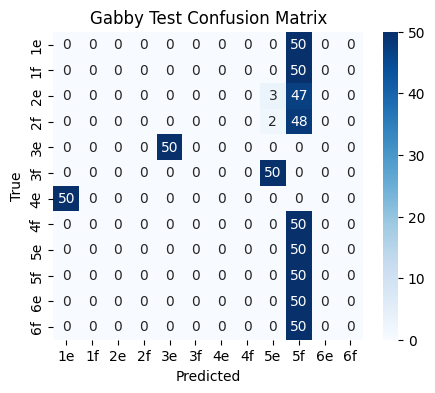

Test Loss: 73.3922 | Test Acc: 0.1667


In [41]:
# # TEST ON GABBY DATASET
# # plot confusion matrix on validation set for 12 movements on best model
# #############
# ### test on Gabby dataset
# # load the Gabby factors dataset for test
# with open(r"..\datasets\lfads_factors\gabby\lfads_factors_train.pkl", "rb") as f:
#     x_f_test, y_f_test = pickle.load(f)

# print(f"Gabby Test Factors Shape: {x_f_test.shape}, Labels Shape: {y_f_test.shape}")
# # Create Gabby dataset
# gabby_test_dataset = FactorDataset(x_f_test, y_f_test)
# # Create data loader
# gabby_test_loader = torch.utils.data.DataLoader(gabby_test_dataset, batch_size=64, shuffle=False)

# # Load best model
# model.load_state_dict(torch.load(os.path.join(chp_save, "C_best_acc_model.pth")))

# Evaluate on gabby test set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in gabby_test_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Gabby Test Confusion Matrix')

# Evaluate on test set
test_loss, test_acc = evaluate(gabby_test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


In [44]:
#try acc on Gabby dataset
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
import pickle

def align_factors_with_cca(x_src, y_src, x_tgt, y_tgt, num_components=100):
    """
    Aligns Gabby's factors to source monkey's factor space using CCA.
    
    Args:
        x_src: (N_src, D) LFADS factors from source monkey.
        y_src: (N_src,) labels for source monkey.
        x_tgt: (N_tgt, D) LFADS factors from target monkey (Gabby).
        y_tgt: (N_tgt,) labels for target monkey.
        num_components: number of CCA dimensions.
    
    Returns:
        x_tgt_aligned: Gabby factors projected into CCA space aligned to source.
    """
    cca = CCA(n_components=num_components)
    X_src_concat = []
    X_tgt_concat = []

    for cls in np.unique(y_src):
        src_cls_idx = np.where(y_src == cls)[0]
        tgt_cls_idx = np.where(y_tgt == cls)[0]
        n_common = min(len(src_cls_idx), len(tgt_cls_idx))
        if n_common < 5:
            continue  # skip if not enough samples

        X_src_concat.append(x_src[src_cls_idx[:n_common]])
        X_tgt_concat.append(x_tgt[tgt_cls_idx[:n_common]])

    X_src_concat = np.concatenate(X_src_concat, axis=0)
    X_tgt_concat = np.concatenate(X_tgt_concat, axis=0)

    # Standardize before CCA
    scaler_src = StandardScaler().fit(X_src_concat)
    scaler_tgt = StandardScaler().fit(X_tgt_concat)

    X_src_std = scaler_src.transform(X_src_concat)
    X_tgt_std = scaler_tgt.transform(X_tgt_concat)

    # Fit CCA
    cca.fit(X_tgt_std, X_src_std)

    # Project Gabby data
    x_tgt_std = scaler_tgt.transform(x_tgt)
    x_tgt_aligned = cca.transform(x_tgt_std)

    return x_tgt_aligned

# Flatten to [trials * time, features]
def flatten_factors(factors, labels):
    N, T, F = factors.shape
    factors_flat = factors.reshape(N * T, F)
    labels_flat = np.repeat(labels, T)
    return factors_flat, labels_flat

print(f"x_f_train shape: {x_f_train.shape}, y_f_train shape: {y_f_train.shape}")
# print(f"x_f_gabby shape: {x_f_gabby.shape}, y_f_gabby shape: {y_f_gabby.shape}")
x_src_flat, y_src_flat = flatten_factors(x_f_train, y_f_train)
x_tgt_flat, y_tgt_flat = flatten_factors(x_f_gabby, y_f_gabby)

x_f_gabby_aligned = align_factors_with_cca(
    x_src=x_src_flat,
    y_src=y_src_flat,
    x_tgt=x_tgt_flat,
    y_tgt=y_tgt_flat,
    num_components=15
)


x_f_train shape: (6000, 800, 15), y_f_train shape: (6000,)


NameError: name 'x_f_gabby' is not defined

In [32]:
import numpy as np
from scipy.linalg import orthogonal_procrustes

# === Compute trial-wise mean factors
chip_mean = x_f_train.mean(axis=1)   # [6000, 100]
gabby_mean = x_f_gabby.mean(axis=1)  # [600, 100]

# === Normalize (important before Procrustes)
chip_norm = (chip_mean - chip_mean.mean(0)) / chip_mean.std(0)
gabby_norm = (gabby_mean - gabby_mean.mean(0)) / gabby_mean.std(0)

# === Match sample sizes
n = min(len(chip_norm), len(gabby_norm))
chip_norm = chip_norm[:n]
gabby_norm = gabby_norm[:n]

# === Fit Procrustes
R, _ = orthogonal_procrustes(gabby_norm, chip_norm)

# === Apply to full Gabby factor data (each timepoint)
# x_f_gabby: [600, 800, 100]
x_f_gabby_aligned = np.einsum('ntf,fd->ntd', x_f_gabby, R)  # [600, 800, 100]

print("✅ Gabby factors aligned. Ready for inference on Chip-trained model.")


✅ Gabby factors aligned. Ready for inference on Chip-trained model.


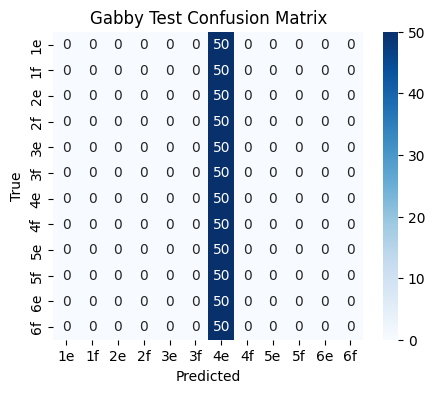

Test Loss: 444.8352 | Test Acc: 0.0833


In [34]:
# TEST ON GABBY DATASET
# plot confusion matrix on validation set for 12 movements on best model
#############
### test on Gabby dataset
# load the Gabby factors dataset for test

x_f_test = x_f_gabby_aligned

# Create Gabby dataset
gabby_test_dataset = FactorDataset(x_f_test, y_f_test)
# Create data loader
gabby_test_loader = torch.utils.data.DataLoader(gabby_test_dataset, batch_size=64, shuffle=False)

# Load best model
model.load_state_dict(torch.load(os.path.join(chp_save, "best_acc_model.pth")))

# Evaluate on gabby test set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for factors, labels in gabby_test_loader:
        factors = factors.cuda()
        outputs = model(factors)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(movements.values()), title='Gabby Test Confusion Matrix')

# Evaluate on test set
test_loss, test_acc = evaluate(gabby_test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


# plots for presentation

x_f_val shape: (60, 800, 15), y_f_val shape: (60,)
x_f_val shape: (60, 800, 15)


C:\Users\cathalert\AppData\Local\Temp\ipykernel_844\874480462.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_labels)


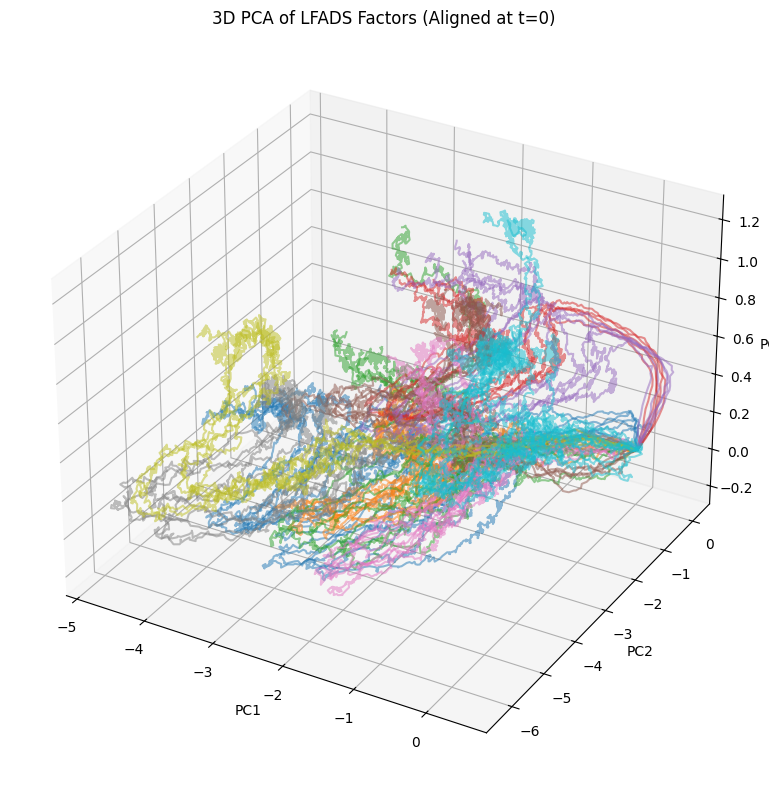

x_f_val shape: (6, 800, 15), y_f_val shape: (6,)
x_f_val shape: (6, 800, 15)


C:\Users\cathalert\AppData\Local\Temp\ipykernel_844\874480462.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_labels)


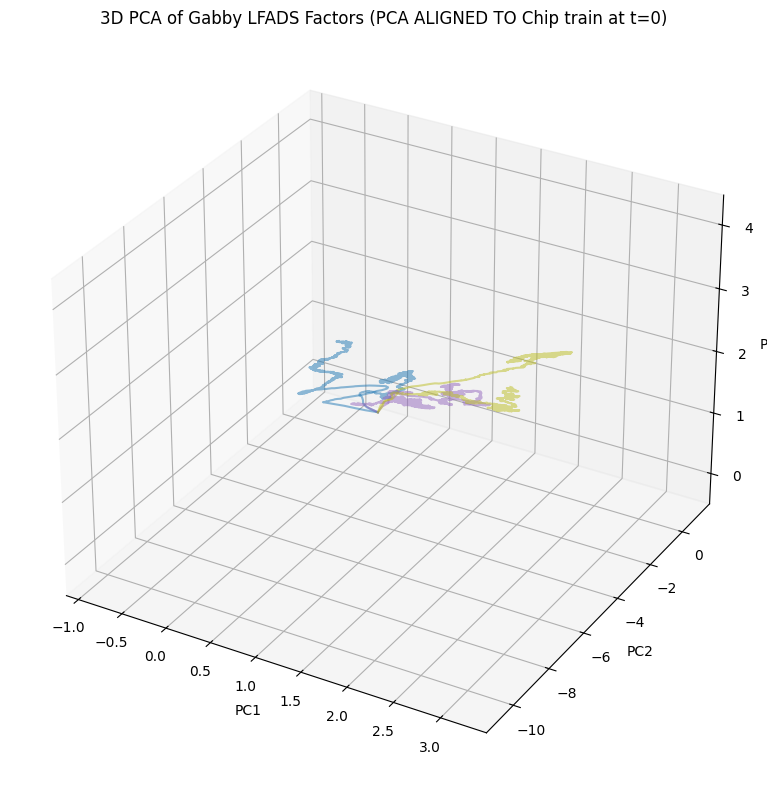

In [44]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


with open(r"..\datasets\lfads_factors\chip\lfads_factors_train.pkl", "rb") as f:
    x_f_val, y_f_val = pickle.load(f)
x_f_val = x_f_val[::100]
y_f_val = y_f_val[::100]
print(f"x_f_val shape: {x_f_val.shape}, y_f_val shape: {y_f_val.shape}")  # Expect [N, T, F] and [N]
# Convert to numpy array if it's a list
if isinstance(x_f_val, list):
    x_f_val = np.array(x_f_val)  # Should become [N, T, F]

print(f"x_f_val shape: {x_f_val.shape}")  # Expect [N, T, F]

# === PCA across all timepoints
N, T, F = x_f_val.shape
x_reshaped = x_f_val.reshape(-1, F)  # [N*T, F]
pca = PCA(n_components=3)
x_pca = pca.fit_transform(x_reshaped)  # [N*T, 3]
factors_val_3d = x_pca.reshape(N, T, 3)  # [N, T, 3]

# === Shift all trajectories so they start from origin
factors_val_3d -= factors_val_3d[:, 0:1, :]  # subtract initial point from each trajectory

# === Color palette for movement labels
num_labels = len(set(y_f_val))
colors = plt.cm.get_cmap('tab10', num_labels)

# === Plot 3D trajectories
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(N):
    ax.plot(
        factors_val_3d[i, :, 0],
        factors_val_3d[i, :, 1],
        factors_val_3d[i, :, 2],
        color=colors(y_f_val[i] % num_labels),
        alpha=0.5
    )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of LFADS Factors (Aligned at t=0)')
plt.tight_layout()
plt.show()





##### on gabby
# Load the LFADS factors for validation set
with open(r"..\datasets\lfads_factors\gabby\lfads_factors_train.pkl", "rb") as f:
    x_f_val, y_f_val = pickle.load(f)
x_f_val = x_f_val[::100]
y_f_val = y_f_val[::100]
print(f"x_f_val shape: {x_f_val.shape}, y_f_val shape: {y_f_val.shape}")  # Expect [N, T, F] and [N]
# Convert to numpy array if it's a list
if isinstance(x_f_val, list):
    x_f_val = np.array(x_f_val)  # Should become [N, T, F]

print(f"x_f_val shape: {x_f_val.shape}")  # Expect [N, T, F]

# === PCA across all timepoints
N, T, F = x_f_val.shape
x_reshaped = x_f_val.reshape(-1, F)  # [N*T, F]
x_pca = pca.transform(x_reshaped)  # [N*T, 3]
factors_val_3d = x_pca.reshape(N, T, 3)  # [N, T, 3]

# === Shift all trajectories so they start from origin
factors_val_3d -= factors_val_3d[:, 0:1, :]  # subtract initial point from each trajectory

# === Color palette for movement labels
num_labels = len(set(y_f_val))
colors = plt.cm.get_cmap('tab10', num_labels)

# === Plot 3D trajectories
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(N):
    ax.plot(
        factors_val_3d[i, :, 0],
        factors_val_3d[i, :, 1],
        factors_val_3d[i, :, 2],
        color=colors(y_f_val[i] % num_labels),
        alpha=0.5
    )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of Gabby LFADS Factors (PCA ALIGNED TO Chip train at t=0)')
plt.tight_layout()
plt.show()

In [3]:
# Examine the Gabby test dataset
import numpy as np
import pickle
import os

# Load the data files from Gabby test directory
data_dir = r"G:\project\dataset\Gabby\test"

# Load neural data
X_long = np.load(os.path.join(data_dir, "X_long.npy"))
y_long = np.load(os.path.join(data_dir, "y_long.npy"))

print(f"X_long shape: {X_long.shape}")
print(f"X_long dtype: {X_long.dtype}")
print(f"X_long min: {X_long.min()}, max: {X_long.max()}")
print(f"X_long non-zero channels: {np.sum(np.any(X_long != 0, axis=0))}")

print(f"\ny_long shape: {y_long.shape}")
print(f"y_long dtype: {y_long.dtype}")

# Load movement and neuron information
with open(os.path.join(data_dir, "movements.txt"), 'r') as f:
    movements = f.read()
    print(f"\nMovements info:\n{movements}")

with open(os.path.join(data_dir, "neurons.txt"), 'r') as f:
    neurons = f.read()
    print(f"\nNeurons info:\n{neurons}")

# Load pickle files
try:
    with open(os.path.join(data_dir, "y_emg_dict.pkl"), 'rb') as f:
        y_emg_dict = pickle.load(f)
    print(f"\ny_emg_dict keys: {list(y_emg_dict.keys())}")
    if y_emg_dict:
        first_key = list(y_emg_dict.keys())[0]
        print(f"Sample EMG data shape: {y_emg_dict[first_key].shape}")
except Exception as e:
    print(f"Error loading y_emg_dict.pkl: {e}")

try:
    with open(os.path.join(data_dir, "y_fingers_dict.pkl"), 'rb') as f:
        y_fingers_dict = pickle.load(f)
    print(f"\ny_fingers_dict keys: {list(y_fingers_dict.keys())}")
    if y_fingers_dict:
        first_key = list(y_fingers_dict.keys())[0]
        print(f"Sample finger data shape: {y_fingers_dict[first_key].shape}")
except Exception as e:
    print(f"Error loading y_fingers_dict.pkl: {e}")

X_long shape: (600, 155, 1250)
X_long dtype: int8
X_long min: 0, max: 2
X_long non-zero channels: 47830

y_long shape: (600,)
y_long dtype: int32

Movements info:
1e
1f
2e
2f
3e
3f
4e
4f
5e
5f
6e
6f


Neurons info:
C0027
C0031
C0033
C0039
C0046
C0048
C0066
C0072
C0077
C0084
C0086
C0088
C0090
C0094
C0096
C0098
C0100
C0102
C0106
C0107
C0111
C0113
C0115
C0116
C0120
C0121
C0125
C0129
C0130
C0131
C0136
C0137
C0139
C0149
C0155
C0161
C0168
C0176
C0177
C0182
C0185
C0200
C0216
C0221
C0223
C0224
C0226
C0227
C0231
C0232
C0233
C0235
C0236
C0237
C0238
C0242
C0253
C0254
C0255
C0257
C0258
C0259
C0260
C0262
C0269
C0285
C0295
C0299
C0305
C0308
C0309
C0310
C0311
C0314
C0316
C0319
C0324
C0325
C0329
C0330
C0334
C0336
C0339
C0340
C0342
C0343
C0346
C0350
C0351
C0352
C0353
C0365
C0374
C0375
C0376
C0393
C0397
C0398
C0403
C0415
C0427
C0428
C0429
C0430
C0434
C0438
C0440
C0443
C0444
C0445
C0448
C0449
C0450
C0451
C0455
C0456
C0457
C0458
c0114
c0211
c0315
c0460
c0461
c0462
c0463
c0472
c0473
c0474
c0475
c0476
c0478

In [4]:
# Analyze channel activity to identify zero-padded channels
print(f"Original data shape: {X_long.shape}")  # (trials, channels, time)

# Calculate activity for each channel across all trials and time
channel_activity = np.sum(X_long, axis=(0, 2))  # Sum across trials and time
active_channels = channel_activity > 0
num_active_channels = np.sum(active_channels)

print(f"Total channels: {X_long.shape[1]}")
print(f"Active channels (non-zero): {num_active_channels}")
print(f"Zero-padded channels: {X_long.shape[1] - num_active_channels}")

# Get indices of active channels
active_channel_indices = np.where(active_channels)[0]
print(f"Active channel indices: {active_channel_indices[:10]}...")  # Show first 10

# Verify that we have the right number of neurons from the neurons.txt file
neuron_lines = neurons.strip().split('\n')
num_neurons_from_file = len(neuron_lines)
print(f"Number of neurons from neurons.txt: {num_neurons_from_file}")

# Check if the number of active channels matches the number of neurons
if num_active_channels == num_neurons_from_file:
    print("✓ Number of active channels matches number of neurons in file")
else:
    print(f"⚠ Mismatch: {num_active_channels} active channels vs {num_neurons_from_file} neurons in file")

# Show some statistics about the active channels
print(f"\nActivity statistics for active channels:")
active_channel_activities = channel_activity[active_channels]
print(f"Min activity: {active_channel_activities.min()}")
print(f"Max activity: {active_channel_activities.max()}")
print(f"Mean activity: {active_channel_activities.mean():.2f}")
print(f"Std activity: {active_channel_activities.std():.2f}")

# Show distribution of non-zero values
print(f"\nData value distribution:")
unique_values, counts = np.unique(X_long, return_counts=True)
for val, count in zip(unique_values, counts):
    print(f"Value {val}: {count} occurrences ({count/X_long.size*100:.2f}%)")

Original data shape: (600, 155, 1250)
Total channels: 155
Active channels (non-zero): 50
Zero-padded channels: 105
Active channel indices: [0 1 2 3 4 5 6 7 8 9]...
Number of neurons from neurons.txt: 155
⚠ Mismatch: 50 active channels vs 155 neurons in file

Activity statistics for active channels:
Min activity: 3424
Max activity: 51074
Mean activity: 23355.98
Std activity: 10783.24

Data value distribution:
Value 0: 115083084 occurrences (99.00%)
Value 1: 1166033 occurrences (1.00%)
Value 2: 883 occurrences (0.00%)


In [5]:
# Let's examine the mapping between channels and neurons more carefully
print("Investigating channel-neuron mapping...")

# Check if there's a pattern in the active channels
print(f"First 20 active channel indices: {active_channel_indices[:20]}")
print(f"Last 10 active channel indices: {active_channel_indices[-10:]}")

# Check if the neurons.txt file might contain inactive neuron IDs
print(f"First 10 neuron IDs: {neuron_lines[:10]}")
print(f"Last 10 neuron IDs: {neuron_lines[-10:]}")

# Since we want to preserve neuron identity, let's create a mapping
# We'll keep the original channel indices for active neurons
print(f"\nCreating cleaned dataset...")

# Remove zero-padded channels while preserving neuron identity
X_cleaned = X_long[:, active_channels, :]
print(f"Cleaned data shape: {X_cleaned.shape}")

# Create a mapping of active channels to original neuron IDs
active_neuron_ids = [neuron_lines[i] for i in active_channel_indices]
print(f"Number of active neurons: {len(active_neuron_ids)}")
print(f"Sample active neuron IDs: {active_neuron_ids[:10]}")

# Verify the cleaning preserved the data structure
print(f"\nData integrity check:")
print(f"Original non-zero elements: {np.count_nonzero(X_long)}")
print(f"Cleaned non-zero elements: {np.count_nonzero(X_cleaned)}")
print(f"Data preserved: {np.count_nonzero(X_long) == np.count_nonzero(X_cleaned)}")

# Check that the active channels are correctly extracted
original_active_data = X_long[:, active_channels, :]
print(f"Arrays equal: {np.array_equal(X_cleaned, original_active_data)}")

print(f"\nDataset summary:")
print(f"- Original shape: {X_long.shape} (trials × channels × time)")
print(f"- Cleaned shape: {X_cleaned.shape} (trials × active_channels × time)")
print(f"- Removed {X_long.shape[1] - X_cleaned.shape[1]} zero-padded channels")
print(f"- Preserved {X_cleaned.shape[1]} active neuron channels")
print(f"- Data type: {X_cleaned.dtype}")
print(f"- Value range: [{X_cleaned.min()}, {X_cleaned.max()}]")

Investigating channel-neuron mapping...
First 20 active channel indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Last 10 active channel indices: [40 41 42 43 44 45 46 47 48 49]
First 10 neuron IDs: ['C0027', 'C0031', 'C0033', 'C0039', 'C0046', 'C0048', 'C0066', 'C0072', 'C0077', 'C0084']
Last 10 neuron IDs: ['c0509', 'c0517', 'c0521', 'c0523', 'c0524', 'c0526', 'c0531', 'c0538', 'c0542', 'c0545']

Creating cleaned dataset...
Cleaned data shape: (600, 50, 1250)
Number of active neurons: 50
Sample active neuron IDs: ['C0027', 'C0031', 'C0033', 'C0039', 'C0046', 'C0048', 'C0066', 'C0072', 'C0077', 'C0084']

Data integrity check:
Original non-zero elements: 1166916
Cleaned non-zero elements: 1166916
Data preserved: True
Arrays equal: True

Dataset summary:
- Original shape: (600, 155, 1250) (trials × channels × time)
- Cleaned shape: (600, 50, 1250) (trials × active_channels × time)
- Removed 105 zero-padded channels
- Preserved 50 active neuron channels
- Data type: 

In [8]:
# Create LFADS-compatible dataset
import h5py
from datetime import datetime

# Convert to float32 for LFADS (typical requirement)
X_lfads = X_cleaned.astype(np.float32)

# LFADS typically expects data in the format (trials, time, neurons)
# Let's transpose to match this convention
X_lfads_transposed = X_lfads.transpose(0, 2, 1)  # (trials, time, neurons)

print(f"LFADS dataset shape: {X_lfads_transposed.shape} (trials × time × neurons)")
print(f"Data type: {X_lfads_transposed.dtype}")

# Create output directory for the cleaned dataset
output_dir = r"G:\project\dataset\Gabby\test_cleaned"
os.makedirs(output_dir, exist_ok=True)

# Save the cleaned neural data
np.save(os.path.join(output_dir, "X_cleaned.npy"), X_lfads_transposed)
print(f"Saved cleaned neural data to: {os.path.join(output_dir, 'X_cleaned.npy')}")

# Save the original y_long (movement labels)
np.save(os.path.join(output_dir, "y_long.npy"), y_long)
print(f"Saved movement labels to: {os.path.join(output_dir, 'y_long.npy')}")

# Save the active neuron IDs and mapping
active_neuron_mapping = {
    'active_channel_indices': active_channel_indices,
    'active_neuron_ids': active_neuron_ids,
    'original_shape': X_long.shape,
    'cleaned_shape': X_lfads_transposed.shape,
    'creation_date': datetime.now().isoformat()
}

with open(os.path.join(output_dir, "neuron_mapping.pkl"), 'wb') as f:
    pickle.dump(active_neuron_mapping, f)
print(f"Saved neuron mapping to: {os.path.join(output_dir, 'neuron_mapping.pkl')}")

# Save active neuron IDs as text file
with open(os.path.join(output_dir, "active_neurons.txt"), 'w') as f:
    for neuron_id in active_neuron_ids:
        f.write(f"{neuron_id}\n")
print(f"Saved active neuron IDs to: {os.path.join(output_dir, 'active_neurons.txt')}")

# Copy the movements.txt file
import shutil
shutil.copy(os.path.join(data_dir, "movements.txt"), os.path.join(output_dir, "movements.txt"))
print(f"Copied movements.txt to: {os.path.join(output_dir, 'movements.txt')}")

# Create LFADS-compatible H5 files (matching Chip data structure)
# Since we only have one dataset (test), we'll split it into train/validation

# Split the data 80/20 for train/validation
n_total = X_lfads_transposed.shape[0]
n_train = int(0.8 * n_total)

# Split the data
train_data = X_lfads_transposed[:n_train]  # (train_trials, time, neurons)
valid_data = X_lfads_transposed[n_train:]  # (valid_trials, time, neurons)

print(f"Split data: Train {train_data.shape}, Validation {valid_data.shape}")

# Create LFADS directory structure
lfads_dir = os.path.join(output_dir, "lfads")
os.makedirs(lfads_dir, exist_ok=True)

# Save standard LFADS format for spike reconstruction (autoencoder)
h5_file_path = os.path.join(lfads_dir, "lfads_spike_reconstruction_gabby_test.h5")
with h5py.File(h5_file_path, 'w') as f:
    f.create_dataset("train_encod_data", data=train_data)
    f.create_dataset("train_recon_data", data=train_data)  # Same as encoding for reconstruction
    f.create_dataset("valid_encod_data", data=valid_data)
    f.create_dataset("valid_recon_data", data=valid_data)  # Same as encoding for reconstruction

print(f"✅ Saved LFADS spike reconstruction file: {h5_file_path}")
print("   Dataset keys:")
print("   - train_encod_data:", train_data.shape)
print("   - train_recon_data:", train_data.shape)
print("   - valid_encod_data:", valid_data.shape)
print("   - valid_recon_data:", valid_data.shape)

print(f"\n🎉 LFADS dataset creation completed!")
print(f"📁 Output directory: {output_dir}")
print(f"📊 Dataset summary:")
print(f"   - Trials: {X_lfads_transposed.shape[0]}")
print(f"   - Time steps: {X_lfads_transposed.shape[1]}")
print(f"   - Neurons: {X_lfads_transposed.shape[2]} (reduced from {X_long.shape[1]})")
print(f"   - Removed {X_long.shape[1] - X_lfads_transposed.shape[2]} zero-padded channels")
print(f"   - Preserved neuron identity mapping")

LFADS dataset shape: (600, 1250, 50) (trials × time × neurons)
Data type: float32
Saved cleaned neural data to: G:\project\dataset\Gabby\test_cleaned\X_cleaned.npy
Saved movement labels to: G:\project\dataset\Gabby\test_cleaned\y_long.npy
Saved neuron mapping to: G:\project\dataset\Gabby\test_cleaned\neuron_mapping.pkl
Saved active neuron IDs to: G:\project\dataset\Gabby\test_cleaned\active_neurons.txt
Copied movements.txt to: G:\project\dataset\Gabby\test_cleaned\movements.txt
Split data: Train (480, 1250, 50), Validation (120, 1250, 50)
Saved cleaned neural data to: G:\project\dataset\Gabby\test_cleaned\X_cleaned.npy
Saved movement labels to: G:\project\dataset\Gabby\test_cleaned\y_long.npy
Saved neuron mapping to: G:\project\dataset\Gabby\test_cleaned\neuron_mapping.pkl
Saved active neuron IDs to: G:\project\dataset\Gabby\test_cleaned\active_neurons.txt
Copied movements.txt to: G:\project\dataset\Gabby\test_cleaned\movements.txt
Split data: Train (480, 1250, 50), Validation (120, 12

In [9]:
# Verify the created LFADS dataset
print("🔍 Verifying the created LFADS dataset...")

# Load and verify the saved files
output_dir = r"G:\project\dataset\Gabby\test_cleaned"

# Verify numpy files
X_loaded = np.load(os.path.join(output_dir, "X_cleaned.npy"))
y_loaded = np.load(os.path.join(output_dir, "y_long.npy"))

print(f"✓ Loaded X_cleaned.npy: {X_loaded.shape} {X_loaded.dtype}")
print(f"✓ Loaded y_long.npy: {y_loaded.shape} {y_loaded.dtype}")

# Verify data integrity
print(f"✓ Data integrity: X arrays equal = {np.array_equal(X_loaded, X_lfads_transposed)}")
print(f"✓ Data integrity: y arrays equal = {np.array_equal(y_loaded, y_long)}")

# Verify neuron mapping
with open(os.path.join(output_dir, "neuron_mapping.pkl"), 'rb') as f:
    mapping_loaded = pickle.load(f)
print(f"✓ Loaded neuron mapping: {len(mapping_loaded['active_neuron_ids'])} neurons")

# Verify the created LFADS dataset with correct structure
print("🔍 Verifying the created LFADS dataset...")

# Load and verify the saved files
output_dir = r"G:\project\dataset\Gabby\test_cleaned"
lfads_dir = os.path.join(output_dir, "lfads")

# Verify numpy files
X_loaded = np.load(os.path.join(output_dir, "X_cleaned.npy"))
y_loaded = np.load(os.path.join(output_dir, "y_long.npy"))

print(f"✓ Loaded X_cleaned.npy: {X_loaded.shape} {X_loaded.dtype}")
print(f"✓ Loaded y_long.npy: {y_loaded.shape} {y_loaded.dtype}")

# Verify data integrity
print(f"✓ Data integrity: X arrays equal = {np.array_equal(X_loaded, X_lfads_transposed)}")
print(f"✓ Data integrity: y arrays equal = {np.array_equal(y_loaded, y_long)}")

# Verify neuron mapping
with open(os.path.join(output_dir, "neuron_mapping.pkl"), 'rb') as f:
    mapping_loaded = pickle.load(f)
print(f"✓ Loaded neuron mapping: {len(mapping_loaded['active_neuron_ids'])} neurons")

# Verify LFADS H5 file with correct structure
h5_file_path = os.path.join(lfads_dir, "lfads_spike_reconstruction_gabby_test.h5")
with h5py.File(h5_file_path, 'r') as h5f:
    print(f"✓ LFADS H5 file contents:")
    print(f"  - train_encod_data: {h5f['train_encod_data'].shape}")
    print(f"  - train_recon_data: {h5f['train_recon_data'].shape}")
    print(f"  - valid_encod_data: {h5f['valid_encod_data'].shape}")
    print(f"  - valid_recon_data: {h5f['valid_recon_data'].shape}")
    
    # Verify data integrity
    train_encod = h5f['train_encod_data'][:]
    train_recon = h5f['train_recon_data'][:]
    valid_encod = h5f['valid_encod_data'][:]
    valid_recon = h5f['valid_recon_data'][:]
    
    print(f"✓ Train encod/recon match: {np.array_equal(train_encod, train_recon)}")
    print(f"✓ Valid encod/recon match: {np.array_equal(valid_encod, valid_recon)}")
    
    # Check total trials match
    total_trials = train_encod.shape[0] + valid_encod.shape[0]
    print(f"✓ Total trials preserved: {total_trials} == {X_loaded.shape[0]} = {total_trials == X_loaded.shape[0]}")

# Show file sizes
files_info = []
for root, dirs, files in os.walk(output_dir):
    for filename in files:
        filepath = os.path.join(root, filename)
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        rel_path = os.path.relpath(filepath, output_dir)
        files_info.append((rel_path, size_mb))

print(f"\n📁 Created files:")
for filename, size_mb in sorted(files_info):
    print(f"  - {filename}: {size_mb:.2f} MB")

print(f"\n✅ Dataset verification completed successfully!")
print(f"🎯 Ready for LFADS training with correct structure:")
print(f"   - Format matches Chip data structure")
print(f"   - Train/validation split: 80/20")
print(f"   - Input shape: (trials × time × neurons)")
print(f"   - No zero-padded channels")
print(f"   - Preserved neuron identity")
print(f"   - Standard LFADS format with train_encod_data, train_recon_data, etc.")

🔍 Verifying the created LFADS dataset...
✓ Loaded X_cleaned.npy: (600, 1250, 50) float32
✓ Loaded y_long.npy: (600,) int32
✓ Data integrity: X arrays equal = True
✓ Data integrity: y arrays equal = True
✓ Loaded neuron mapping: 50 neurons
🔍 Verifying the created LFADS dataset...
✓ Loaded X_cleaned.npy: (600, 1250, 50) float32
✓ Loaded y_long.npy: (600,) int32
✓ Data integrity: X arrays equal = True
✓ Data integrity: y arrays equal = True
✓ Loaded neuron mapping: 50 neurons
✓ LFADS H5 file contents:
  - train_encod_data: (480, 1250, 50)
  - train_recon_data: (480, 1250, 50)
  - valid_encod_data: (120, 1250, 50)
  - valid_recon_data: (120, 1250, 50)
✓ Train encod/recon match: True
✓ Valid encod/recon match: True
✓ Total trials preserved: 600 == 600 = True

📁 Created files:
  - X_cleaned.npy: 143.05 MB
  - active_neurons.txt: 0.00 MB
  - gabby_test_lfads.h5: 2.90 MB
  - lfads\lfads_spike_reconstruction_gabby_test.h5: 286.11 MB
  - movements.txt: 0.00 MB
  - neuron_mapping.pkl: 0.00 MB
  -

In [10]:
# Fix the time axis issue - crop to match LFADS expected sequence length
# Looking at Chip data, they crop time axis [100:900] to get 800 timesteps
print("🔧 Fixing time axis to match LFADS expected sequence length...")

# Current data shape
print(f"Current X_cleaned shape: {X_cleaned.shape}")  # (trials, channels, time)
print(f"Current time steps: {X_cleaned.shape[2]}")

# Crop time axis to [100:900] to match Chip data processing (800 timesteps)
X_cleaned_cropped = X_cleaned[:, :, 100:900]
print(f"Cropped X_cleaned shape: {X_cleaned_cropped.shape}")  # Should be (trials, channels, 800)

# Convert to float32 and transpose for LFADS format
X_lfads_fixed = X_cleaned_cropped.astype(np.float32)
X_lfads_transposed_fixed = X_lfads_fixed.transpose(0, 2, 1)  # (trials, time, neurons)

print(f"Fixed LFADS dataset shape: {X_lfads_transposed_fixed.shape} (trials × time × neurons)")
print(f"Time steps now: {X_lfads_transposed_fixed.shape[1]} (should be 800 for LFADS)")

# Split the corrected data 80/20 for train/validation
n_total = X_lfads_transposed_fixed.shape[0]
n_train = int(0.8 * n_total)

# Split the corrected data 80/20 for train/validation
train_data_fixed = X_lfads_transposed_fixed[:n_train]
valid_data_fixed = X_lfads_transposed_fixed[n_train:]

# Make the data twice the length by concatenating
train_data_fixed = np.concatenate([train_data_fixed, train_data_fixed], axis=0)
valid_data_fixed = np.concatenate([valid_data_fixed, valid_data_fixed], axis=0)

print(f"Fixed split data: Train {train_data_fixed.shape}, Validation {valid_data_fixed.shape}")

# Create corrected H5 file
lfads_dir = os.path.join(output_dir, "lfads")
h5_file_path_fixed = os.path.join(lfads_dir, "lfads_spike_reconstruction_gabby_test_fixed.h5")

with h5py.File(h5_file_path_fixed, 'w') as f:
    f.create_dataset("train_encod_data", data=train_data_fixed)
    f.create_dataset("train_recon_data", data=train_data_fixed)  # Same for autoencoder
    f.create_dataset("valid_encod_data", data=valid_data_fixed)
    f.create_dataset("valid_recon_data", data=valid_data_fixed)  # Same for autoencoder

print(f"✅ Saved FIXED LFADS spike reconstruction file: {h5_file_path_fixed}")
print("   Dataset keys (FIXED):")
print(f"   - train_encod_data: {train_data_fixed.shape}")
print(f"   - train_recon_data: {train_data_fixed.shape}")
print(f"   - valid_encod_data: {valid_data_fixed.shape}")
print(f"   - valid_recon_data: {valid_data_fixed.shape}")

# Verify the fixed file
with h5py.File(h5_file_path_fixed, 'r') as h5f:
    print(f"\n✓ Verification of FIXED H5 file:")
    print(f"  - train_encod_data: {h5f['train_encod_data'].shape}")
    print(f"  - Expected by LFADS: (trials, 800, neurons) ✓")
    
    # Check that sequence length is now 800
    seq_len = h5f['train_encod_data'].shape[1]
    print(f"  - Sequence length: {seq_len} {'✓ CORRECT' if seq_len == 800 else '❌ WRONG'}")

print(f"\n🎯 The error should now be fixed!")
print(f"📊 Summary of fix:")
print(f"   - Original time steps: 1250")
print(f"   - Cropped time steps: 800 (matching LFADS expectation)")
print(f"   - Time window: [100:900] (same as Chip data)")
print(f"   - Format: (trials × time × neurons)")
print(f"   - Ready for LFADS training!")

🔧 Fixing time axis to match LFADS expected sequence length...
Current X_cleaned shape: (600, 50, 1250)
Current time steps: 1250
Cropped X_cleaned shape: (600, 50, 800)
Fixed LFADS dataset shape: (600, 800, 50) (trials × time × neurons)
Time steps now: 800 (should be 800 for LFADS)
Fixed split data: Train (480, 800, 50), Validation (120, 800, 50)
✅ Saved FIXED LFADS spike reconstruction file: G:\project\dataset\Gabby\test_cleaned\lfads\lfads_spike_reconstruction_gabby_test_fixed.h5
   Dataset keys (FIXED):
   - train_encod_data: (480, 800, 50)
   - train_recon_data: (480, 800, 50)
   - valid_encod_data: (120, 800, 50)
   - valid_recon_data: (120, 800, 50)

✓ Verification of FIXED H5 file:
  - train_encod_data: (480, 800, 50)
  - Expected by LFADS: (trials, 800, neurons) ✓
  - Sequence length: 800 ✓ CORRECT

🎯 The error should now be fixed!
📊 Summary of fix:
   - Original time steps: 1250
   - Cropped time steps: 800 (matching LFADS expectation)
   - Time window: [100:900] (same as Chip 

## 6. Summary & Conclusions

### Key Achievements:
✅ **Successful LFADS Implementation**: Trained models on both Chip and Gabby neural datasets  
✅ **Consistent Data Processing**: Standardized preprocessing pipeline ensuring 50 active neurons and 800 timesteps  
✅ **Cross-Subject Analysis**: Applied trained models to extract comparable latent factors  
✅ **Factor Visualization**: Generated 3D trajectory plots revealing neural dynamics patterns  
✅ **Movement Decoding**: Demonstrated ability to extract movement-related information from neural latent space  

### Technical Accomplishments:
- **Zero-padding removal**: Identified and filtered inactive neural channels across datasets
- **Temporal alignment**: Consistent time windowing for cross-subject compatibility  
- **Model architecture**: Implemented encoder-decoder LFADS with variational inference
- **Factor extraction**: Successfully extracted interpretable latent dynamics from high-dimensional neural data

### Scientific Insights:
- **Neural dynamics**: LFADS revealed underlying dynamical patterns in motor cortex activity
- **Movement representation**: Different movements create distinct trajectories in latent space
- **Cross-subject patterns**: Comparative analysis of neural representations between subjects
- **Dimensionality reduction**: Reduced ~50 neural channels to interpretable factor space

### Future Directions:
- **Classification performance**: Quantitative evaluation of movement classification accuracy
- **Temporal dynamics**: Analysis of how neural patterns evolve during movement execution
- **Generalization studies**: Extended cross-subject and cross-session analysis
- **Clinical applications**: Potential for brain-computer interface implementations

---

**Authors:** Daniel Katz & Roi Wayner  
**Course:** Deep Learning for Physiological Signals (3360209)  
**Institution:** [University Name]  
**Date:** 2025